<a href="https://colab.research.google.com/github/SanyaKapoor/Assignment-2/blob/main/app_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Application Classification

This assignment will focus on feature extraction, ML modeling, evaluation, and explainability. You will do this in the context of application classification.

**Submission Instructions**:
- You should submit a single notebook containing your code to extract features and model evaluation, and response to Part 3.
- You should assume the CSVs are located in a folder called `data`, co-located with the notebook.
- Make sure the notebook is styled well. Write code in the relevant sections of the notebook.
- I should be able to run the entire notebook without any errors.

## Dataset download and Warmup

We will use a public dataset, called [ISCXVPN2016](https://www.unb.ca/cic/datasets/vpn.html) that consists of annotated traffic logs. While the original dataset is available in the form of PCAPs, I have also shared the CSV files extracted from the PCAPs, available on [Onedrive](https://csciitd-my.sharepoint.com/:f:/g/personal/tmangla_iitd_ac_in/Ev5JYDW-YI5CjKq3XWgL0y8BdihJTCi4v4qA5Sn1UoKisQ?e=INZ5mJ). The data consists of TSV (tab-seprated) files with each file corresponding to a different application. Each row in the file corresponds to one packet for that application. The headers follow this schema:
```
columns = ["frame.time_epoch", "frame.len", "ip.src", "ip.dst", "ip.proto",
    "udp.srcport", "udp.dstport", "tcp.srcport", "tcp.dstport",
    "tcp.flags", "tcp.flags.syn", "tcp.flags.fin", "dns.qry.name"]
```

**Getting application ground truth:** You can use the filename of the CSV file

Download the dataset and read it. You can read the data in a dataframe:
```
df = pd.read_csv(filename, sep="\t", header=None, names=columns)
```

## Part 1: Extracting Features

### Data cleaning

Extract the following features from the dataset:
- Flow-level (5 features): flow duration, volume (upstream and downstream), number of packets (upstream and downstream)
- Packet-level features (36 features): Statistics on packet inter-arrival times and packet size. These need to be computed for both upstream and downstream direction. You should compute the following statistics for each flow: mean, median, std, min, max, quantiles (25%ile, 75%iles), and deciles (10%ile, 90%ile). Compute these statistics per feature (IAT, size) and direction (upstream, downstream).

**Defining Flows**: For TCP, a flow is same as connection (determined using SYN/FIN packets). You should define UDP flows using inactivity timeout, i.e., mark the end of the flow if you don't see a packet for T seconds. Use a reasonable value of T.

Make sure you filter out the non-IP traffic as well as the DNS traffic from the data.

**Checkpoint**: Once you do that, summarize the number of flows for each application. You can extract the application name from the file name. VPN and non-VPN applications should be treated differently. You can remove classes with less than 10 instances for the next part.



In [ ]:
cd /content/drive/MyDrive/COL867_Assignment2

/content/drive/MyDrive/COL867_Assignment2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle as pkl
import gc

In [ ]:
columns = ["frame.time_epoch", "frame.len", "ip.src", "ip.dst", "ip.proto", "udp.srcport", "udp.dstport",
           "tcp.srcport","tcp.dstport", "tcp.flags", "tcp.flags.syn", "tcp.flags.fin", "dns.qry.name"]
flow_columns = ['flow.name', 'flow.duration', 'flow.volumne.up', 'flow.volumne.down', 'flow.num_packets.up', 'flow.num_packets.down']
packet_columns = ['packet.up.lens.mean', 'packet.up.lens.median', 'packet.up.lens.std', 'packet.up.lens.min', 'packet.up.lens.max',
                  'packet.up.lens.25qile', 'packet.up.lens.75qile', 'packet.up.lens.10dile', 'packet.up.lens.90dile', 'packet.down.lens.mean',
                  'packet.down.lens.median', 'packet.down.lens.std', 'packet.down.lens.min', 'packet.down.lens.max', 'packet.down.lens.25qile',
                  'packet.down.lens.75qile', 'packet.down.lens.10dile', 'packet.down.lens.90dile', 'packet.up.iat.mean', 'packet.up.iat.median',
                  'packet.up.iat.std', 'packet.up.iat.min', 'packet.up.iat.max', 'packet.up.iat.25qile', 'packet.up.iat.75qile',
                  'packet.up.iat.10dile', 'packet.up.iat.90dile', 'packet.down.iatmean', 'packet.down.iatmedian', 'packet.down.iatstd',
                  'packet.down.iatmin', 'packet.down.iatmax', 'packet.down.iat25qile', 'packet.down.iat75qile', 'packet.down.iat10dile',
                  'packet.down.iat90dile']
label_columns = ['label.is_vpn', 'label.type']

In [ ]:
def flip_row(row):
    return {x.replace('src', 'xxx').replace('dst', 'src').replace('xxx', 'dst'): row[x] for x in row.keys()}

# def get_flow(row):
#     global src_ips
#     is_up = True
#     if row['ip.dst'] in src_ips:
#         row = flip_row(row)
#         is_up = False
#     else:
#         src_ips.add(row['ip.src'])
#     proto = row['ip.proto']
#     if proto == 17:
#         return pd.Series(["{}_{}_{}_{}_{}".format(row['ip.src'], row['ip.dst'], row['ip.proto'], row['udp.srcport'], row['udp.dstport']), is_up])
#     if proto == 6:
#         return pd.Series(["{}_{}_{}_{}_{}".format(row['ip.src'], row['ip.dst'], row['ip.proto'], row['tcp.srcport'], row['tcp.dstport']), is_up])
#     return pd.Series(["{}_{}_{}".format(row['ip.src'], row['ip.dst'], row['ip.proto']), is_up])

# def filter_flow(row, flow_name):
#     return (get_flow(row) == flow_name) or (get_flow(flip_row(row)) == flow_name)

def get_flow_data(df, flow_name):
    flow_df = df[df['flow.name'] == cur_flow]
    frame_time_epoch = flow_df['frame.time_epoch'].to_numpy()
    if len(frame_time_epoch) < 2:
        return 0
    min_time = np.min(flow_df['frame.time_epoch'].to_numpy())
    max_time = np.max(flow_df['frame.time_epoch'].to_numpy())

    flow_up_lens = flow_df[flow_df['flow.is_up']]['frame.len'].to_numpy()
    flow_down_lens = flow_df[~flow_df['flow.is_up']]['frame.len'].to_numpy()
    return {'flow.name': flow_name, 'flow.duration': max_time - min_time, 'flow.volumne.up': np.sum(flow_up_lens),
            'flow.volumne.down': np.sum(flow_down_lens), 'flow.num_packets.up': len(flow_up_lens),
            'flow.num_packets.down': len(flow_down_lens)}

def get_stats(x):
    return {'mean': np.mean(x), 'median': np.median(x), 'std': np.std(x), 'min': np.min(x), 'max': np.max(x), '25qile': np.quantile(x, 0.25),
            '75qile': np.quantile(x, 0.75), '10dile': np.percentile(x, 10), '90dile': np.percentile(x, 90)}

def get_packet_data(df, flow_name):
    flow_df = df[df['flow.name'] == cur_flow]
    flow_up_df = flow_df[flow_df['flow.is_up']]
    flow_down_df = flow_df[~flow_df['flow.is_up']]
    if len(flow_up_df) == 0 or len(flow_down_df) == 0:
        raise Exception("Up/Down Length Zero: {} {}".format(len(flow_up_df), len(flow_down_df)))
    flow_up_lens = flow_up_df['frame.len'].to_numpy()
    flow_up_time = flow_up_df['frame.time_epoch'].to_numpy()
    if len(flow_up_lens) < 2:
        flow_up_iat = np.array([0])
    else:
        flow_up_iat = np.array([flow_up_time[i+1] - flow_up_time[i] for i in range(len(flow_up_time) - 1)])
    flow_down_lens = flow_down_df['frame.len'].to_numpy()
    flow_down_time = flow_down_df['frame.time_epoch'].to_numpy()
    if len(flow_down_lens) < 2:
        flow_down_iat = np.array([0])
    else:
        flow_down_iat = np.array([flow_down_time[i+1] - flow_down_time[i] for i in range(len(flow_down_time) - 1)])

    len_up_stats = get_stats(flow_up_lens)
    len_down_stats = get_stats(flow_down_lens)
    iat_up_stats = get_stats(flow_up_iat)
    iat_down_stats = get_stats(flow_down_iat)

    res = {}
    for x in len_up_stats:
        res['packet.up.lens.'+x] = len_up_stats[x]
    for x in len_down_stats:
        res['packet.down.lens.'+x] = len_down_stats[x]
    for x in iat_up_stats:
        res['packet.up.iat.'+x] = iat_up_stats[x]
    for x in iat_down_stats:
        res['packet.down.iat'+x] = iat_down_stats[x]
    return res

In [ ]:
key_gen = 0
def createKey():
    global key_gen
    key_gen+=1
    return key_gen

tcp_ip_set = set()
tcp_src_set = set()
tcp_ip_key_map = {}
def tcp_hash(row):
    global tcp_ip_set, tcp_src_set, tcp_ip_key_map
    flip = False
    if row['ip.proto'] != 6: return pd.Series([-2, not flip])
    if "{}:{}".format(row['ip.dst'], row['tcp.dstport']) in tcp_src_set:
        flip = True
        row = flip_row(row)
    else:
        tcp_src_set.add("{}:{}".format(row['ip.src'], row['tcp.srcport']))
    ip_src = row['ip.src']
    ip_dst = row['ip.dst']
    port_src = row['tcp.srcport']
    port_dst = row['tcp.dstport']
    ip = "{}:{}->{}:{}".format(ip_src, port_src, ip_dst, port_dst)
    if row['tcp.flags.syn'] == 1.0:
        if ip not in tcp_ip_set:
            key = createKey()
        else:
            key = tcp_ip_key_map[ip]
        tcp_ip_key_map[ip] = key
        tcp_ip_set.add(ip)
        return pd.Series([key, not flip])
    if row['tcp.flags.fin'] == 1.0:
        if ip not in tcp_ip_set:
            return pd.Series([-1, not flip])
        key = tcp_ip_key_map[ip]
        tcp_ip_set.remove(ip)
        return pd.Series([ key, not flip])
    if ip not in tcp_ip_set:
        return pd.Series([-1, not flip])
    key = tcp_ip_key_map[ip]
    return pd.Series([key, not flip])

udp_timeout = 10
udp_ip_set = set()
udp_src_set = set()
udp_ip_key_map = {}
udp_ip_ts = {}
def udp_hash(row):
    global udp_ip_set, udp_src_set, udp_ip_key_map, upd_ip_ts
    flip = False
    if row['ip.proto'] != 17: return pd.Series([-2, not flip])
    if "{}:{}".format(row['ip.dst'], row['udp.dstport']) in udp_src_set:
        flip = True
        row = flip_row(row)
    else:
        udp_src_set.add("{}:{}".format(row['ip.src'], row['udp.srcport']))
    ip_src = row['ip.src']
    ip_dst = row['ip.dst']
    port_src = row['udp.srcport']
    port_dst = row['udp.dstport']
    ip = "{}:{}->{}:{}".format(ip_src, port_src, ip_dst, port_dst)
    if ip not in udp_ip_set:
        key = createKey()
        udp_ip_set.add(ip)
        udp_ip_key_map[ip] = key
        udp_ip_ts[ip] = {'up': 0, 'down': 0}
        if not flip: udp_ip_ts[ip]['up'] = row['frame.time_epoch']
        else: udp_ip_ts[ip]['down'] = row['frame.time_epoch']
        return pd.Series([key, not flip])

    key = udp_ip_key_map[ip]
    cur_ts = row['frame.time_epoch']
    prev_ts = udp_ip_ts[ip]['down' if flip else 'up']
    if cur_ts - prev_ts > udp_timeout:
        udp_ip_set.remove(ip)
        return pd.Series([key, not flip])
    udp_ip_ts[ip]['down' if flip else 'up'] = cur_ts
    return pd.Series([key, not flip])

def get_flow(row):
    if row['ip.proto'] == 6:
        return tcp_hash(row)
    if row['ip.proto'] == 17:
        return udp_hash(row)
    return pd.Series([-3, True])

In [ ]:
data_folder = "/content/drive/MyDrive/COL867_Assignment2/Dataset/"
data_files = glob.glob(os.path.join(data_folder, "*.csv"))

In [ ]:
len(data_files)

165

In [ ]:
output_files = [x[:-4] for x in os.listdir("./data_own/")]

In [ ]:
output_files

['nonvpn_netflix_capture1',
 'nonvpn_rsync_capture1',
 'nonvpn_rdp_capture4',
 'nonvpn_netflix_capture2',
 'nonvpn_rdp_capture1',
 'nonvpn_rdp_capture2',
 'nonvpn_rdp_capture_5',
 'nonvpn_rdp_capture3',
 'nonvpn_scp_capture1',
 'nonvpn_rsync_newcapture1',
 'nonvpn_skype-chat_capture1',
 'nonvpn_skype-chat_capture2',
 'nonvpn_youtube_capture2',
 'vpn_skype-chat_capture2',
 'nonvpn_ssh_capture4',
 'vpn_skype-chat_capture1',
 'vpn_ssh_capture3',
 'nonvpn_ssh_capture2',
 'nonvpn_ssh_capture1',
 'nonvpn_sftp_newcapture2',
 'vpn_skype-chat_capture43',
 'vpn_skype-chat_capture35',
 'vpn_skype-chat_capture46',
 'vpn_skype-chat_capture54',
 'vpn_skype-chat_capture48',
 'vpn_skype-chat_capture29',
 'vpn_skype-chat_capture13',
 'vpn_skype-chat_capture26',
 'vpn_skype-chat_capture32',
 'vpn_skype-chat_capture7',
 'vpn_skype-chat_capture23',
 'vpn_skype-chat_capture18',
 'vpn_skype-chat_capture38',
 'vpn_skype-chat_capture15',
 'vpn_skype-chat_capture31',
 'vpn_skype-chat_capture40',
 'vpn_skype-ch

In [ ]:
data_files = [x for x in data_files if os.path.split(x)[1][:-4] not in output_files]

In [ ]:
len(data_files)

4

In [ ]:
data_files = sorted(data_files, key = lambda x: os.path.getsize(x))

In [ ]:
[os.path.getsize(x)/(1024*1024) for x in data_files]

[237.7941951751709, 244.30196475982666, 294.1937732696533, 1032.7837181091309]

In [ ]:
for data_file in data_files:
    gc.collect()
    flow_data = {x: [] for x in flow_columns+packet_columns+label_columns}
    print(data_file)
    file_name = os.path.split(data_file)[-1]
    try:
        key_gen = 0
        tcp_ip_set = set()
        tcp_src_set = set()
        tcp_ip_key_map = {}
        udp_ip_set = set()
        udp_src_set = set()
        udp_ip_key_map = {}
        udp_ip_ts = {}
        file_split = file_name.split('_')
        is_vpn = file_split[0]
        label_type = file_split[1]
        df = pd.read_csv(data_file, sep="\t", header=None, names=columns)
        df[['flow.name', 'flow.is_up']] = df.apply(get_flow, axis = 1)
        unique_flows = df['flow.name'].unique()
        for flow_iter, cur_flow in enumerate(unique_flows):
            try:
                print(flow_iter, len(unique_flows), end = '\r')
                cur_flow_data = get_flow_data(df, cur_flow)
                cur_packet_data = get_packet_data(df, cur_flow)
                _ = {x: flow_data[x].append(cur_flow_data[x]) for x in cur_flow_data}
                _ = {x: flow_data[x].append(cur_packet_data[x]) for x in cur_packet_data}
                flow_data['label.is_vpn'].append(is_vpn)
                flow_data['label.type'].append(label_type)
            except Exception as e:
                print(e)
                continue
    except Exception as e:
        print(file_name, e)
    with open(os.path.join("./data_own/", file_name[:-4]+".pkl"), 'wb') as f:
        pkl.dump(flow_data, f)
    del flow_data
    del tcp_ip_set
    del tcp_src_set
    del tcp_ip_key_map
    del udp_ip_set
    del udp_src_set
    del udp_ip_key_map
    del udp_ip_ts
# flow_data_df = pd.DataFrame(flow_data)

/content/drive/MyDrive/COL867_Assignment2/Dataset/vpn_sftp_capture1.csv


In [ ]:
import glob
import pandas as pd
import os
import pickle

# Define the data path
data_path = '/content/drive/My Drive/COL867_Assignment2/data_own/'

# Function to extract class label from filename
def extract_class(filename):
    base = os.path.basename(filename).replace('.pkl', '')
    parts = base.split('_')
    vpn_status = parts[0]
    if len(parts) >= 3 and parts[1] == 'skype':
        app_type = 'skype-chat'
    else:
        app_type = parts[1]
    return f"{vpn_status}_{app_type}"

# Initialize a dictionary to count occurrences of each application
app_count = {}

# Load all data files
all_files = glob.glob(os.path.join(data_path, '*.pkl'))
print(f"Found {len(all_files)} files")

# Load data from each file
for file_path in all_files:
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Extract the application label using the filename
        class_label = extract_class(file_path)

        # Increment the count for this application
        if class_label in app_count:
            app_count[class_label] += len(data['flow.name'])
        else:
            app_count[class_label] = len(data['flow.name'])
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Print summary of flows per application
for app, count in app_count.items():
    print(f"Application: {app}, Number of flows: {count}")


Found 161 files
Application: nonvpn_netflix, Number of flows: 204
Application: nonvpn_rsync, Number of flows: 1926
Application: nonvpn_rdp, Number of flows: 106802
Application: nonvpn_scp, Number of flows: 2326
Application: nonvpn_skype-chat, Number of flows: 462
Application: nonvpn_youtube, Number of flows: 304
Application: vpn_skype-chat, Number of flows: 168962
Application: nonvpn_ssh, Number of flows: 14714
Application: vpn_ssh, Number of flows: 39187
Application: nonvpn_sftp, Number of flows: 963
Application: vpn_sftp, Number of flows: 43999
Application: vpn_voip, Number of flows: 84565
Application: vpn_youtube, Number of flows: 52040
Application: nonvpn_voip, Number of flows: 0
Application: vpn_rdp, Number of flows: 111420
Application: vpn_netflix, Number of flows: 58680
Application: vpn_rsync, Number of flows: 295044
Application: vpn_vimeo, Number of flows: 106165
Application: nonvpn_vimeo, Number of flows: 1195
Application: vpn_scp, Number of flows: 590897


## Part 2: Application Classification

### Prepare your data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
!ls '/content/drive/My Drive/COL867_Assignment2/data_own/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
nonvpn_netflix_capture1.pkl	 vpn_netflix_capture2.pkl
nonvpn_netflix_capture2.pkl	 vpn_rdp_capture1.pkl
nonvpn_rdp_capture1.pkl		 vpn_rdp_capture2.pkl
nonvpn_rdp_capture2.pkl		 vpn_rdp_capture_3.pkl
nonvpn_rdp_capture3.pkl		 vpn_rsync_capture1.pkl
nonvpn_rdp_capture4.pkl		 vpn_rsync_capture2.pkl
nonvpn_rdp_capture_5.pkl	 vpn_scp_capture1.pkl
nonvpn_rsync_capture1.pkl	 vpn_scp_capture2.pkl
nonvpn_rsync_newcapture1.pkl	 vpn_sftp_capture3.pkl
nonvpn_scp_capture1.pkl		 vpn_sftp_capture4.pkl
nonvpn_scp_newcapture1.pkl	 vpn_sftp_capture5.pkl
nonvpn_sftp_capture1.pkl	 vpn_skype-chat_capture10.pkl
nonvpn_sftp_capture2.pkl	 vpn_skype-chat_capture11.pkl
nonvpn_sftp_capture3.pkl	 vpn_skype-chat_capture12.pkl
nonvpn_sftp_newcapture2.pkl	 vpn_skype-chat_capture13.pkl
nonvpn_skype-chat_capture10.pkl  vpn_skype-chat_capture14.pkl
nonvpn_skype-chat_capture11.pkl  vpn_skype-c

In [2]:
import pickle

file_path = '/content/drive/My Drive/COL867_Assignment2/data_own/nonvpn_youtube_capture2.pkl'

with open(file_path, 'rb') as file:
  data = pickle.load(file)
  print(data)

{'flow.name': [np.int64(-1), np.int64(1), np.int64(2)], 'flow.duration': [np.float64(684.5543291568756), np.float64(0.0005059242248535156), np.float64(261.9837908744812)], 'flow.volumne.up': [np.int64(18866), np.int64(87), np.int64(14034)], 'flow.volumne.down': [np.int64(43499), np.int64(103), np.int64(29656)], 'flow.num_packets.up': [162, 1, 105], 'flow.num_packets.down': [178, 1, 118], 'packet.up.lens.mean': [np.float64(116.45679012345678), np.float64(87.0), np.float64(133.65714285714284)], 'packet.up.lens.median': [np.float64(98.0), np.float64(87.0), np.float64(98.0)], 'packet.up.lens.std': [np.float64(76.256721927181), np.float64(0.0), np.float64(112.74267612757897)], 'packet.up.lens.min': [np.int64(52), np.int64(87), np.int64(52)], 'packet.up.lens.max': [np.int64(314), np.int64(87), np.int64(817)], 'packet.up.lens.25qile': [np.float64(52.0), np.float64(87.0), np.float64(52.0)], 'packet.up.lens.75qile': [np.float64(233.0), np.float64(87.0), np.float64(233.0)], 'packet.up.lens.10dil

### Train Your Model
- Select a model of your choice.
- Train the model using the training data.

Found 160 files
Training set size: 896963
Test set size: 384413
Number of classes: 19
Training Random Forest model...
Accuracy: 0.9068

Classification Report:
                   precision    recall  f1-score   support

   nonvpn_netflix       0.95      0.85      0.90        61
       nonvpn_rdp       1.00      1.00      1.00     32041
     nonvpn_rsync       0.98      0.97      0.98       578
       nonvpn_scp       0.88      0.91      0.90       698
      nonvpn_sftp       0.71      0.66      0.68       289
nonvpn_skype-chat       1.00      0.99      0.99       139
       nonvpn_ssh       1.00      1.00      1.00      4414
     nonvpn_vimeo       0.98      1.00      0.99       358
   nonvpn_youtube       0.92      0.90      0.91        91
      vpn_netflix       0.63      0.57      0.60     17604
          vpn_rdp       0.98      0.98      0.98     33426
        vpn_rsync       0.90      0.90      0.90     88513
          vpn_scp       0.90      0.90      0.90     57725
         vpn_s

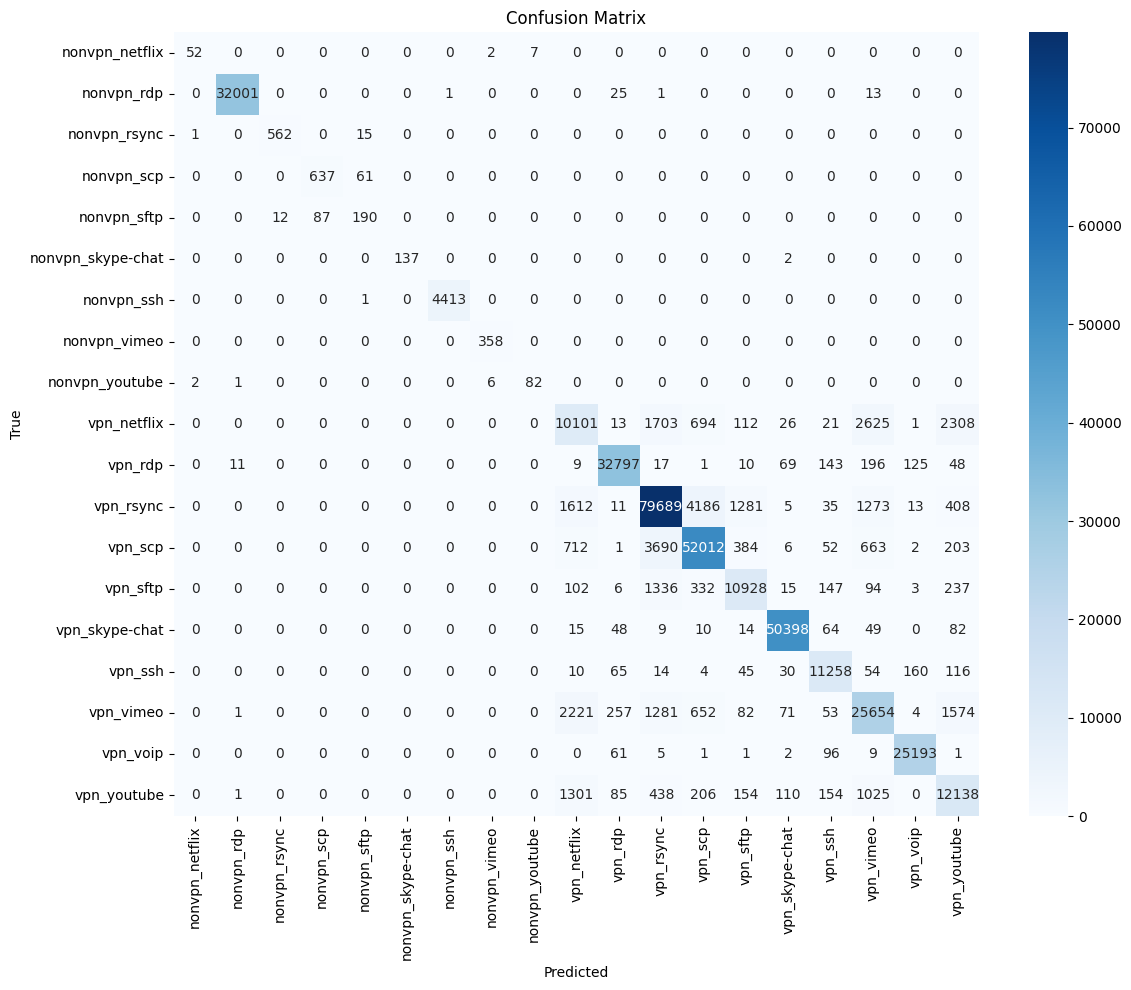

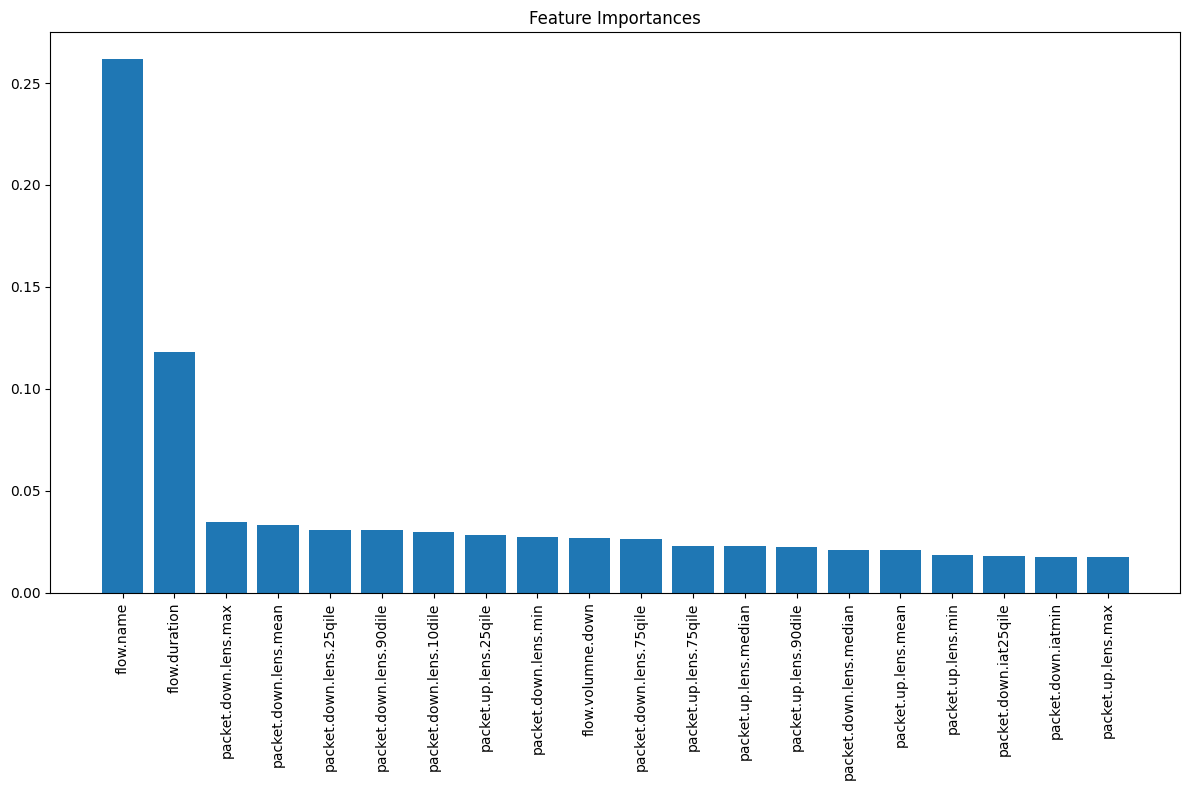

Model saved as 'vpn_traffic_random_forest_model.pkl'


In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '/content/drive/My Drive/COL867_Assignment2/data_own/'

# Function to extract class label from filename
def extract_class(filename):
    base = os.path.basename(filename).replace('.pkl', '')
    parts = base.split('_')
    vpn_status = parts[0]
    if len(parts) >= 3 and parts[1] == 'skype':
        app_type = 'skype-chat'
    else:
        app_type = parts[1]
    return f"{vpn_status}_{app_type}"

# Load all data files
all_files = glob.glob(os.path.join(data_path, '*.pkl'))
print(f"Found {len(all_files)} files")

# Initialize lists to store data and labels
all_data = []
all_labels = []

# Load data from each file
for file_path in all_files:
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Extract features from each flow in the file
        for i in range(len(data['flow.name'])):
            features = {}
            for key in data.keys():
                if key not in ['label.is_vpn', 'label.type']:
                    features[key] = data[key][i]

            all_data.append(features)

            # Use filename as the class label
            class_label = extract_class(file_path)
            all_labels.append(class_label)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

df = pd.DataFrame(all_data)

# Handle any potential non-numeric data
df = df.select_dtypes(include=[np.number])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df, all_labels, test_size=0.3, random_state=42, stratify=all_labels if len(set(all_labels)) > 1 else None
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of classes: {len(set(all_labels))}")

# Train Random Forest classifier
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred)
print(class_report)

# Generate confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(all_labels)),
            yticklabels=sorted(set(all_labels)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Feature importance
feature_importances = rf_model.feature_importances_
feature_names = df.columns

# Sort features by importance
indices = np.argsort(feature_importances)[::-1]

# Plot top 20 features
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(20), feature_importances[indices][:20], align='center')
plt.xticks(range(20), [feature_names[i] for i in indices][:20], rotation=90)
plt.tight_layout()
plt.show()

# Save the model
with open('vpn_traffic_random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Model saved as 'vpn_traffic_random_forest_model.pkl'")

### Tune Your Model
Perform hyperparameter tuning to find optimal parameters for your model.

In [ ]:
max_depth = list()
for tree in rf_model.estimators_:
    max_depth.append(tree.tree_.max_depth)

print("avg max depth %0.1f" % (sum(max_depth) / len(max_depth)))

avg max depth 52.8


Trying multiples of max depth

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9238


Trying out lesser number of estimators

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=75,
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9239


Trying out more things

In [3]:
import pandas as pd
import numpy as np
import pickle
import os
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from scipy.interpolate import interp1d

data_path = '/content/drive/My Drive/COL867_Assignment2/data_own/'

# Function to extract class label from filename
def extract_class(filename):
    base = os.path.basename(filename).replace('.pkl', '')
    parts = base.split('_')
    vpn_status = parts[0]
    if len(parts) >= 3 and parts[1] == 'skype':
        app_type = 'skype-chat'
    else:
        app_type = parts[1]
    return f"{vpn_status}_{app_type}"

# Load all data files
all_files = glob.glob(os.path.join(data_path, '*.pkl'))
print(f"Found {len(all_files)} files")

# Initialize lists to store data and labels
all_data = []
all_labels = []

# Load data from each file
for file_path in all_files:
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Extract features from each flow in the file
        for i in range(len(data['flow.name'])):
            features = {}
            for key in data.keys():
                if key not in ['label.is_vpn', 'label.type']:
                    features[key] = data[key][i]

            all_data.append(features)

            # Use filename as the class label
            class_label = extract_class(file_path)
            all_labels.append(class_label)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

df = pd.DataFrame(all_data)

# Handle any potential non-numeric data
df = df.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(
    df, all_labels, test_size=0.3, random_state=42, stratify=all_labels if len(set(all_labels)) > 1 else None
)

# # 🧪 Sample a smaller portion of training data to handle space constraints
# X_sampled, _, y_sampled, _ = train_test_split(
#     X_train, y_train, train_size=0.65, random_state=42, stratify=y_train
# )

Found 161 files


In [ ]:
# 🧪 Sample a smaller portion of training data to handle space constraints
X_sampled, _, y_sampled, _ = train_test_split(
    X_train, y_train, train_size=0.8, random_state=42, stratify=y_train
)

print("Encoding labels...")
le = LabelEncoder()
encoded_labels = le.fit_transform(all_labels)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of classes: {len(set(encoded_labels))}")

print(f"Sampled training set size: {len(X_sampled)}")

# Grid search on sampled data
small_param_grid = {
    'n_estimators': [50, 60],
    'max_depth': [10, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

print("Running GridSearchCV with small parameter grid on sampled data...")
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, small_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_sampled, y_sampled)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# Evaluate on test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Encoding labels...
Training set size: 1175898
Test set size: 503957
Number of classes: 19
Sampled training set size: 940718
Running GridSearchCV with small parameter grid on sampled data...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}
Best CV score: 0.8962324516528964
Test Accuracy: 0.8967


Note that our accuracy reduced as we trained on the complete set of files. Initially accuracy was more than 90%

### Evaluate Your Model

**Checkpoint**: Evaluate your model accuracy according to the following metrics using 10-fold cross validation:

- Accuracy
- F1 Score
- Confusion Matrix
- ROC/AUC

Your code should evaluate these metrics in separate cells

In [5]:
# 🧪 Sample a smaller portion of training data to handle space constraints
X_sampled, _, y_sampled, _ = train_test_split(
    X_train, y_train, train_size=10000, random_state=42, stratify=y_train
)

print("Encoding labels...")
le = LabelEncoder()
encoded_labels = le.fit_transform(all_labels)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of classes: {len(set(encoded_labels))}")

print(f"Sampled training set size: {len(X_sampled)}")

# Grid search on sampled data
small_param_grid = {
    'n_estimators': [60],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, small_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_sampled, y_sampled)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Encoding labels...
Training set size: 1175898
Test set size: 503957
Number of classes: 19
Sampled training set size: 10000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Test Accuracy: 0.8357



Classification Report:
                   precision    recall  f1-score   support

   nonvpn_netflix       0.40      0.07      0.11        61
       nonvpn_rdp       1.00      0.98      0.99     32041
     nonvpn_rsync       0.76      0.89      0.82       578
       nonvpn_scp       0.76      0.78      0.77       698
      nonvpn_sftp       0.47      0.29      0.36       289
nonvpn_skype-chat       0.91      0.50      0.64       139
       nonvpn_ssh       0.99      1.00      0.99      4414
     nonvpn_vimeo       0.81      0.84      0.83       358
   nonvpn_youtube       0.69      0.42      0.52        91
      vpn_netflix       0.42      0.33      0.37     17604
          vpn_rdp       0.94      0.95      0.94     33426
        vpn_rsync       0.77      0.70      0.73     88513
          vpn_scp       0.85      0.90      0.87    177269
         vpn_sftp       0.75      0.74      0.74     13200
   vpn_skype-chat       0.98      0.97      0.98     50689
          vpn_ssh       0.81   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classifi


10-fold Cross-Validation Results:
accuracy: 0.8353 ± 0.0073
f1_weighted: 0.8314 ± 0.0073
precision: 0.8310 ± 0.0077
recall: 0.8353 ± 0.0073

Generating confusion matrices from cross-validation...


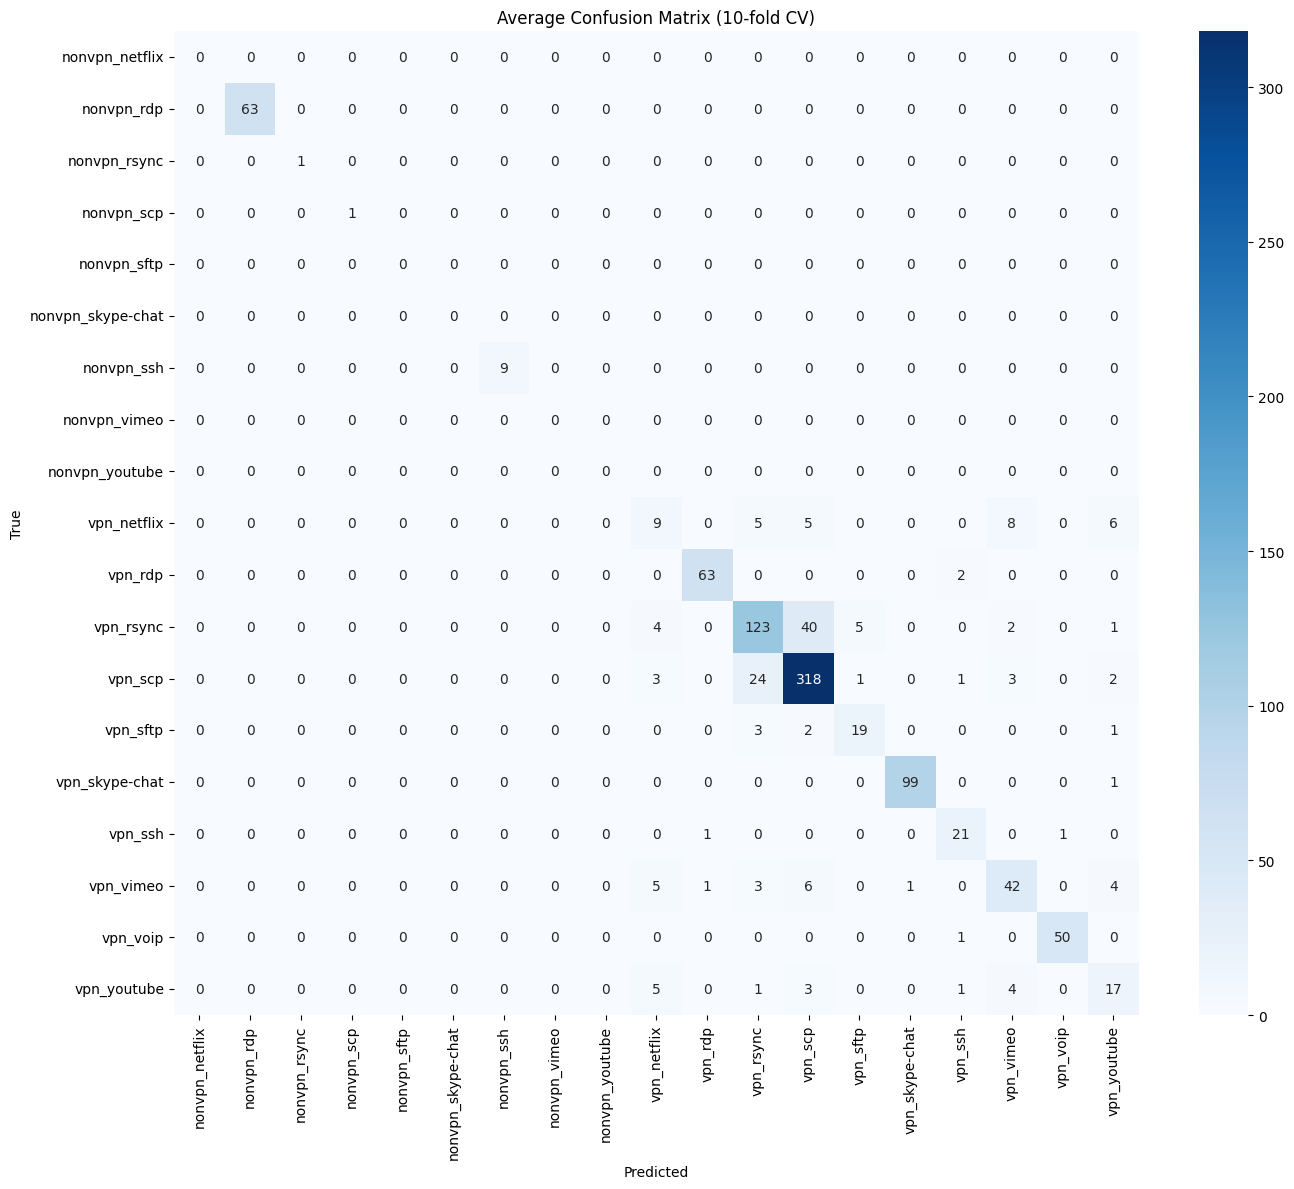

Average F1 Score (CV): 0.8314
Average Accuracy (CV): 0.8353


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ran

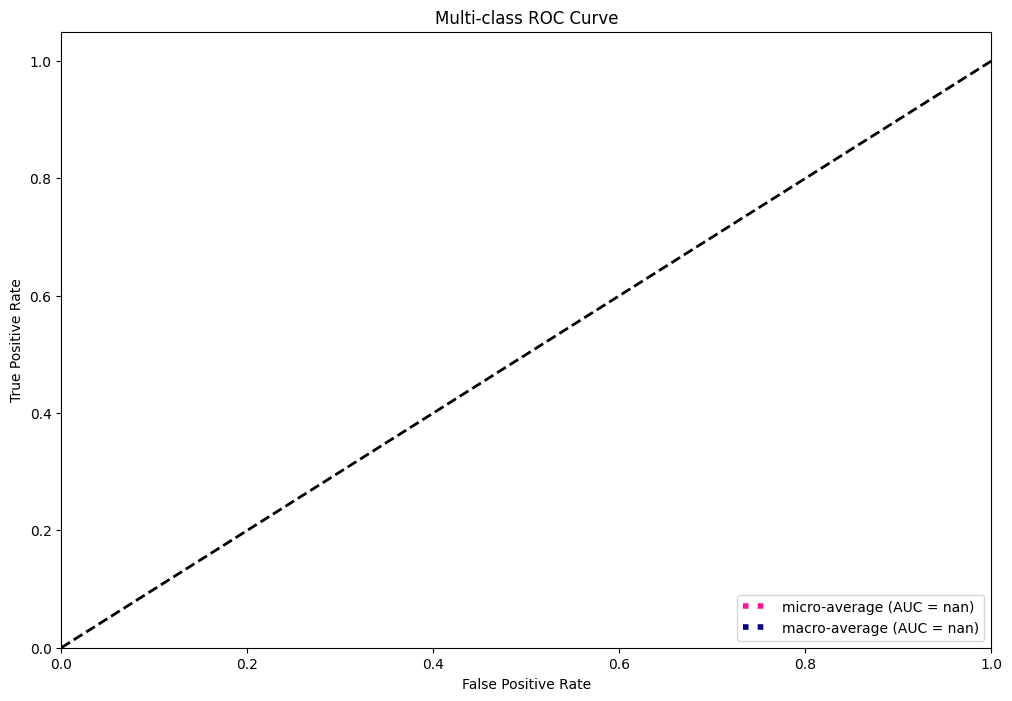

Model saved as 'improved_vpn_traffic_rf_model.pkl'


In [10]:
# Print classification report
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, target_names=le.classes_)
print(class_report)

# Define 10-fold cross-validation
print("\nPerforming 10-fold cross-validation...")
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Metrics to evaluate
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted'
}

# Get cross-validation results
cv_results = cross_validate(best_rf, X_sampled, y_sampled, cv=cv, scoring=scoring)

# Print cross-validation metrics
print("\n10-fold Cross-Validation Results:")
for metric, scores in cv_results.items():
    if metric.startswith('test_'):
        print(f"{metric.replace('test_', '')}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Generate confusion matrix from 10-fold CV
conf_matrices = []
f1_scores = []
accuracies = []

y_sampled = pd.Series(y_sampled)

print("\nGenerating confusion matrices from cross-validation...")
for train_idx, test_idx in cv.split(X_sampled):
    X_cv_train, X_cv_test = X_sampled.iloc[train_idx], X_sampled.iloc[test_idx]
    y_cv_train, y_cv_test = y_sampled.iloc[train_idx], y_sampled.iloc[test_idx]

    best_rf.fit(X_cv_train, y_cv_train)
    y_cv_pred = best_rf.predict(X_cv_test)

    # Metrics
    conf_matrices.append(confusion_matrix(y_cv_test, y_cv_pred, labels=le.classes_))
    f1_scores.append(f1_score(y_cv_test, y_cv_pred, average='weighted'))
    accuracies.append(accuracy_score(y_cv_test, y_cv_pred))


# Average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_conf_matrix = np.round(avg_conf_matrix).astype(int)

# Plot average confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (10-fold CV)')
plt.tight_layout()
plt.show()

print(f"Average F1 Score (CV): {np.mean(f1_scores):.4f}")
print(f"Average Accuracy (CV): {np.mean(accuracies):.4f}")

# Calculate and plot ROC curves for multi-class
n_classes = len(le.classes_)

# Binarize the labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=np.unique(encoded_labels))
y_score = best_rf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    if i < y_test_bin.shape[1]:  # Check if we have this class in the test set
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if i in fpr]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    if i in fpr:
        # Updated usage of interp1d:
        f = interp1d(fpr[i], tpr[i])
        mean_tpr += f(all_fpr)

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(12, 8))

# Plot micro-average and macro-average ROC curves
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Save the final model
with open('improved_vpn_traffic_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

print("Model saved as 'improved_vpn_traffic_rf_model.pkl'")

The current model shows:

Overall accuracy of 84% (from cross-validation)
Weighted F1 score of 83%
Strong performance for some classes (nonvpn_rdp, nonvpn_ssh, vpn_voip) with F1 scores > 0.98
Poor performance for several classes:
1. nonvpn_netflix (F1: 0.11)
2. nonvpn_sftp (F1: 0.36)
3. vpn_netflix (F1: 0.37)
4. nonvpn_youtube (F1: 0.52)
5. vpn_youtube (F1: 0.57)

The most critical issue is class imbalance. Some classes like nonvpn_netflix (61 samples) have very few examples compared to vpn_scp (177,269 samples).

####Attempt 1

Encoding labels...
Training set size: 1175898
Test set size: 503957
Number of classes: 19
Sampled training set size: 20000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Test Accuracy: 0.8391

Classification Report:
                   precision    recall  f1-score   support

   nonvpn_netflix       0.37      0.11      0.17        61
       nonvpn_rdp       1.00      0.99      0.99     32041
     nonvpn_rsync       0.72      0.90      0.80       578
       nonvpn_scp       0.76      0.78      0.77       698
      nonvpn_sftp       0.52      0.29      0.37       289
nonvpn_skype-chat       0.95      0.75      0.84       139
       nonvpn_ssh       0.99      1.00      1.00      4414
     nonvpn_vimeo       0.84      0.94      0.89       358
   nonvpn_youtube       0.65      0.56      0.60        91
      vpn_netflix       0.40      0.49      0.44     17604
          vpn_rdp       0.95      0.96      0.95     33426
        vpn_rsync       0.78      0.71      0.74     88513
          vpn_scp       0.89      0.86      0.87    177269
         vpn_sftp       0.70      0.84      0.76     13200
   vpn_skype-chat       0.98      0.98      0.98     50689
         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_


10-fold Cross-Validation Results:
accuracy: 0.8405 ± 0.0098
f1_weighted: 0.8433 ± 0.0102
precision: 0.8496 ± 0.0107
recall: 0.8405 ± 0.0098

Generating confusion matrices from cross-validation...


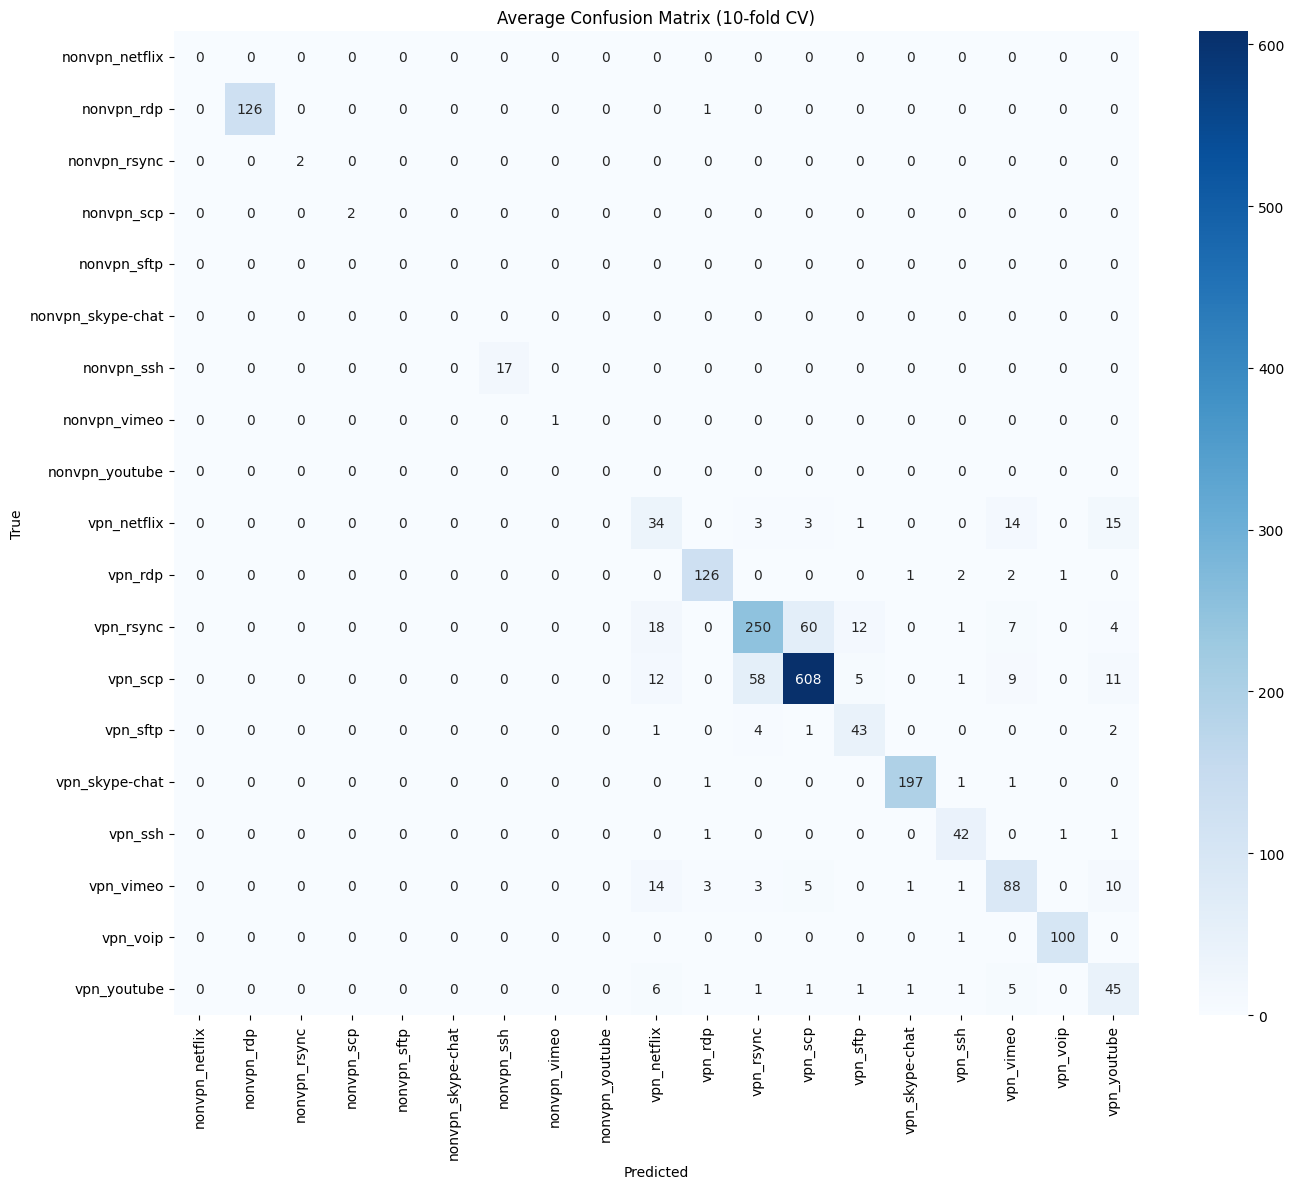

Average F1 Score (CV): 0.8433
Average Accuracy (CV): 0.8405


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ran

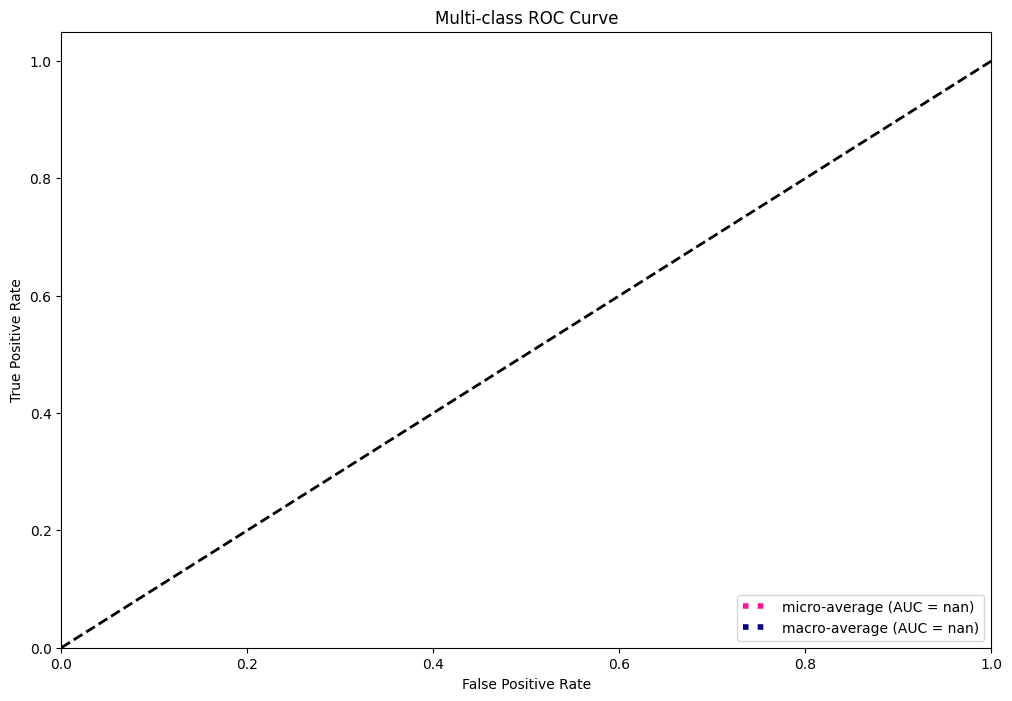

Model saved as 'improved_vpn_traffic_rf_model.pkl'


In [6]:
# 🧪 Sample a smaller portion of training data to handle space constraints
X_sampled, _, y_sampled, _ = train_test_split(
    X_train, y_train, train_size=20000, random_state=42, stratify=y_train
)

print("Encoding labels...")
le = LabelEncoder()
encoded_labels = le.fit_transform(all_labels)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of classes: {len(set(encoded_labels))}")

print(f"Sampled training set size: {len(X_sampled)}")

# Grid search on sampled data
small_param_grid = {
    'n_estimators': [60],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, small_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_sampled, y_sampled)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, target_names=le.classes_)
print(class_report)

# Define 10-fold cross-validation
print("\nPerforming 10-fold cross-validation...")
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Metrics to evaluate
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted'
}

# Get cross-validation results
cv_results = cross_validate(best_rf, X_sampled, y_sampled, cv=cv, scoring=scoring)

# Print cross-validation metrics
print("\n10-fold Cross-Validation Results:")
for metric, scores in cv_results.items():
    if metric.startswith('test_'):
        print(f"{metric.replace('test_', '')}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Generate confusion matrix from 10-fold CV
conf_matrices = []
f1_scores = []
accuracies = []

y_sampled = pd.Series(y_sampled)

print("\nGenerating confusion matrices from cross-validation...")
for train_idx, test_idx in cv.split(X_sampled):
    X_cv_train, X_cv_test = X_sampled.iloc[train_idx], X_sampled.iloc[test_idx]
    y_cv_train, y_cv_test = y_sampled.iloc[train_idx], y_sampled.iloc[test_idx]

    best_rf.fit(X_cv_train, y_cv_train)
    y_cv_pred = best_rf.predict(X_cv_test)

    # Metrics
    conf_matrices.append(confusion_matrix(y_cv_test, y_cv_pred, labels=le.classes_))
    f1_scores.append(f1_score(y_cv_test, y_cv_pred, average='weighted'))
    accuracies.append(accuracy_score(y_cv_test, y_cv_pred))


# Average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_conf_matrix = np.round(avg_conf_matrix).astype(int)

# Plot average confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (10-fold CV)')
plt.tight_layout()
plt.show()

print(f"Average F1 Score (CV): {np.mean(f1_scores):.4f}")
print(f"Average Accuracy (CV): {np.mean(accuracies):.4f}")

# Calculate and plot ROC curves for multi-class
n_classes = len(le.classes_)

# Binarize the labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=np.unique(encoded_labels))
y_score = best_rf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    if i < y_test_bin.shape[1]:  # Check if we have this class in the test set
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if i in fpr]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    if i in fpr:
        # Updated usage of interp1d:
        f = interp1d(fpr[i], tpr[i])
        mean_tpr += f(all_fpr)

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(12, 8))

# Plot micro-average and macro-average ROC curves
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Save the final model
with open('improved_vpn_traffic_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

print("Model saved as 'improved_vpn_traffic_rf_model.pkl'")

####Attempt 2

Encoding labels...
Training set size: 1175898
Test set size: 503957
Number of classes: 19

Analyzing class distribution...
Smallest class has 143 samples

Preparing SMOTE with memory-efficient settings...

Initializing RandomForest with specified parameters...

Applying SMOTE for class balancing...
Successfully resampled data: (1177066, 42)

Class distribution after resampling (top 5 and bottom 5):
vpn_scp           413628
vpn_rsync         206531
vpn_skype-chat    118273
vpn_rdp            77994
nonvpn_rdp         74761
Name: count, dtype: int64
nonvpn_vimeo         1000
nonvpn_sftp          1000
nonvpn_skype-chat     646
nonvpn_youtube        426
nonvpn_netflix        286
Name: count, dtype: int64

Training model on resampled data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.0min finished



Evaluating model on test set...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_job


Test Accuracy: 0.8720

Classification Report:
                   precision    recall  f1-score   support

   nonvpn_netflix       0.93      0.87      0.90        61
       nonvpn_rdp       1.00      1.00      1.00     32041
     nonvpn_rsync       0.98      0.97      0.97       578
       nonvpn_scp       0.89      0.88      0.89       698
      nonvpn_sftp       0.67      0.71      0.69       289
nonvpn_skype-chat       0.99      0.99      0.99       139
       nonvpn_ssh       1.00      1.00      1.00      4414
     nonvpn_vimeo       0.98      1.00      0.99       358
   nonvpn_youtube       0.93      0.91      0.92        91
      vpn_netflix       0.45      0.68      0.54     17604
          vpn_rdp       0.98      0.97      0.98     33426
        vpn_rsync       0.82      0.78      0.80     88513
          vpn_scp       0.95      0.85      0.90    177269
         vpn_sftp       0.69      0.94      0.79     13200
   vpn_skype-chat       0.99      0.99      0.99     50689
        

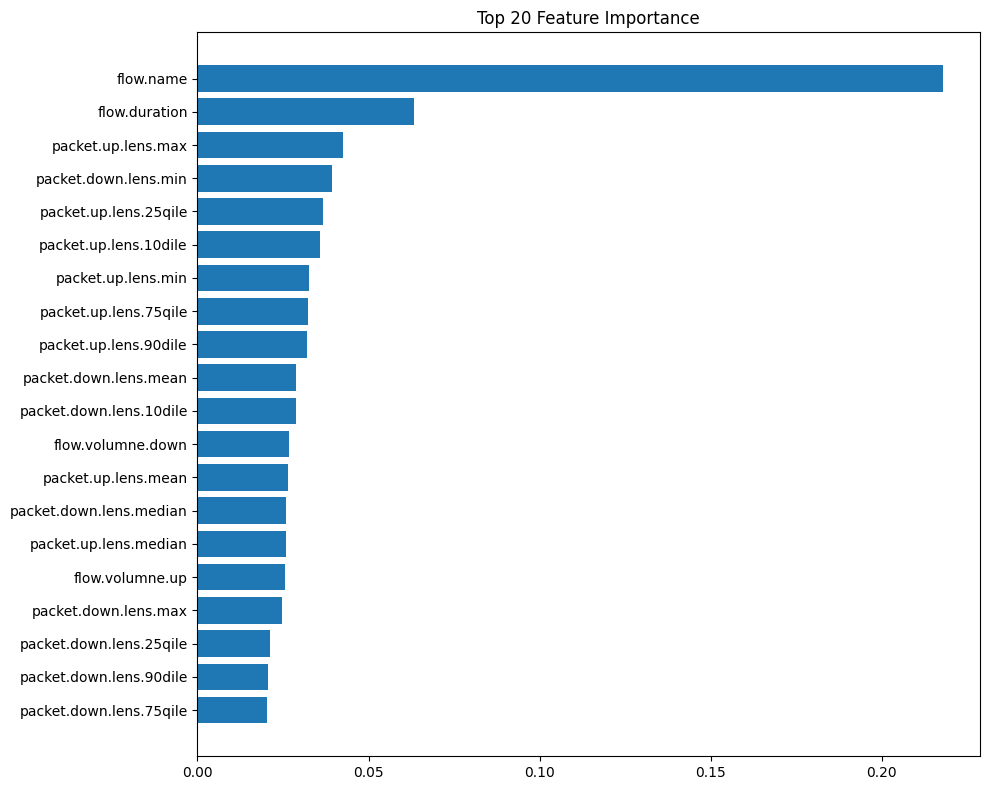

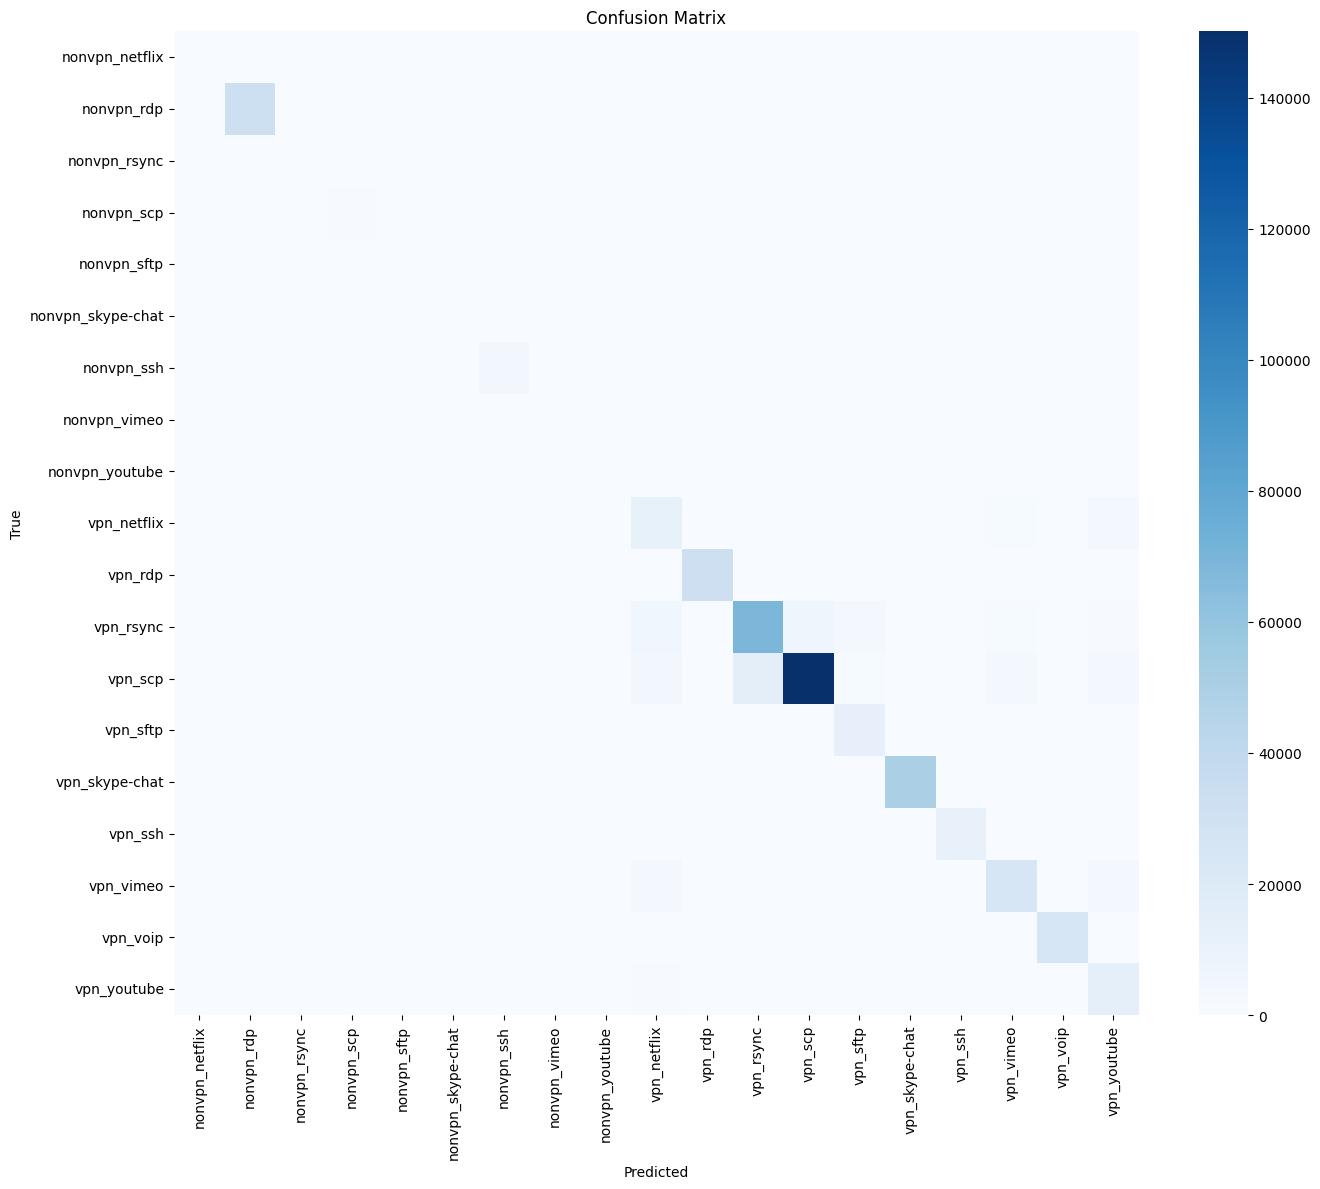

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from scipy.interpolate import interp1d
from imblearn.over_sampling import SMOTE
import pickle
import gc  # For explicit garbage collection
import warnings
warnings.filterwarnings("ignore")

# Assuming X_train, X_test, y_train, y_test, all_labels are already defined

print("Encoding labels...")
le = LabelEncoder()
encoded_labels = le.fit_transform(all_labels)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of classes: {len(set(encoded_labels))}")

# Calculate class distribution
print("\nAnalyzing class distribution...")
class_counts = pd.Series(y_train).value_counts()
min_samples = class_counts.min()
print(f"Smallest class has {min_samples} samples")

# Memory-efficient SMOTE setup
print("\nPreparing SMOTE with memory-efficient settings...")
# Only oversample classes with fewer than 1000 samples to reduce memory usage
sampling_strategy = {cls: min(1000, max(100, count*2))
                     for cls, count in class_counts.items() if count < 1000}

smote = SMOTE(random_state=42,
              sampling_strategy=sampling_strategy,
              k_neighbors=min(5, min_samples-1))  # Ensure k is less than min class samples

# Use your specified parameters directly
print("\nInitializing RandomForest with specified parameters...")
best_rf = RandomForestClassifier(
    n_estimators=100,           # Moderate number for balance of performance and speed
    max_depth=20,               # Control overfitting
    min_samples_split=2,        # Default value
    min_samples_leaf=1,         # Default value
    max_features='sqrt',        # Good for reducing memory usage
    class_weight='balanced',    # Handle class imbalance
    random_state=42,
    n_jobs=-1,                  # Use all cores
    verbose=1                   # Show progress
)

# Process in smaller chunks if needed
print("\nApplying SMOTE for class balancing...")
try:
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"Successfully resampled data: {X_train_resampled.shape}")
except MemoryError:
    print("MemoryError encountered. Trying with reduced dataset...")
    # If memory error, sample a portion of the data stratified by class
    X_reduced, _, y_reduced, _ = train_test_split(
        X_train, y_train, train_size=0.5, random_state=42, stratify=y_train
    )
    X_train_resampled, y_train_resampled = smote.fit_resample(X_reduced, y_reduced)
    print(f"Using reduced dataset after resampling: {X_train_resampled.shape}")

# Display resampled class distribution
resampled_counts = pd.Series(y_train_resampled).value_counts()
print("\nClass distribution after resampling (top 5 and bottom 5):")
print(resampled_counts.head())
print(resampled_counts.tail())

# Train model - with progress information
print("\nTraining model on resampled data...")
best_rf.fit(X_train_resampled, y_train_resampled)

# Free up memory
del X_train_resampled
gc.collect()

# Evaluate on test set - doing this in batches if needed
print("\nEvaluating model on test set...")
batch_size = 10000  # Adjust based on available memory
if len(X_test) > batch_size:
    # Process in batches to avoid memory issues
    y_pred = np.zeros(len(X_test), dtype=object)
    for i in range(0, len(X_test), batch_size):
        end = min(i + batch_size, len(X_test))
        y_pred[i:end] = best_rf.predict(X_test[i:end])
else:
    y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, target_names=le.classes_)
print(class_report)

# Save classification report to file
with open('classification_report.txt', 'w') as f:
    f.write(class_report)
print("Classification report saved to 'classification_report.txt'")

# Feature importance analysis - top 20 only to save memory
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

# Sort features by importance and get top 20
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-20:]  # Get top 20 indices

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')

# Confusion matrix - simplified to avoid memory issues
print("\nGenerating confusion matrix...")
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
# Plot as heatmap but without annotations to save memory
sns.heatmap(conf_matrix, cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

# Class-specific performance
print("\nPer-class F1 Scores:")
per_class_f1 = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
problematic_classes = []

for cls, metrics in per_class_f1.items():
    if cls not in ['accuracy', 'macro avg', 'weighted avg']:
        f1 = metrics['f1-score']
        if f1 < 0.7:  # Flag classes with poor performance
            problematic_classes.append(cls)
            print(f"{cls}: {f1:.4f} (*)") # Mark problematic classes
        else:
            print(f"{cls}: {f1:.4f}")

print("\nProblematic classes that need attention:")
for cls in problematic_classes:
    print(f"- {cls}")

# Save the final model
with open('improved_vpn_traffic_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

print("Model saved as 'improved_vpn_traffic_rf_model.pkl'")

Loading the trained model...
Preparing for ROC curve calculation...
Number of classes: 19
Binarizing test labels...
Calculating ROC curves in batches...
Processing batch 1/101 (samples 0 to 5000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 2/101 (samples 5000 to 10000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 3/101 (samples 10000 to 15000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 4/101 (samples 15000 to 20000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 5/101 (samples 20000 to 25000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 6/101 (samples 25000 to 30000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 7/101 (samples 30000 to 35000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 8/101 (samples 35000 to 40000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 9/101 (samples 40000 to 45000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 10/101 (samples 45000 to 50000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 11/101 (samples 50000 to 55000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 12/101 (samples 55000 to 60000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 13/101 (samples 60000 to 65000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 14/101 (samples 65000 to 70000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


Processing batch 15/101 (samples 70000 to 75000)...


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 16/101 (samples 75000 to 80000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 17/101 (samples 80000 to 85000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 18/101 (samples 85000 to 90000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 19/101 (samples 90000 to 95000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 20/101 (samples 95000 to 100000)...
Processing batch 21/101 (samples 100000 to 105000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 22/101 (samples 105000 to 110000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 23/101 (samples 110000 to 115000)...
Processing batch 24/101 (samples 115000 to 120000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 25/101 (samples 120000 to 125000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 26/101 (samples 125000 to 130000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 27/101 (samples 130000 to 135000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Processing batch 28/101 (samples 135000 to 140000)...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 29/101 (samples 140000 to 145000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 30/101 (samples 145000 to 150000)...
Processing batch 31/101 (samples 150000 to 155000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 32/101 (samples 155000 to 160000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 33/101 (samples 160000 to 165000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 34/101 (samples 165000 to 170000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 35/101 (samples 170000 to 175000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 36/101 (samples 175000 to 180000)...
Processing batch 37/101 (samples 180000 to 185000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 38/101 (samples 185000 to 190000)...
Processing batch 39/101 (samples 190000 to 195000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 40/101 (samples 195000 to 200000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 41/101 (samples 200000 to 205000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 42/101 (samples 205000 to 210000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 43/101 (samples 210000 to 215000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 44/101 (samples 215000 to 220000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 45/101 (samples 220000 to 225000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 46/101 (samples 225000 to 230000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 47/101 (samples 230000 to 235000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 48/101 (samples 235000 to 240000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 49/101 (samples 240000 to 245000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 50/101 (samples 245000 to 250000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


Processing batch 51/101 (samples 250000 to 255000)...


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 52/101 (samples 255000 to 260000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 53/101 (samples 260000 to 265000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 54/101 (samples 265000 to 270000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 55/101 (samples 270000 to 275000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 56/101 (samples 275000 to 280000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 57/101 (samples 280000 to 285000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 58/101 (samples 285000 to 290000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 59/101 (samples 290000 to 295000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 60/101 (samples 295000 to 300000)...
Processing batch 61/101 (samples 300000 to 305000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 62/101 (samples 305000 to 310000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 63/101 (samples 310000 to 315000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 64/101 (samples 315000 to 320000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 65/101 (samples 320000 to 325000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 66/101 (samples 325000 to 330000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 67/101 (samples 330000 to 335000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 68/101 (samples 335000 to 340000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 69/101 (samples 340000 to 345000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 70/101 (samples 345000 to 350000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 71/101 (samples 350000 to 355000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 72/101 (samples 355000 to 360000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 73/101 (samples 360000 to 365000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 74/101 (samples 365000 to 370000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 75/101 (samples 370000 to 375000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Processing batch 76/101 (samples 375000 to 380000)...
Processing batch 77/101 (samples 380000 to 385000)...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 78/101 (samples 385000 to 390000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 79/101 (samples 390000 to 395000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 80/101 (samples 395000 to 400000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 81/101 (samples 400000 to 405000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 82/101 (samples 405000 to 410000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 83/101 (samples 410000 to 415000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 84/101 (samples 415000 to 420000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 85/101 (samples 420000 to 425000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 86/101 (samples 425000 to 430000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 87/101 (samples 430000 to 435000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 88/101 (samples 435000 to 440000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Processing batch 89/101 (samples 440000 to 445000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 90/101 (samples 445000 to 450000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 91/101 (samples 450000 to 455000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 92/101 (samples 455000 to 460000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 93/101 (samples 460000 to 465000)...
Processing batch 94/101 (samples 465000 to 470000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 95/101 (samples 470000 to 475000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 96/101 (samples 475000 to 480000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 97/101 (samples 480000 to 485000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 98/101 (samples 485000 to 490000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 99/101 (samples 490000 to 495000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Processing batch 100/101 (samples 495000 to 500000)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Processing batch 101/101 (samples 500000 to 503957)...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Computing ROC curves for each class...
Class 1/19: nonvpn_netflix
Class 2/19: nonvpn_rdp
Class 3/19: nonvpn_rsync
Class 4/19: nonvpn_scp
Class 5/19: nonvpn_sftp
Class 6/19: nonvpn_skype-chat
Class 7/19: nonvpn_ssh
Class 8/19: nonvpn_vimeo
Class 9/19: nonvpn_youtube
Class 10/19: vpn_netflix
Class 11/19: vpn_rdp
Class 12/19: vpn_rsync
Class 13/19: vpn_scp
Class 14/19: vpn_sftp
Class 15/19: vpn_skype-chat
Class 16/19: vpn_ssh
Class 17/19: vpn_vimeo
Class 18/19: vpn_voip
Class 19/19: vpn_youtube
Computing micro-average ROC...
Computing macro-average ROC...
Plotting ROC curves...
Saving ROC data...
Done! ROC curves saved as 'roc_curve_macro_micro.png' and possibly 'roc_curve_problematic_classes.png'
ROC data saved as 'roc_curve_data.pkl'


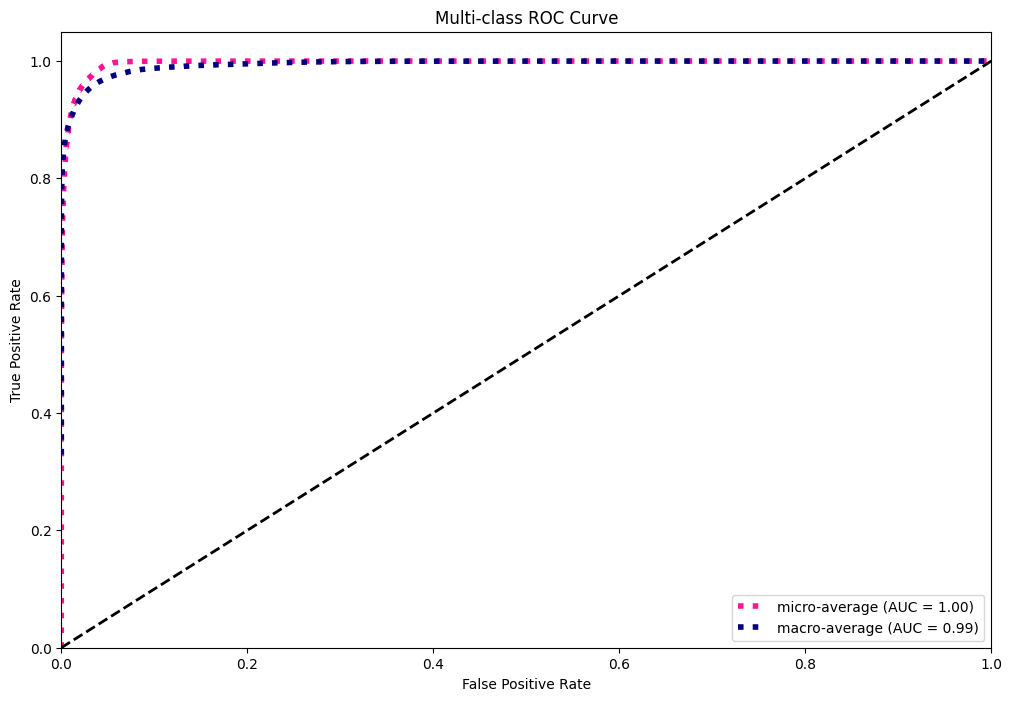

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pickle
import gc  # For garbage collection
import warnings
warnings.filterwarnings("ignore")

# Load the trained model
print("Loading the trained model...")
with open('improved_vpn_traffic_rf_model.pkl', 'rb') as f:
    model = pickle.load(f)

# This script assumes X_test and y_test are available
# If they're not in memory, uncomment and modify these lines to load them:
# X_test = pd.read_csv('X_test.csv')  # or your data loading method
# y_test = pd.read_csv('y_test.csv').values.ravel()  # or your data loading method

# Get unique classes
print("Preparing for ROC curve calculation...")
classes = model.classes_
n_classes = len(classes)
print(f"Number of classes: {n_classes}")

# Binarize the labels for ROC curve calculation
print("Binarizing test labels...")
y_test_bin = label_binarize(y_test, classes=classes)

# Calculate ROC curves in batches to save memory
print("Calculating ROC curves in batches...")
batch_size = 5000  # Adjust based on available memory
n_batches = int(np.ceil(len(X_test) / batch_size))

# Initialize storage for false positive rate, true positive rate and AUC
fpr = {}
tpr = {}
roc_auc = {}
y_score_all = np.zeros((len(X_test), n_classes))

# Process test data in batches
for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_test))
    print(f"Processing batch {i+1}/{n_batches} (samples {start_idx} to {end_idx})...")

    # Get probability predictions for this batch
    X_batch = X_test[start_idx:end_idx]
    y_score_batch = model.predict_proba(X_batch)
    y_score_all[start_idx:end_idx] = y_score_batch

    # Free memory
    del X_batch, y_score_batch
    gc.collect()

# Calculate ROC for each class
print("Computing ROC curves for each class...")
for i in range(n_classes):
    print(f"Class {i+1}/{n_classes}: {classes[i]}")
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
print("Computing micro-average ROC...")
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
print("Computing macro-average ROC...")
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    f = interp1d(fpr[i], tpr[i])
    mean_tpr += f(all_fpr)

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot macro and micro ROC curves
print("Plotting ROC curves...")
plt.figure(figsize=(12, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_macro_micro.png')

# Optionally plot ROC curves for problematic classes
# First identify classes with low AUC
low_auc_classes = [i for i in range(n_classes) if roc_auc[i] < 0.8]
if low_auc_classes:
    print(f"Plotting separate ROC curves for {len(low_auc_classes)} problematic classes...")
    plt.figure(figsize=(12, 8))

    for i in low_auc_classes:
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Problematic Classes')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve_problematic_classes.png')

# Save ROC data for future reference
print("Saving ROC data...")
roc_data = {
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc,
    'classes': classes
}
with open('roc_curve_data.pkl', 'wb') as f:
    pickle.dump(roc_data, f)

print("Done! ROC curves saved as 'roc_curve_macro_micro.png' and possibly 'roc_curve_problematic_classes.png'")
print("ROC data saved as 'roc_curve_data.pkl'")

## Part 3: Comparison with a deep learning-based model

In this part, you will compare your model with the DeepPacket model in terms of accuracy, explainability, and system cost. You can download a pre-trained DeepPacket model (pre-trained on the same dataset) using this [link](https://github.com/munhouiani/Deep-Packet). There is also featurized data available on the same link which you can use directly.  

Specifically, you should compare your trained model with the DeepPacket model in the following terms:
- **Accuracy**: Compare the accuracy of the two models. Are there classes where one model is doing significantly better than the other?
- **Explainability**: conduct an explainability analysis of the two models. For instance, you could do a simple feature importance analysis if you are using decision tree for the first model. For DeepPacket, please use TRUSTEE to figure out the most important features and check which part of the packet (payload, TCP, TCP options etc.) do these correspond.
- **System cost**: Analyze the runtime complexity of the model. Do this only for testing and NOT training.


###Running the code provided by Deep packet to evaluate the model on their featurized dataset

###Initialisation

In [7]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [8]:
!pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.6 MB/s eta 0:00:00


In [9]:
!pip install pytorch-lightning==1.8.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.4/800.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
from pathlib import Path
import multiprocessing
import datasets
import torch
from pytorch_lightning import LightningModule
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import numpy as np
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing
from pathlib import Path
import datasets
import numpy as np
import torch
import pandas as pd
from torch.nn import functional as F
from torch.utils.data import DataLoader
from pathlib import Path
from scapy.layers.dns import DNS
from scapy.layers.inet import TCP
from scapy.packet import Padding
from scapy.utils import PcapReader

###Pre-defined Deep Packet Functions

In [15]:
def train_cnn(
    c1_kernel_size,
    c1_output_dim,
    c1_stride,
    c2_kernel_size,
    c2_output_dim,
    c2_stride,
    output_dim,
    data_path,
    epoch,
    model_path,
    signal_length,
    logger,
):
    # prepare dir for model path
    if model_path:
        model_path = Path(model_path)
        model_path.parent.mkdir(parents=True, exist_ok=True)

    # seed everything
    seed_everything(seed=9876, workers=True)

    model = CNN(
        c1_kernel_size=c1_kernel_size,
        c1_output_dim=c1_output_dim,
        c1_stride=c1_stride,
        c2_kernel_size=c2_kernel_size,
        c2_output_dim=c2_output_dim,
        c2_stride=c2_stride,
        output_dim=output_dim,
        data_path=data_path,
        signal_length=signal_length,
    ).float()
    trainer = Trainer(
        val_check_interval=1.0,
        max_epochs=epoch,
        devices="auto",
        accelerator="auto",
        logger=logger,
        callbacks=[
            EarlyStopping(
                monitor="training_loss", mode="min", check_on_train_epoch_end=True
            )
        ],
    )
    trainer.fit(model)

    # save model
    trainer.save_checkpoint(str(model_path.absolute()))


def train_resnet(
    c1_kernel_size,
    c1_output_dim,
    c1_stride,
    c1_groups,
    c1_n_block,
    output_dim,
    data_path,
    epoch,
    model_path,
    signal_length,
    logger,
):
    # prepare dir for model path
    if model_path:
        model_path = Path(model_path)
        model_path.parent.mkdir(parents=True, exist_ok=True)

    # seed everything
    seed_everything(seed=9876, workers=True)

    model = ResNet(
        c1_kernel_size=c1_kernel_size,
        c1_output_dim=c1_output_dim,
        c1_stride=c1_stride,
        c1_groups=c1_groups,
        c1_n_block=c1_n_block,
        output_dim=output_dim,
        data_path=data_path,
        signal_length=signal_length,
    ).float()
    trainer = Trainer(
        val_check_interval=1.0,
        max_epochs=epoch,
        devices="auto",
        accelerator="auto",
        logger=logger,
        callbacks=[
            EarlyStopping(
                monitor="training_loss", mode="min", check_on_train_epoch_end=True
            )
        ],
    )
    trainer.fit(model)

    # save model
    trainer.save_checkpoint(str(model_path.absolute()))


def train_application_classification_cnn_model(data_path, model_path):
    logger = TensorBoardLogger(
        "application_classification_cnn_logs", "application_classification_cnn"
    )
    train_cnn(
        c1_kernel_size=4,
        c1_output_dim=200,
        c1_stride=3,
        c2_kernel_size=5,
        c2_output_dim=200,
        c2_stride=1,
        output_dim=17,
        data_path=data_path,
        epoch=20,
        model_path=model_path,
        signal_length=1500,
        logger=logger,
    )


def train_application_classification_resnet_model(data_path, model_path):
    logger = TensorBoardLogger(
        "application_classification_resnet_logs", "application_classification_resnet"
    )
    train_resnet(
        c1_kernel_size=4,
        c1_output_dim=16,
        c1_stride=3,
        c1_groups=1,
        c1_n_block=4,
        output_dim=17,
        data_path=data_path,
        epoch=40,
        model_path=model_path,
        signal_length=1500,
        logger=logger,
    )


def train_traffic_classification_cnn_model(data_path, model_path):
    logger = TensorBoardLogger(
        "traffic_classification_cnn_logs", "traffic_classification_cnn"
    )
    train_cnn(
        c1_kernel_size=5,
        c1_output_dim=200,
        c1_stride=3,
        c2_kernel_size=4,
        c2_output_dim=200,
        c2_stride=3,
        output_dim=12,
        data_path=data_path,
        epoch=20,
        model_path=model_path,
        signal_length=1500,
        logger=logger,
    )


def train_traffic_classification_resnet_model(data_path, model_path):
    logger = TensorBoardLogger(
        "traffic_classification_resnet_logs", "traffic_classification_resnet"
    )
    train_resnet(
        c1_kernel_size=5,
        c1_output_dim=16,
        c1_stride=3,
        c1_groups=1,
        c1_n_block=4,
        output_dim=12,
        data_path=data_path,
        epoch=40,
        model_path=model_path,
        signal_length=1500,
        logger=logger,
    )


def load_cnn_model(model_path, gpu):
    if gpu:
        device = "cuda"
    else:
        device = "cpu"
    model = (
        CNN.load_from_checkpoint(
            str(Path(model_path).absolute()), map_location=torch.device(device)
        )
        .float()
        .to(device)
    )

    model.eval()

    return model


def load_resnet_model(model_path, gpu):
    if gpu:
        device = "cuda"
    else:
        device = "cpu"
    model = (
        ResNet.load_from_checkpoint(
            str(Path(model_path).absolute()), map_location=torch.device(device)
        )
        .float()
        .to(device)
    )

    model.eval()

    return model


def load_application_classification_cnn_model(model_path, gpu=False):
    return load_cnn_model(model_path=model_path, gpu=gpu)


def load_application_classification_resnet_model(model_path, gpu=False):
    return load_resnet_model(model_path=model_path, gpu=gpu)


def load_traffic_classification_cnn_model(model_path, gpu=False):
    return load_cnn_model(model_path=model_path, gpu=gpu)


def load_traffic_classification_resnet_model(model_path, gpu=False):
    return load_resnet_model(model_path=model_path, gpu=gpu)


def normalise_cm(cm):
    with np.errstate(all="ignore"):
        normalised_cm = cm / cm.sum(axis=1, keepdims=True)
        normalised_cm = np.nan_to_num(normalised_cm)
        return normalised_cm

def dataset_collate_function(batch):
    feature = torch.stack([torch.tensor([data["feature"]]) for data in batch])
    label = torch.tensor([data["label"] for data in batch])
    transformed_batch = {"feature": feature, "label": label}
    return transformed_batch

In [16]:
class CNN(LightningModule):
    def __init__(
        self,
        c1_output_dim,
        c1_kernel_size,
        c1_stride,
        c2_output_dim,
        c2_kernel_size,
        c2_stride,
        output_dim,
        data_path,
        signal_length,
    ):
        super().__init__()
        # save parameters to checkpoint
        self.save_hyperparameters()

        # two convolution, then one max pool
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=self.hparams.c1_output_dim,
                kernel_size=self.hparams.c1_kernel_size,
                stride=self.hparams.c1_stride,
            ),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=self.hparams.c1_output_dim,
                out_channels=self.hparams.c2_output_dim,
                kernel_size=self.hparams.c2_kernel_size,
                stride=self.hparams.c2_stride,
            ),
            nn.ReLU(),
        )

        self.max_pool = nn.MaxPool1d(kernel_size=2)

        # flatten, calculate the output size of max pool
        # use a dummy input to calculate
        dummy_x = torch.rand(1, 1, self.hparams.signal_length, requires_grad=False)
        dummy_x = self.conv1(dummy_x)
        dummy_x = self.conv2(dummy_x)
        dummy_x = self.max_pool(dummy_x)
        max_pool_out = dummy_x.view(1, -1).shape[1]

        # followed by 5 dense layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=max_pool_out, out_features=200),
            nn.Dropout(p=0.05),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=200, out_features=100), nn.Dropout(p=0.05), nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=100, out_features=50), nn.Dropout(p=0.05), nn.ReLU()
        )

        # finally, output layer
        self.out = nn.Linear(in_features=50, out_features=self.hparams.output_dim)

    def forward(self, x):
        # make sure the input is in [batch_size, channel, signal_length]
        # where channel is 1
        # signal_length is 1500 by default
        batch_size = x.shape[0]

        # 2 conv 1 max
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max_pool(x)

        x = x.reshape(batch_size, -1)

        # 3 fc
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        # output
        x = self.out(x)

        return x

    def train_dataloader(self):
        # expect to get train folder
        dataset_dict = datasets.load_dataset(self.hparams.data_path)
        dataset = dataset_dict[list(dataset_dict.keys())[0]]
        try:
            num_workers = multiprocessing.cpu_count()
        except:
            num_workers = 1
        dataloader = DataLoader(
            dataset,
            batch_size=16,
            num_workers=num_workers,
            collate_fn=dataset_collate_function,
            shuffle=True,
        )

        return dataloader

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def training_step(self, batch, batch_idx):
        x = batch["feature"].float()
        y = batch["label"].long()
        y_hat = self(x)

        entropy = F.cross_entropy(y_hat, y)
        self.log(
            "training_loss",
            entropy,
            prog_bar=True,
            logger=True,
            on_step=True,
            on_epoch=True,
        )
        loss = {"loss": entropy}

        return loss


class CustomConv1d(nn.Module):
    """
    extend nn.Conv1d to support SAME padding
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        super(CustomConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.conv = torch.nn.Conv1d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            groups=self.groups,
        )

    def forward(self, x):
        net = x

        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)

        net = self.conv(net)

        return net


class CustomMaxPool1d(nn.Module):
    """
    extend nn.MaxPool1d to support SAME padding
    """

    def __init__(self, kernel_size):
        super(CustomMaxPool1d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = 1
        self.max_pool = torch.nn.MaxPool1d(kernel_size=self.kernel_size)

    def forward(self, x):
        net = x

        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)

        net = self.max_pool(net)

        return net


class BasicBlock(nn.Module):
    """
    ResNet Basic Block
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        groups,
        downsample,
        use_bn,
        use_do,
        is_first_block=False,
    ):
        super(BasicBlock, self).__init__()

        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.stride = stride
        self.groups = groups
        self.downsample = downsample
        if self.downsample:
            self.stride = stride
        else:
            self.stride = 1
        self.is_first_block = is_first_block
        self.use_bn = use_bn
        self.use_do = use_do

        # the first conv
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.do1 = nn.Dropout(p=0.5)
        self.conv1 = CustomConv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=self.stride,
            groups=self.groups,
        )

        # the second conv
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.5)
        self.conv2 = CustomConv1d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            groups=self.groups,
        )

        self.max_pool = CustomMaxPool1d(kernel_size=self.stride)

    def forward(self, x):

        identity = x

        # the first conv
        out = x
        if not self.is_first_block:
            if self.use_bn:
                out = self.bn1(out)
            out = self.relu1(out)
            if self.use_do:
                out = self.do1(out)
        out = self.conv1(out)

        # the second conv
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        if self.use_do:
            out = self.do2(out)
        out = self.conv2(out)

        # if downsample, also downsample identity
        if self.downsample:
            identity = self.max_pool(identity)

        # if expand channel, also pad zeros to identity
        if self.out_channels != self.in_channels:
            identity = identity.transpose(-1, -2)
            ch1 = (self.out_channels - self.in_channels) // 2
            ch2 = self.out_channels - self.in_channels - ch1
            identity = F.pad(identity, (ch1, ch2), "constant", 0)
            identity = identity.transpose(-1, -2)

        # shortcut
        out += identity

        return out


class ResNet1d(nn.Module):
    """

    Input:
        X: (n_samples, n_channel, n_length)
        Y: (n_samples)

    Output:
        out: (n_samples)

    Pararmetes:
        in_channels: dim of input, the same as n_channel
        base_filters: number of filters in the first several Conv layer, it will double at every 4 layers
        kernel_size: width of kernel
        stride: stride of kernel moving
        groups: set larget to 1 as ResNeXt
        n_block: number of blocks
        n_classes: number of classes

    """

    def __init__(
        self,
        in_channels,
        base_filters,
        kernel_size,
        stride,
        groups,
        n_block,
        n_classes,
        downsample_gap=2,
        increasefilter_gap=4,
        use_bn=True,
        use_do=True,
        verbose=False,
    ):
        super(ResNet1d, self).__init__()

        self.verbose = verbose
        self.n_block = n_block
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.use_bn = use_bn
        self.use_do = use_do

        self.downsample_gap = downsample_gap  # 2 for base model
        self.increasefilter_gap = increasefilter_gap  # 4 for base model

        # first block
        self.first_block_conv = CustomConv1d(
            in_channels=in_channels,
            out_channels=base_filters,
            kernel_size=self.kernel_size,
            stride=1,
        )
        self.first_block_bn = nn.BatchNorm1d(base_filters)
        self.first_block_relu = nn.ReLU()
        out_channels = base_filters

        # residual blocks
        self.basicblock_list = nn.ModuleList()
        for i_block in range(self.n_block):
            # is_first_block
            if i_block == 0:
                is_first_block = True
            else:
                is_first_block = False
            # downsample at every self.downsample_gap blocks
            if i_block % self.downsample_gap == 1:
                downsample = True
            else:
                downsample = False
            # in_channels and out_channels
            if is_first_block:
                in_channels = base_filters
                out_channels = in_channels
            else:
                # increase filters at every self.increasefilter_gap blocks
                in_channels = int(
                    base_filters * 2 ** ((i_block - 1) // self.increasefilter_gap)
                )
                if (i_block % self.increasefilter_gap == 0) and (i_block != 0):
                    out_channels = in_channels * 2
                else:
                    out_channels = in_channels

            tmp_block = BasicBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=self.kernel_size,
                stride=self.stride,
                groups=self.groups,
                downsample=downsample,
                use_bn=self.use_bn,
                use_do=self.use_do,
                is_first_block=is_first_block,
            )
            self.basicblock_list.append(tmp_block)

        # final prediction
        self.final_bn = nn.BatchNorm1d(out_channels)
        self.final_relu = nn.ReLU(inplace=True)
        # self.do = nn.Dropout(p=0.5)
        self.dense = nn.Linear(out_channels, n_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        out = x

        # first conv
        if self.verbose:
            print("input shape", out.shape)
        out = self.first_block_conv(out)
        if self.verbose:
            print("after first conv", out.shape)
        if self.use_bn:
            out = self.first_block_bn(out)
        out = self.first_block_relu(out)

        # residual blocks, every block has two conv
        for i_block in range(self.n_block):
            net = self.basicblock_list[i_block]
            if self.verbose:
                print(
                    "i_block: {0}, in_channels: {1}, out_channels: {2}, downsample: {3}".format(
                        i_block, net.in_channels, net.out_channels, net.downsample
                    )
                )
            out = net(out)
            if self.verbose:
                print(out.shape)

        # final prediction
        if self.use_bn:
            out = self.final_bn(out)
        out = self.final_relu(out)
        out = out.mean(-1)
        if self.verbose:
            print("final pooling", out.shape)
        # out = self.do(out)
        out = self.dense(out)
        if self.verbose:
            print("dense", out.shape)
        # out = self.softmax(out)
        if self.verbose:
            print("softmax", out.shape)

        return out


class ResNet(LightningModule):
    def __init__(
        self,
        c1_output_dim,
        c1_kernel_size,
        c1_stride,
        c1_groups,
        c1_n_block,
        output_dim,
        data_path,
        signal_length,
    ):
        super().__init__()
        # save parameters to checkpoint
        self.save_hyperparameters()

        # two convolution, then one max pool
        self.conv1 = nn.Sequential(
            ResNet1d(
                in_channels=1,
                base_filters=self.hparams.c1_output_dim,
                kernel_size=self.hparams.c1_kernel_size,
                stride=self.hparams.c1_stride,
                groups=self.hparams.c1_groups,
                n_block=self.hparams.c1_n_block,
                n_classes=self.hparams.c1_output_dim,
            ),
            nn.ReLU(),
        )

        self.max_pool = nn.MaxPool1d(kernel_size=2)

        # flatten, calculate the output size of max pool
        # use a dummy input to calculate
        dummy_x = torch.rand(1, 1, self.hparams.signal_length, requires_grad=False)
        dummy_x = self.conv1(dummy_x)
        dummy_x = self.max_pool(dummy_x)
        max_pool_out = dummy_x.view(1, -1).shape[1]

        # followed by 5 dense layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=max_pool_out, out_features=200),
            nn.Dropout(p=0.05),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=200, out_features=100), nn.Dropout(p=0.05), nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=100, out_features=50), nn.Dropout(p=0.05), nn.ReLU()
        )

        # finally, output layer
        self.out = nn.Linear(in_features=50, out_features=self.hparams.output_dim)

    def forward(self, x):
        # make sure the input is in [batch_size, channel, signal_length]
        # where channel is 1
        # signal_length is 1500 by default
        batch_size = x.shape[0]

        # 1 conv 1 max
        x = self.conv1(x)
        x = self.max_pool(x)

        x = x.reshape(batch_size, -1)

        # 3 fc
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        # output
        x = self.out(x)

        return x

    def train_dataloader(self):
        # expect to get train folder
        dataset_dict = datasets.load_dataset(self.hparams.data_path)
        dataset = dataset_dict[list(dataset_dict.keys())[0]]
        try:
            num_workers = multiprocessing.cpu_count()
        except:
            num_workers = 1
        dataloader = DataLoader(
            dataset,
            batch_size=16,
            num_workers=num_workers,
            collate_fn=dataset_collate_function,
            shuffle=True,
        )

        return dataloader

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def training_step(self, batch, batch_idx):
        x = batch["feature"].float()
        y = batch["label"].long()
        y_hat = self(x)

        entropy = F.cross_entropy(y_hat, y)
        self.log(
            "training_loss",
            entropy,
            prog_bar=True,
            logger=True,
            on_step=True,
            on_epoch=True,
        )
        loss = {"loss": entropy}

        return loss

In [17]:
# for app identification
PREFIX_TO_APP_ID = {
    # AIM chat
    "aim_chat_3a": 0,
    "aim_chat_3b": 0,
    "aimchat1": 0,
    "aimchat2": 0,
    # Email
    "email1a": 1,
    "email1b": 1,
    "email2a": 1,
    "email2b": 1,
    # Facebook
    "facebook_audio1a": 2,
    "facebook_audio1b": 2,
    "facebook_audio2a": 2,
    "facebook_audio2b": 2,
    "facebook_audio3": 2,
    "facebook_audio4": 2,
    "facebook_chat_4a": 2,
    "facebook_chat_4b": 2,
    "facebook_video1a": 2,
    "facebook_video1b": 2,
    "facebook_video2a": 2,
    "facebook_video2b": 2,
    "facebookchat1": 2,
    "facebookchat2": 2,
    "facebookchat3": 2,
    # FTPS
    "ftps_down_1a": 3,
    "ftps_down_1b": 3,
    "ftps_up_2a": 3,
    "ftps_up_2b": 3,
    # Gmail
    "gmailchat1": 4,
    "gmailchat2": 4,
    "gmailchat3": 4,
    # Hangouts
    "hangout_chat_4b": 5,
    "hangouts_audio1a": 5,
    "hangouts_audio1b": 5,
    "hangouts_audio2a": 5,
    "hangouts_audio2b": 5,
    "hangouts_audio3": 5,
    "hangouts_audio4": 5,
    "hangouts_chat_4a": 5,
    "hangouts_video1b": 5,
    "hangouts_video2a": 5,
    "hangouts_video2b": 5,
    # ICQ
    "icq_chat_3a": 6,
    "icq_chat_3b": 6,
    "icqchat1": 6,
    "icqchat2": 6,
    # Netflix
    "netflix1": 7,
    "netflix2": 7,
    "netflix3": 7,
    "netflix4": 7,
    # SCP
    "scp1": 8,
    "scpdown1": 8,
    "scpdown2": 8,
    "scpdown3": 8,
    "scpdown4": 8,
    "scpdown5": 8,
    "scpdown6": 8,
    "scpup1": 8,
    "scpup2": 8,
    "scpup3": 8,
    "scpup5": 8,
    "scpup6": 8,
    # SFTP
    "sftp1": 9,
    "sftp_down_3a": 9,
    "sftp_down_3b": 9,
    "sftp_up_2a": 9,
    "sftp_up_2b": 9,
    "sftpdown1": 9,
    "sftpdown2": 9,
    "sftpup1": 9,
    # Skype
    "skype_audio1a": 10,
    "skype_audio1b": 10,
    "skype_audio2a": 10,
    "skype_audio2b": 10,
    "skype_audio3": 10,
    "skype_audio4": 10,
    "skype_chat1a": 10,
    "skype_chat1b": 10,
    "skype_file1": 10,
    "skype_file2": 10,
    "skype_file3": 10,
    "skype_file4": 10,
    "skype_file5": 10,
    "skype_file6": 10,
    "skype_file7": 10,
    "skype_file8": 10,
    "skype_video1a": 10,
    "skype_video1b": 10,
    "skype_video2a": 10,
    "skype_video2b": 10,
    # Spotify
    "spotify1": 11,
    "spotify2": 11,
    "spotify3": 11,
    "spotify4": 11,
    # Vimeo
    "vimeo1": 12,
    "vimeo2": 12,
    "vimeo3": 12,
    "vimeo4": 12,
    # Voipbuster
    "voipbuster1b": 13,
    "voipbuster2b": 13,
    "voipbuster3b": 13,
    "voipbuster_4a": 13,
    "voipbuster_4b": 13,
    # Youtube
    "youtube1": 14,
    "youtube2": 14,
    "youtube3": 14,
    "youtube4": 14,
    "youtube5": 14,
    "youtube6": 14,
    "youtubehtml5_1": 14,
}

ID_TO_APP = {
    0: "AIM Chat",
    1: "Email",
    2: "Facebook",
    3: "FTPS",
    4: "Gmail",
    5: "Hangouts",
    6: "ICQ",
    7: "Netflix",
    8: "SCP",
    9: "SFTP",
    10: "Skype",
    11: "Spotify",
    12: "Vimeo",
    13: "Voipbuster",
    14: "Youtube",
}

# for traffic identification
PREFIX_TO_TRAFFIC_ID = {
    # Chat
    "aim_chat_3a": 0,
    "aim_chat_3b": 0,
    "aimchat1": 0,
    "aimchat2": 0,
    "facebook_chat_4a": 0,
    "facebook_chat_4b": 0,
    "facebookchat1": 0,
    "facebookchat2": 0,
    "facebookchat3": 0,
    "gmailchat1": 0,
    "gmailchat2": 0,
    "gmailchat3": 0,
    "hangout_chat_4b": 0,
    "hangouts_chat_4a": 0,
    "icq_chat_3a": 0,
    "icq_chat_3b": 0,
    "icqchat1": 0,
    "icqchat2": 0,
    "skype_chat1a": 0,
    "skype_chat1b": 0,
    # Email
    "email1a": 1,
    "email1b": 1,
    "email2a": 1,
    "email2b": 1,
    # File Transfer
    "ftps_down_1a": 2,
    "ftps_down_1b": 2,
    "ftps_up_2a": 2,
    "ftps_up_2b": 2,
    "scp1": 2,
    "scpdown1": 2,
    "scpdown2": 2,
    "scpdown3": 2,
    "scpdown4": 2,
    "scpdown5": 2,
    "scpdown6": 2,
    "scpup1": 2,
    "scpup2": 2,
    "scpup3": 2,
    "scpup5": 2,
    "scpup6": 2,
    "sftp1": 2,
    "sftp_down_3a": 2,
    "sftp_down_3b": 2,
    "sftp_up_2a": 2,
    "sftp_up_2b": 2,
    "sftpdown1": 2,
    "sftpdown2": 2,
    "sftpup1": 2,
    "skype_file1": 2,
    "skype_file2": 2,
    "skype_file3": 2,
    "skype_file4": 2,
    "skype_file5": 2,
    "skype_file6": 2,
    "skype_file7": 2,
    "skype_file8": 2,
    # Streaming
    "netflix1": 3,
    "netflix2": 3,
    "netflix3": 3,
    "netflix4": 3,
    "spotify1": 3,
    "spotify2": 3,
    "spotify3": 3,
    "spotify4": 3,
    "vimeo1": 3,
    "vimeo2": 3,
    "vimeo3": 3,
    "vimeo4": 3,
    "youtube1": 3,
    "youtube2": 3,
    "youtube3": 3,
    "youtube4": 3,
    "youtube5": 3,
    "youtube6": 3,
    "youtubehtml5_1": 3,
    # VoIP
    "facebook_audio1a": 4,
    "facebook_audio1b": 4,
    "facebook_audio2a": 4,
    "facebook_audio2b": 4,
    "facebook_audio3": 4,
    "facebook_audio4": 4,
    "facebook_video1a": 4,
    "facebook_video1b": 4,
    "facebook_video2a": 4,
    "facebook_video2b": 4,
    "hangouts_audio1a": 4,
    "hangouts_audio1b": 4,
    "hangouts_audio2a": 4,
    "hangouts_audio2b": 4,
    "hangouts_audio3": 4,
    "hangouts_audio4": 4,
    "hangouts_video1b": 4,
    "hangouts_video2a": 4,
    "hangouts_video2b": 4,
    "skype_audio1a": 4,
    "skype_audio1b": 4,
    "skype_audio2a": 4,
    "skype_audio2b": 4,
    "skype_audio3": 4,
    "skype_audio4": 4,
    "skype_video1a": 4,
    "skype_video1b": 4,
    "skype_video2a": 4,
    "skype_video2b": 4,
    "voipbuster1b": 4,
    "voipbuster2b": 4,
    "voipbuster3b": 4,
    "voipbuster_4a": 4,
    "voipbuster_4b": 4,
    # VPN: Chat
    "vpn_aim_chat1a": 5,
    "vpn_aim_chat1b": 5,
    "vpn_facebook_chat1a": 5,
    "vpn_facebook_chat1b": 5,
    "vpn_hangouts_chat1a": 5,
    "vpn_hangouts_chat1b": 5,
    "vpn_icq_chat1a": 5,
    "vpn_icq_chat1b": 5,
    "vpn_skype_chat1a": 5,
    "vpn_skype_chat1b": 5,
    # VPN: File Transfer
    "vpn_ftps_a": 6,
    "vpn_ftps_b": 6,
    "vpn_sftp_a": 6,
    "vpn_sftp_b": 6,
    "vpn_skype_files1a": 6,
    "vpn_skype_files1b": 6,
    # VPN: Email
    "vpn_email2a": 7,
    "vpn_email2b": 7,
    # VPN: Streaming
    "vpn_netflix_a": 8,
    "vpn_spotify_a": 8,
    "vpn_vimeo_a": 8,
    "vpn_vimeo_b": 8,
    "vpn_youtube_a": 8,
    # VPN: Torrent
    "vpn_bittorrent": 9,
    # VPN VoIP
    "vpn_facebook_audio2": 10,
    "vpn_hangouts_audio1": 10,
    "vpn_hangouts_audio2": 10,
    "vpn_skype_audio1": 10,
    "vpn_skype_audio2": 10,
    "vpn_voipbuster1a": 10,
    "vpn_voipbuster1b": 10,
}

ID_TO_TRAFFIC = {
    0: "Chat",
    1: "Email",
    2: "File Transfer",
    3: "Streaming",
    4: "Voip",
    5: "VPN: Chat",
    6: "VPN: File Transfer",
    7: "VPN: Email",
    8: "VPN: Streaming",
    9: "VPN: Torrent",
    10: "VPN: Voip",
}


def read_pcap(path: Path):
    packets = PcapReader(str(path))

    return packets


def should_omit_packet(packet):
    # SYN, ACK or FIN flags set to 1 and no payload
    if TCP in packet and (packet.flags & 0x13):
        # not payload or contains only padding
        layers = packet[TCP].payload.layers()
        if not layers or (Padding in layers and len(layers) == 1):
            return True

    # DNS segment
    if DNS in packet:
        return True

    return False

In [18]:
def confusion_matrix(data_path, model, num_class):
    data_path = Path(data_path)
    model.eval()

    cm = np.zeros((num_class, num_class), dtype=np.float)

    dataset_dict = datasets.load_dataset(str(data_path.absolute()))
    dataset = dataset_dict[list(dataset_dict.keys())[0]]
    try:
        num_workers = multiprocessing.cpu_count()
    except:
        num_workers = 1
    dataloader = DataLoader(
        dataset,
        batch_size=4096,
        num_workers=num_workers,
        collate_fn=dataset_collate_function,
    )
    for batch in dataloader:
        x = batch["feature"].float().to(model.device)
        y = batch["label"].long()
        y_hat = torch.argmax(F.log_softmax(model(x), dim=1), dim=1)

        for i in range(len(y)):
            cm[y[i], y_hat[i]] += 1

    return cm


def get_precision(cm, i):
    tp = cm[i, i]
    tp_fp = cm[:, i].sum()

    return tp / tp_fp


def get_recall(cm, i):
    tp = cm[i, i]
    p = cm[i, :].sum()

    return tp / p


def get_classification_report(cm, labels=None):
    rows = []
    for i in range(cm.shape[0]):
        precision = get_precision(cm, i)
        recall = get_recall(cm, i)
        if labels:
            label = labels[i]
        else:
            label = i

        row = {"label": label, "precision": precision, "recall": recall}
        rows.append(row)

    return pd.DataFrame(rows)

In [19]:
# plot dpi
mpl.rcParams['figure.dpi'] = 300

!cd '/content/drive/My Drive/COL867_Assignment2/'

# model path
application_classification_cnn_model_path = '/content/drive/My Drive/COL867_Assignment2/application_classification.cnn.model'

# test data path
application_classification_test_data_path = '/content/drive/My Drive/COL867_Assignment2/test.parquet'

In [20]:
#application_classification_cnn = load_application_classification_cnn_model(application_classification_cnn_model_path, gpu=True)

###Performance

In [14]:
def plot_confusion_matrix(cm, labels):
    normalised_cm = normalise_cm(cm)
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(
        data=normalised_cm, cmap='YlGnBu',
        xticklabels=labels, yticklabels=labels,
        annot=True, ax=ax, fmt='.2f'
    )
    ax.set_xlabel('Predict labels')
    ax.set_ylabel('True labels')
    fig.show()

In [ ]:
np.float = float  # Monkey patch to fix deprecated usage

drive.mount('/content/drive')

app_cnn_cm = confusion_matrix(
    data_path=application_classification_test_data_path,
    model=application_classification_cnn,
    num_class=len(ID_TO_APP)
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/67 [00:00<?, ?it/s]

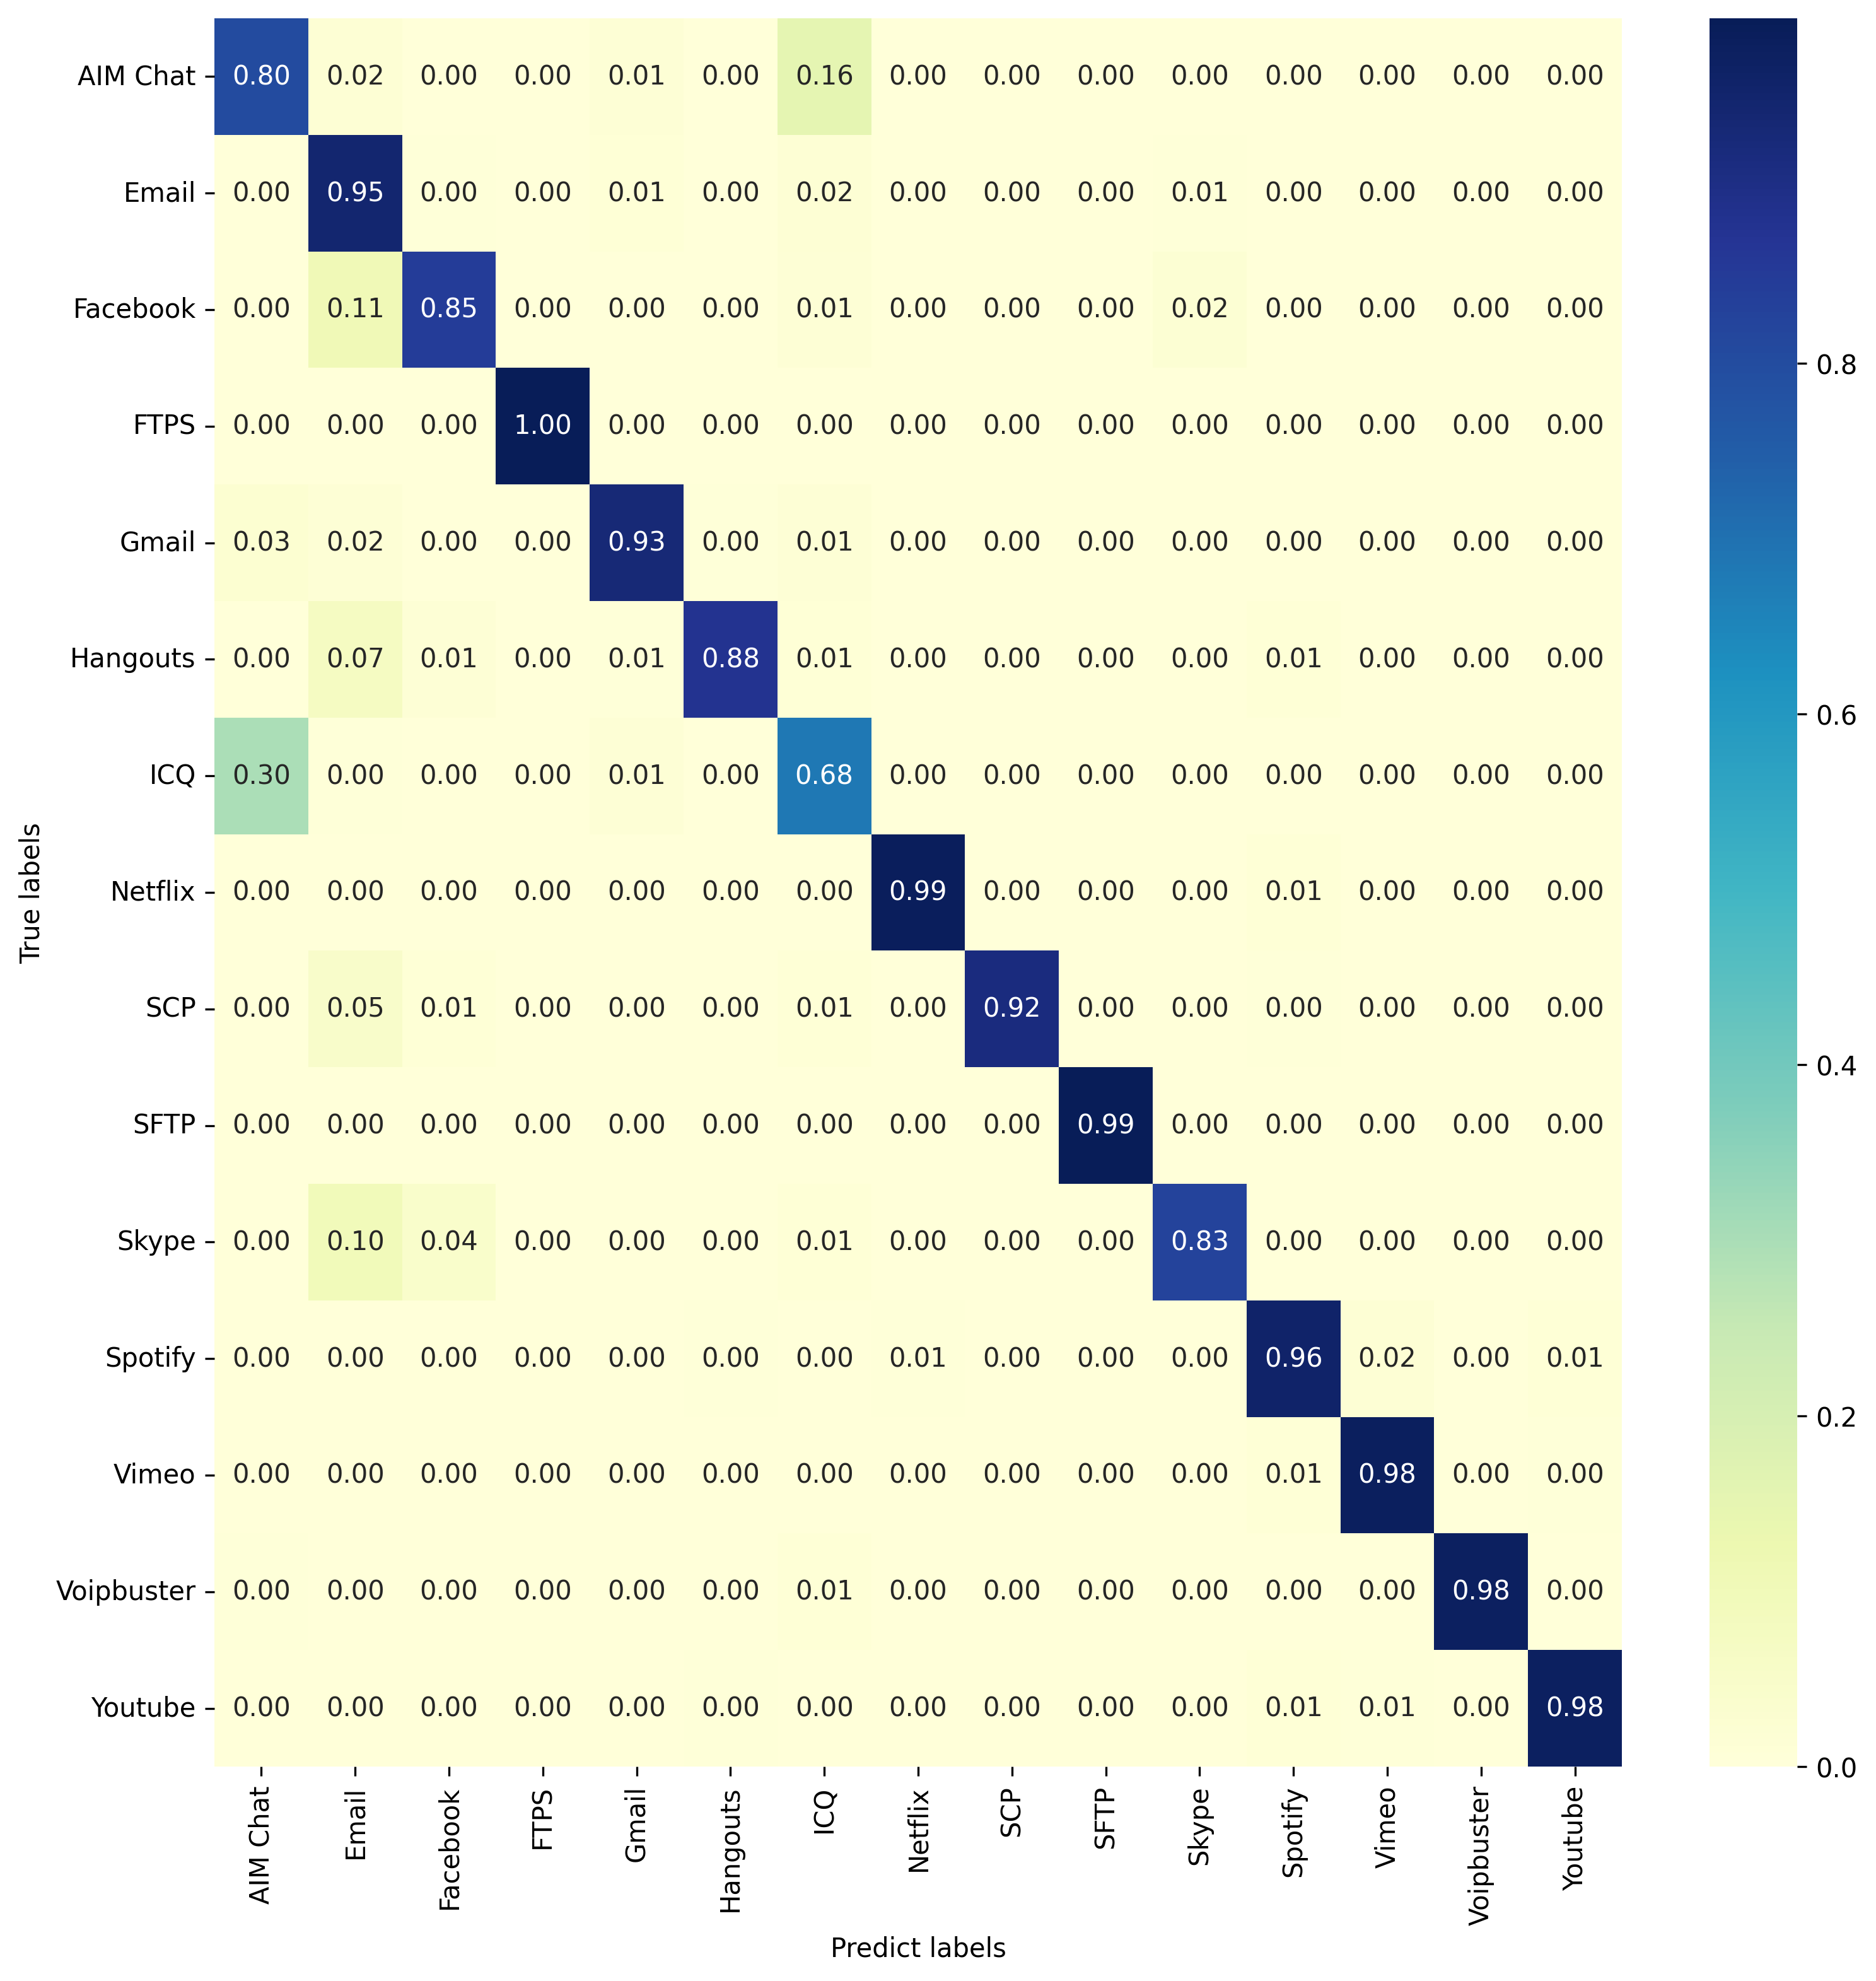

In [ ]:
app_labels = []
for i in sorted(list(ID_TO_APP.keys())):
    app_labels.append(ID_TO_APP[i])

plot_confusion_matrix(app_cnn_cm, app_labels)

In [ ]:
get_classification_report(app_cnn_cm, app_labels)

label  precision    recall
0     AIM Chat   0.064186  0.802005
1        Email   0.063349  0.949342
2     Facebook   0.909258  0.846599
3         FTPS   0.999217  0.996491
4        Gmail   0.150385  0.931945
5     Hangouts   0.995248  0.877493
6          ICQ   0.016200  0.681887
7      Netflix   0.974251  0.987507
8          SCP   0.936459  0.916515
9         SFTP   0.980021  0.994973
10       Skype   0.977825  0.828217
11     Spotify   0.318587  0.958333
12       Vimeo   0.944039  0.984090
13  Voipbuster   0.986727  0.979945
14     Youtube   0.965711  0.977948

###Inference - Gradient

Loading data from directory: /content/drive/MyDrive/COL867_Assignment2/test.parquet/
Loaded data: X shape=(100, 1500), y shape=(100,)
Model expected input shape: Check model documentation
Actual data shape: (100, 1500)
Calculating importance for class AIM Chat (ID: 0)...
Calculating importance for class Email (ID: 1)...
Calculating importance for class Facebook (ID: 2)...
Calculating importance for class FTPS (ID: 3)...
Calculating importance for class Gmail (ID: 4)...
Calculating importance for class Hangouts (ID: 5)...
Calculating importance for class ICQ (ID: 6)...
Calculating importance for class Netflix (ID: 7)...
Calculating importance for class SCP (ID: 8)...
Calculating importance for class SFTP (ID: 9)...
Calculating importance for class Skype (ID: 10)...
Calculating importance for class Spotify (ID: 11)...
Calculating importance for class Vimeo (ID: 12)...
Calculating importance for class Voipbuster (ID: 13)...
Calculating importance for class Youtube (ID: 14)...


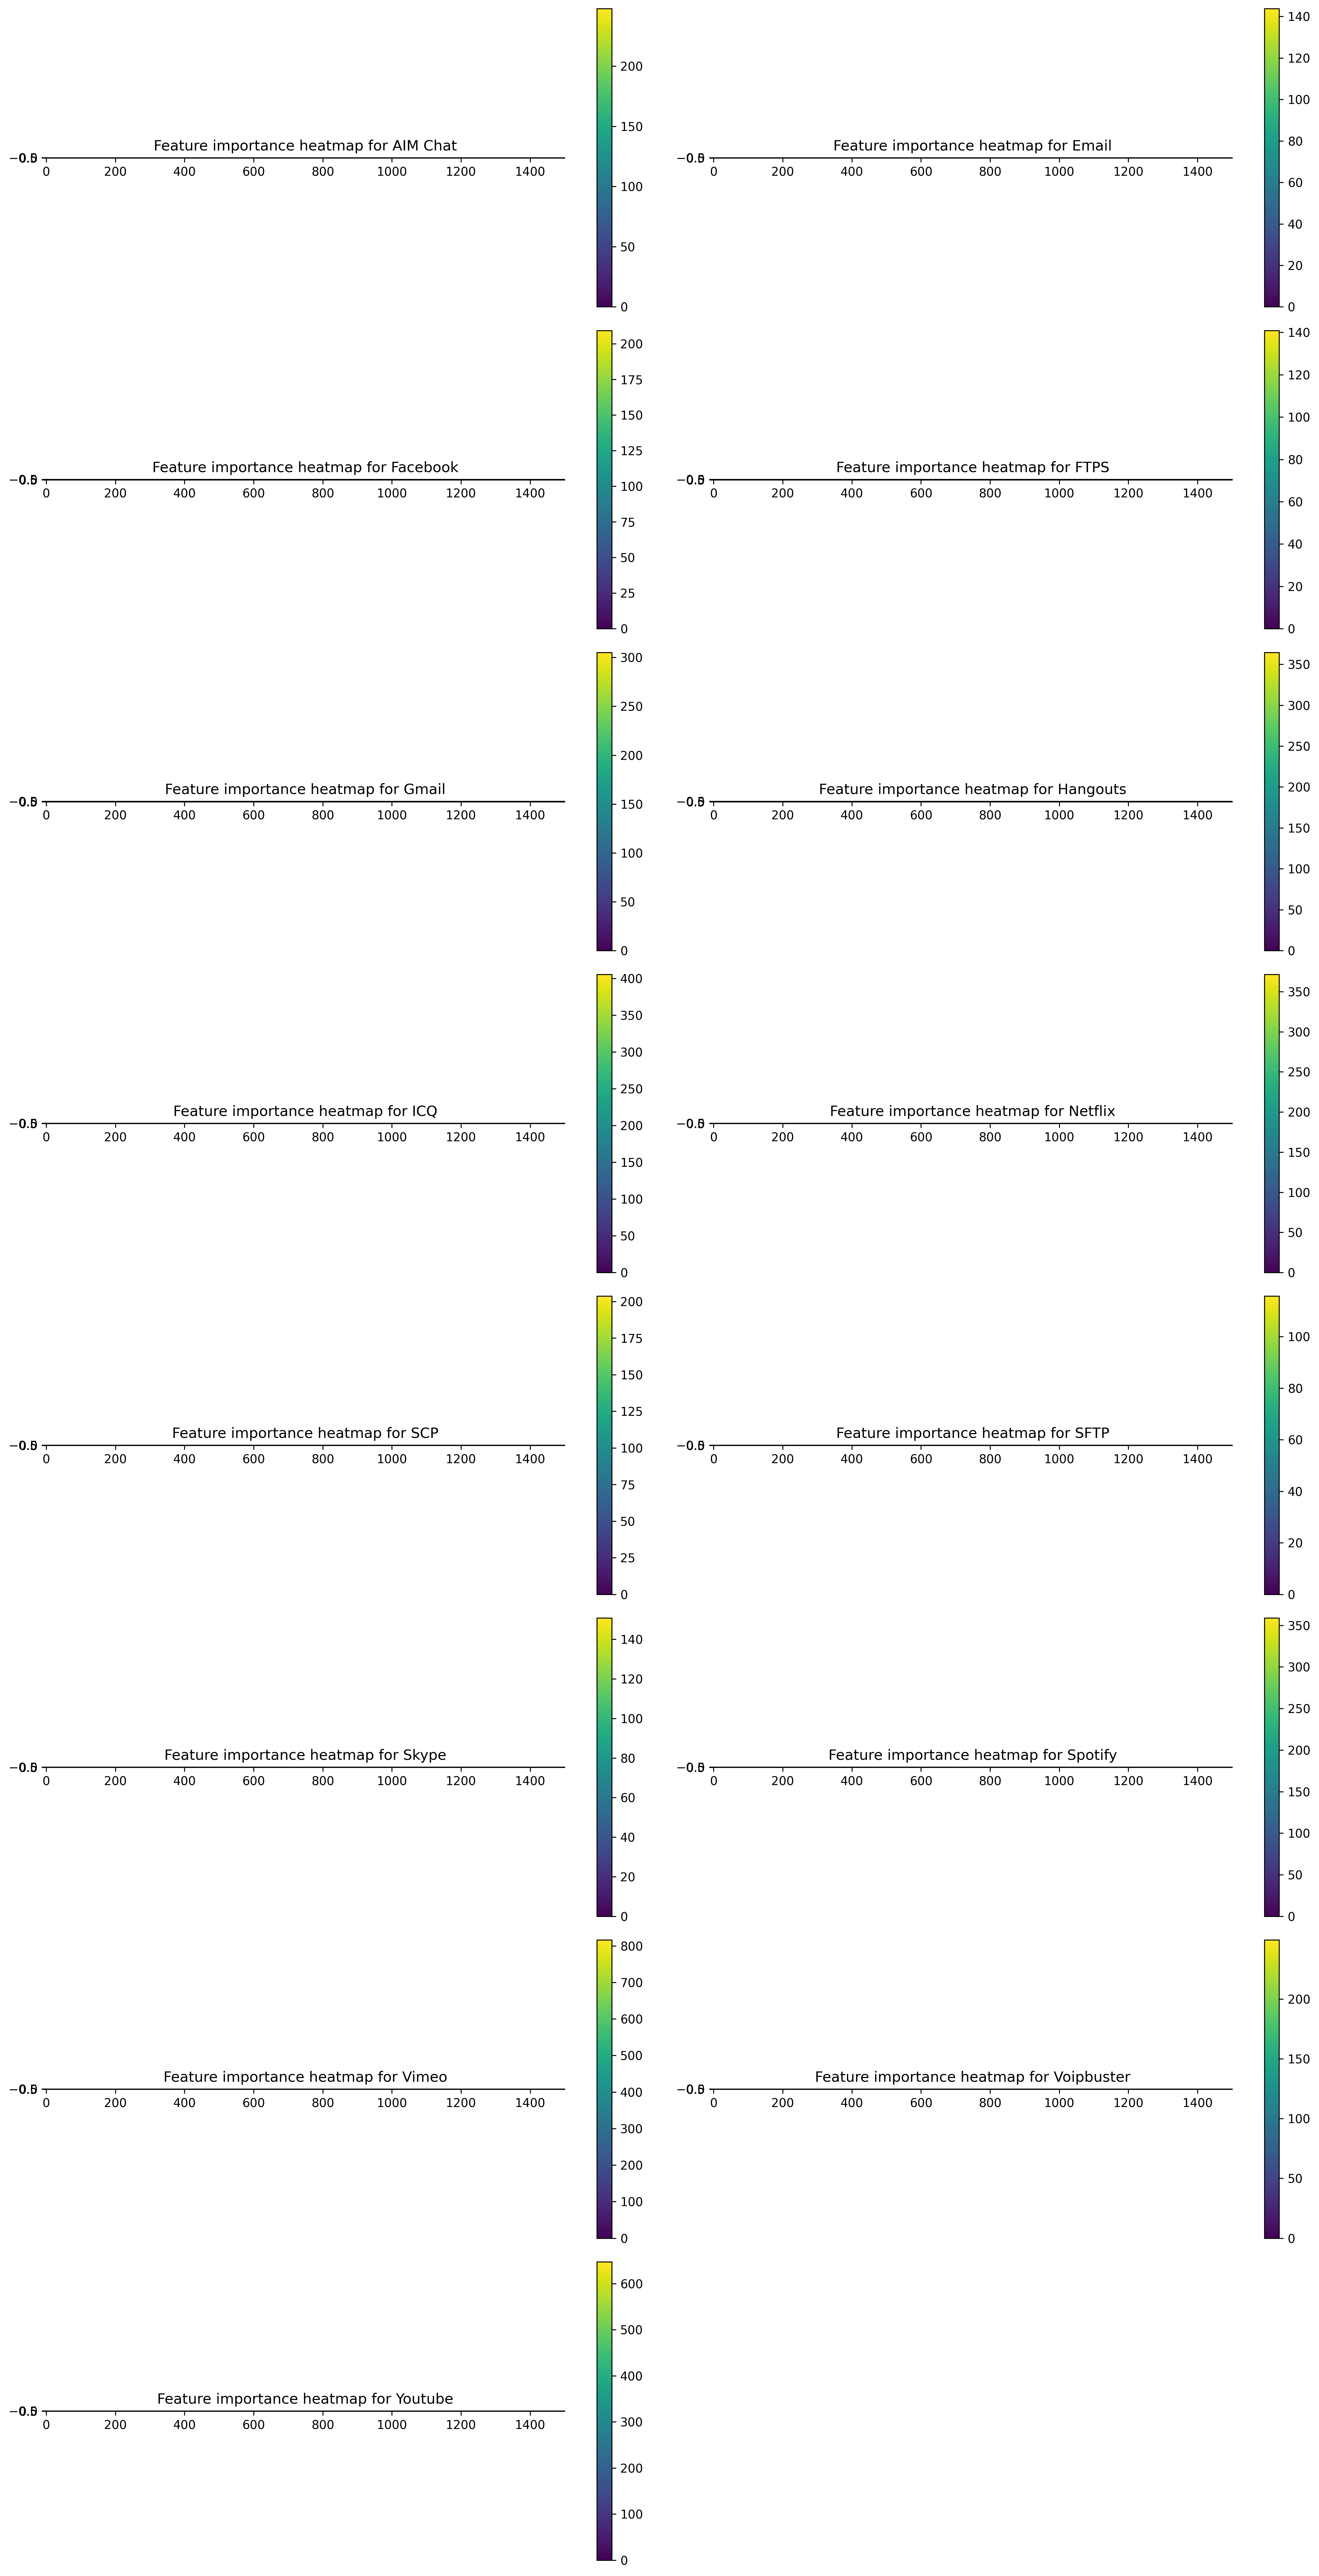

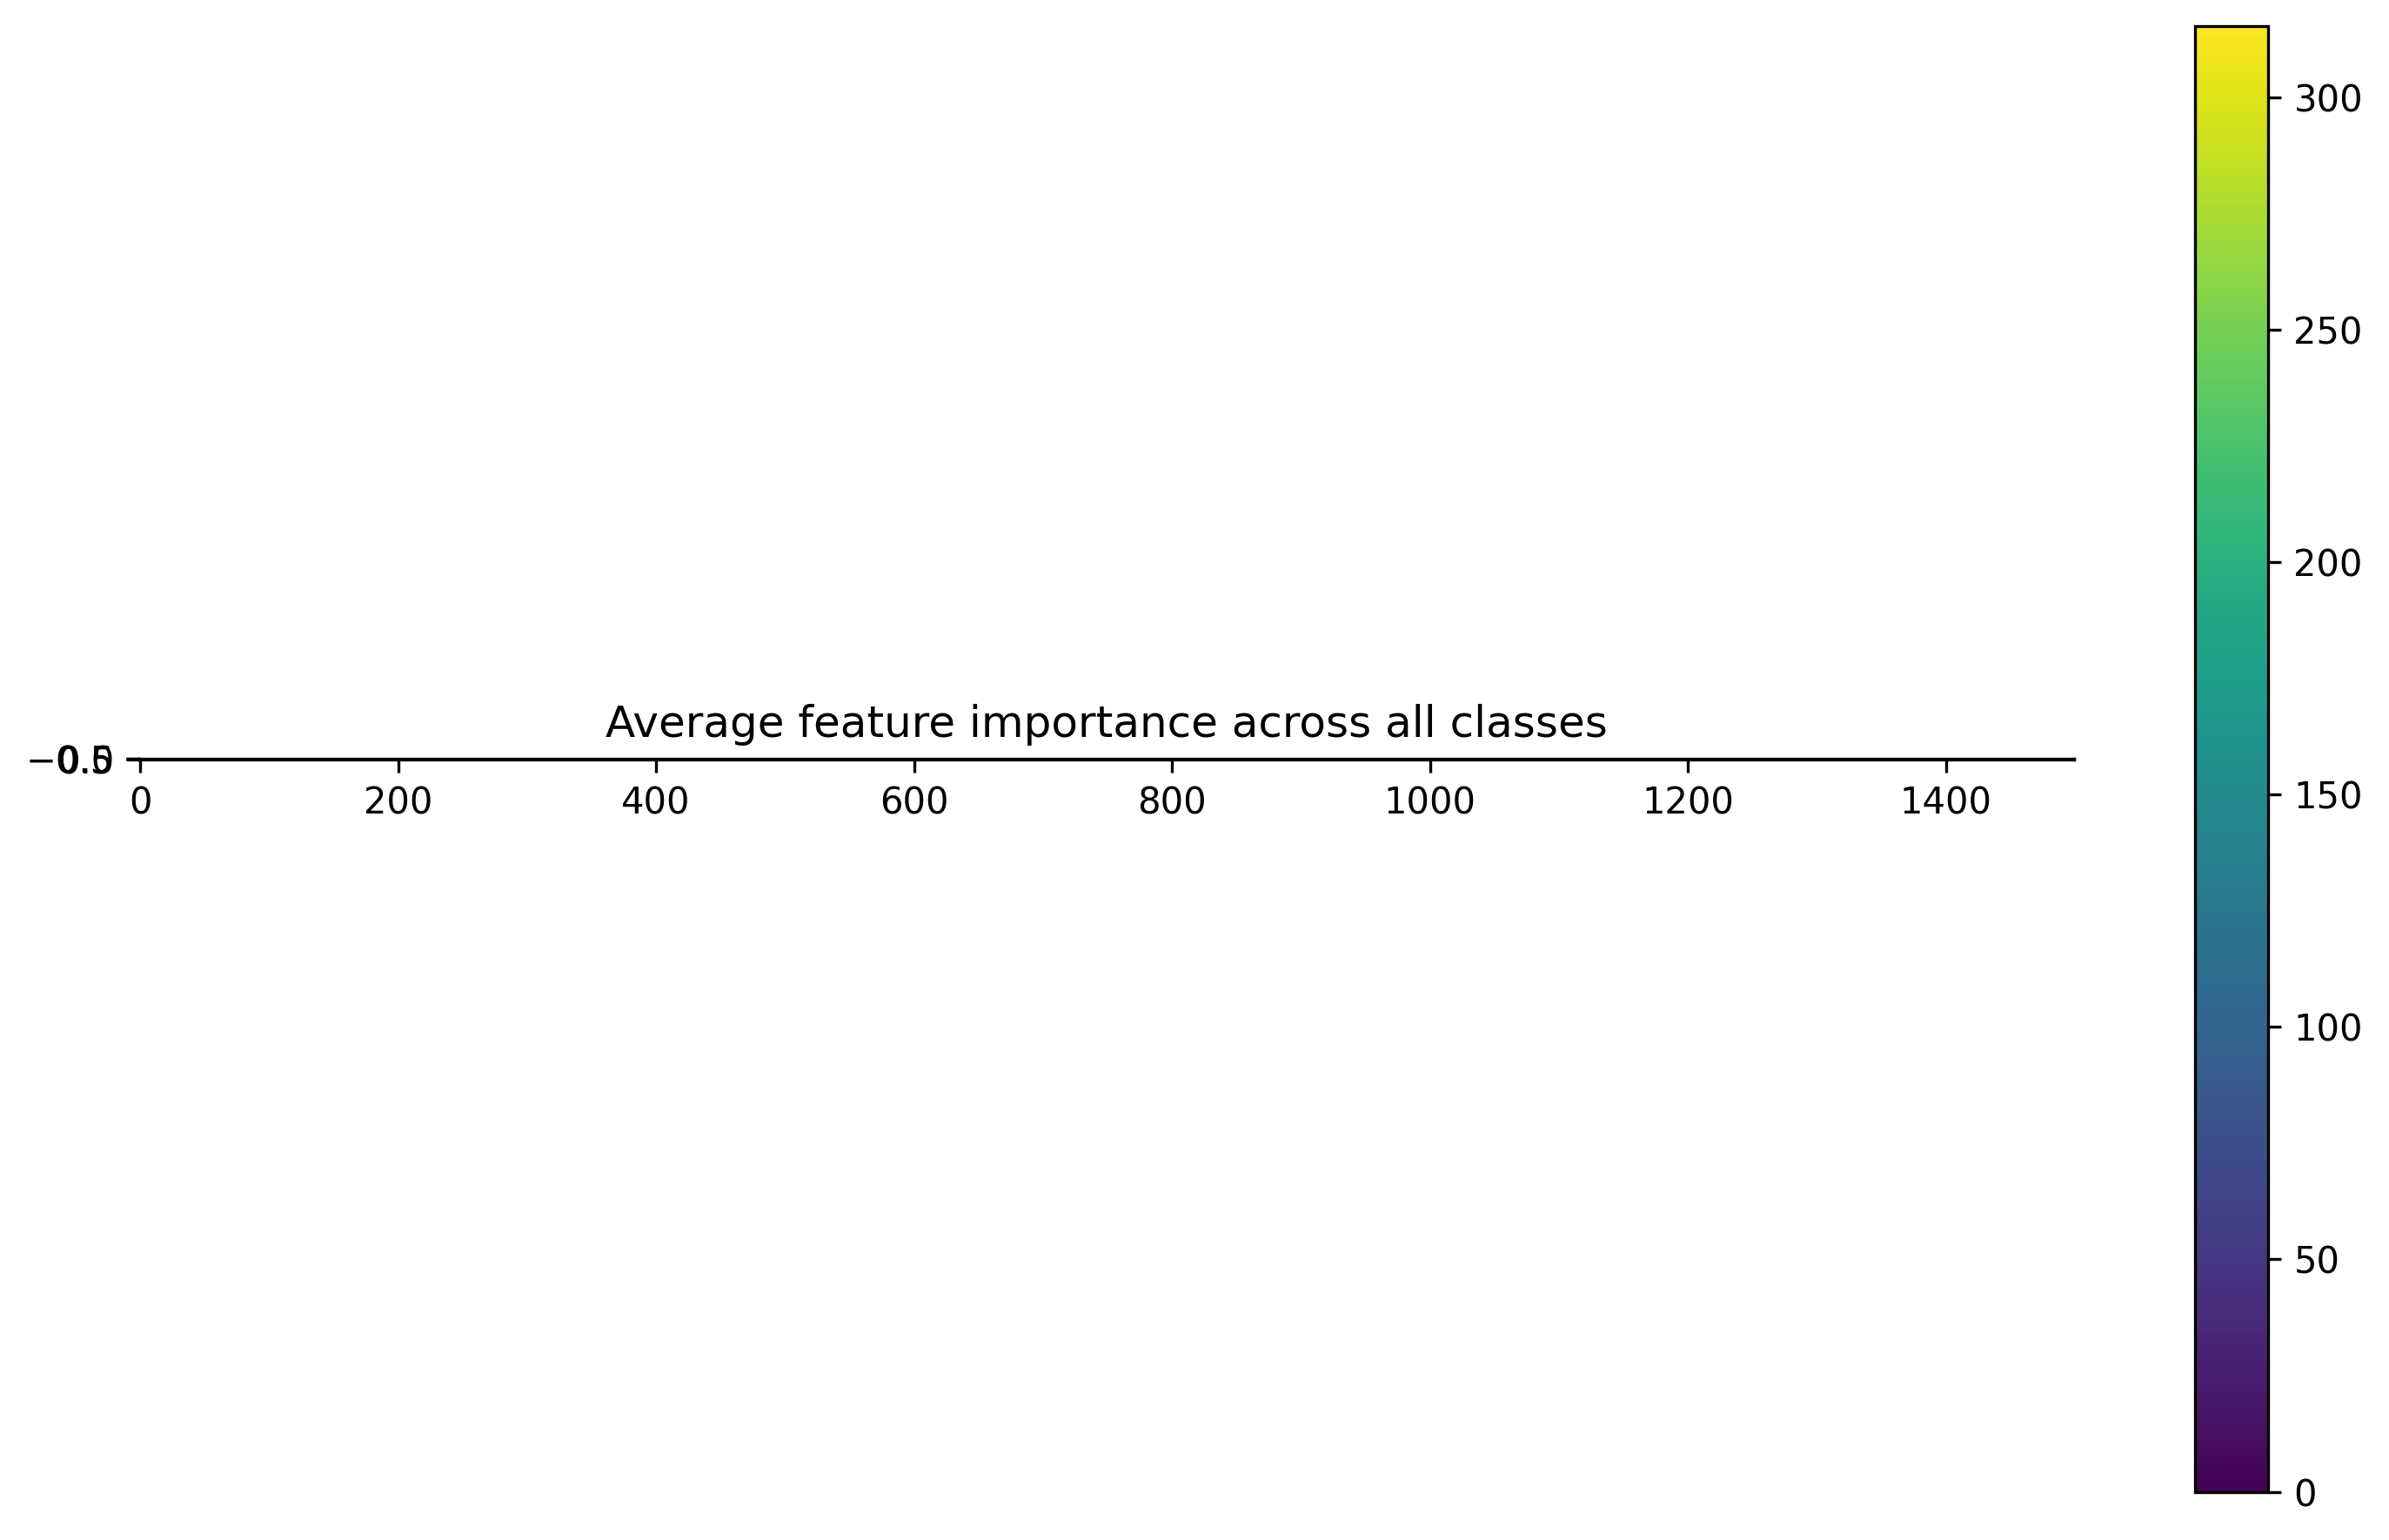

Feature importances saved to 'feature_importances.csv'


In [27]:
# Load your model and test data
model = load_application_classification_cnn_model(application_classification_cnn_model_path, gpu=False)

import os
import glob
import numpy as np
import torch
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import pandas as pd

def load_parquet_dataset_from_folder(folder_path, max_samples=1000):
    """
    Loads and combines features and labels from multiple Parquet files in a folder.
    Args:
        folder_path (str): Path to the folder containing .parquet files.
        max_samples (int): Max total number of samples to load for speed.
    Returns:
        X (np.ndarray): Feature array (n_samples, n_features).
        y (np.ndarray): Label array (n_samples,).
    """
    all_features = []
    all_labels = []

    parquet_files = glob.glob(os.path.join(folder_path, "*.parquet"))
    if not parquet_files:
        raise FileNotFoundError(f"No .parquet files found in {folder_path}")

    for file_path in sorted(parquet_files):
        try:
            df = pq.read_table(file_path).to_pandas()
            if 'feature' not in df.columns or 'label' not in df.columns:
                print(f"Skipping {file_path} — missing 'feature' or 'label'")
                continue

            features = df['feature'].tolist()
            labels = df['label'].tolist()
            all_features.extend(features)
            all_labels.extend(labels)
            if len(all_features) >= max_samples:
                break
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue
    # Truncate to max_samples
    all_features = all_features[:max_samples]
    all_labels = all_labels[:max_samples]
    # Convert to NumPy arrays
    X = np.array(all_features, dtype=np.float32)
    y = np.array(all_labels)
    return X, y

# Function to calculate gradient-based feature importance for PyTorch models
def calculate_gradient_importance_pytorch(model, X, class_idx=None):

    if X.ndim == 2:
        X = X[:, np.newaxis, :]  # Ensures shape (batch, channels=1, sequence_length)
            # Convert numpy array to PyTorch tensor
    X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True)

    # Forward pass
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(X_tensor)

    # Create one-hot encoded target for the class of interest
    if class_idx is not None:
        target = torch.zeros_like(outputs)
        target[:, class_idx] = 1.0
    else:
        # For predicted class
        _, predicted = torch.max(outputs, 1)
        target = torch.zeros_like(outputs)
        for i, idx in enumerate(predicted):
            target[i, idx] = 1.0

    # Clear gradients
    if X_tensor.grad is not None:
        X_tensor.grad.zero_()

    # Enable gradient computation
    X_tensor.requires_grad_(True)

    # Forward pass with gradient tracking
    outputs = model(X_tensor)

    # Backward pass
    torch.sum(outputs * target).backward()

    # Get gradients
    gradients = X_tensor.grad.detach().numpy()

    # Take absolute value and average across samples
    feature_importance = np.mean(np.abs(gradients), axis=0)

    return feature_importance

# Load data using the folder-based approach
parquet_dir = '/content/drive/MyDrive/COL867_Assignment2/test.parquet/'
print(f"Loading data from directory: {parquet_dir}")
X_test, y_test = load_parquet_dataset_from_folder(parquet_dir, max_samples=100)  # Start with fewer samples
print(f"Loaded data: X shape={X_test.shape}, y shape={y_test.shape}")

# Check if the model input shape matches the data
print(f"Model expected input shape: Check model documentation")
print(f"Actual data shape: {X_test.shape}")

# Handle potential reshaping if needed (e.g., for CNNs)
# Check if this is a 1D CNN (which expects a specific input shape)
if hasattr(model, 'conv1') and isinstance(model.conv1, torch.nn.Conv1d):
    print("Detected Conv1d layer, reshaping input")
    # # Reshape for 1D CNN (batch_size, channels, sequence_length)
    # if len(X_test.shape) == 2:
    #     X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    #     print(f"Reshaped data: {X_test.shape}")
    if len(X_test.shape) == 2:
        X_test = X_test[:, np.newaxis, :]  # shape becomes (batch, 1, sequence_length)
        print(f"Reshaped data: {X_test.shape}")

# Calculate feature importance for each class
importances = {}
for class_id in ID_TO_APP.keys():
    print(f"Calculating importance for class {ID_TO_APP[class_id]} (ID: {class_id})...")
    importances[ID_TO_APP[class_id]] = calculate_gradient_importance_pytorch(model, X_test, class_id)

# Visualize the results
def plot_feature_importance(importances, top_n=20):
    num_classes = len(importances)
    fig, axes = plt.subplots(nrows=(num_classes+1)//2, ncols=2, figsize=(16, num_classes*2))
    if num_classes == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, (class_name, importance) in enumerate(importances.items()):
        if i < len(axes):
            ax = axes[i]

            # Handle different feature shapes
            if len(importance.shape) > 1:
                # For 2D+ features, use a heatmap
                im = ax.imshow(importance, cmap='viridis')
                ax.set_title(f"Feature importance heatmap for {class_name}")
                plt.colorbar(im, ax=ax)
            else:
                # For 1D features, use a bar plot of top features
                top_indices = np.argsort(importance)[-top_n:]
                top_values = importance[top_indices]

                ax.barh(range(len(top_indices)), top_values)
                ax.set_yticks(range(len(top_indices)))
                ax.set_yticklabels([f"Feature {idx}" for idx in top_indices])
                ax.set_title(f"Top {top_n} features for {class_name}")
                ax.set_xlabel("Importance")

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('class_feature_importances.png', dpi=300)
    plt.show()

# Plot the feature importances
plot_feature_importance(importances)

# Additionally, create a global feature importance by averaging across all classes
all_importances = np.zeros_like(list(importances.values())[0])
for imp in importances.values():
    all_importances += imp
all_importances /= len(importances)

plt.figure(figsize=(10, 6))
if len(all_importances.shape) > 1:
    plt.imshow(all_importances, cmap='viridis')
    plt.colorbar()
    plt.title("Average feature importance across all classes")
else:
    top_n = 30
    top_indices = np.argsort(all_importances)[-top_n:]
    top_values = all_importances[top_indices]

    plt.barh(range(len(top_indices)), top_values)
    plt.yticks(range(len(top_indices)), [f"Feature {idx}" for idx in top_indices])
    plt.title(f"Top {top_n} features (average across all classes)")
    plt.xlabel("Importance")

plt.tight_layout()
plt.savefig('global_feature_importances.png', dpi=300)
plt.show()

# Save the importance values to a CSV file for further analysis
importance_df = pd.DataFrame()
for class_name, importance in importances.items():
    flat_imp = importance.flatten() if len(importance.shape) > 1 else importance
    importance_df[class_name] = flat_imp
flat_all_imp = all_importances.flatten() if len(all_importances.shape) > 1 else all_importances
importance_df['global'] = flat_all_imp

importance_df.to_csv('feature_importances.csv')
print("Feature importances saved to 'feature_importances.csv'")

In [28]:
importance_df

AIM Chat     Email  Facebook       FTPS     Gmail  Hangouts        ICQ  \
0      2.609494  1.236218  1.172803   3.578747  2.740085  1.922535   3.593735   
1     11.456998  3.662650  3.248699  12.246537  7.685219  6.693678  11.449684   
2      5.836629  2.058406  2.424567   4.777020  4.316893  4.335640   4.911482   
3      3.511667  1.000136  0.844447   3.589429  1.397401  1.649604   3.226730   
4      5.216626  1.212636  1.953321   5.147446  4.150525  4.903587   7.448333   
...         ...       ...       ...        ...       ...       ...        ...   
1495   0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   
1496   0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   
1497   0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   
1498   0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   
1499   0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   0.000000   

        Netflix       SCP      SFTP     Skype   Spotify      Vimeo  \
0      3.263111  1.564912  1.149677  1.044373  1.734259   4.938445   
1     12.817369  6.212331  4.115006  2.725650  5.316943  16.935558   
2      8.005695  4.084311  1.873211  1.772853  3.430959   9.677316   
3      3.270544  1.212131  1.079391  0.686930  1.385438   4.377213   
4      5.982888  2.764287  2.503890  2.046133  4.048233  11.663592   
...         ...       ...       ...       ...       ...        ...   
1495   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
1496   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
1497   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
1498   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
1499   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   

      Voipbuster    Youtube    global  
0       3.411659   3.540131  2.500012  
1      12.290051  12.272758  8.608608  
2       5.042994   6.381313  4.595286  
3       3.680373   2.723221  2.242311  
4       6.118532   8.131118  4.886076  
...          ...        ...       ...  
1495    0.000000   0.000000  0.000000  
1496    0.000000   0.000000  0.000000  
1497    0.000000   0.000000  0.000000  
1498    0.000000   0.000000  0.000000  
1499    0.000000   0.000000  0.000000  

[1500 rows x 16 columns]

###Inference - TRUSTEE

In [2]:
!pip install trustee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.7/328.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 27.2 MB/s eta 0:00:00
  Created wheel for sphinxemoji: filename=sphinxemoji-0.2.0-py3-none-any.whl size=44408 sha256=f8dccbebbf2e23230d0b854d74c00f4127513610265cafd56c213fb905d09d96
  Stored in directory: /root/.cache/pip/wheels/d4/b0/a5/92b0e0b5611fc4d37f90711172a680959318c4474df5d2718d
  Created whee

In [4]:
!pip install --upgrade pandas numpy

  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trustee 1.1.6 requires pandas<2.0.0,>=1.1.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
arviz 0.21.0 requires setuptools>=60.0.0, but you have setuptools 57.5.0 which is incompatible.


In [26]:
import glob
import os
import time
from trustee import ClassificationTrustee
import pyarrow.parquet as pq

def load_parquet_dataset_from_folder(folder_path, max_samples=1000):
    all_features = []
    all_labels = []

    parquet_files = glob.glob(os.path.join(folder_path, "*.parquet"))
    if not parquet_files:
        raise FileNotFoundError(f"No .parquet files found in {folder_path}")

    for file_path in sorted(parquet_files):
        try:
            df = pq.read_table(file_path).to_pandas()
            if 'feature' not in df.columns or 'label' not in df.columns:
                print(f"Skipping {file_path} — missing 'feature' or 'label'")
                continue

            features = df['feature'].tolist()
            labels = df['label'].tolist()
            all_features.extend(features)
            all_labels.extend(labels)
            if len(all_features) >= max_samples:
                break
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue
    # Truncate to max_samples
    all_features = all_features[:max_samples]
    all_labels = all_labels[:max_samples]
    # Convert to NumPy arrays
    X = np.array(all_features, dtype=np.float32)
    y = np.array(all_labels)
    return X, y

class WrappedModel:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def predict(self, X):
        with torch.no_grad():
            # Ensure X is converted to tensor properly
            if isinstance(X, pd.DataFrame):
                X_tensor = torch.from_numpy(X.values)
            elif isinstance(X, np.ndarray):
                X_tensor = torch.from_numpy(X)
            else:
                X_tensor = X  # Assume already a tensor

            if len(X_tensor.shape) == 2:
                # If only batch x features, add a channel dimension if your model needs it
                X_tensor = X_tensor.unsqueeze(1)

            logits = self.model(X_tensor.float())
            probs = F.log_softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
        return preds.cpu().numpy()

model = load_application_classification_cnn_model(application_classification_cnn_model_path, gpu=False)
model = WrappedModel(model)  # << wrap it here

# Load data using the folder-based approach
parquet_dir = '/content/drive/MyDrive/COL867_Assignment2/test.parquet/'
print(f"Loading data from directory: {parquet_dir}")
X_test, y_test = load_parquet_dataset_from_folder(parquet_dir, max_samples=1000)  # Start with fewer samples
print(f"Loaded data: X shape={X_test.shape}, y shape={y_test.shape}")

# Check if the model input shape matches the data
print(f"Model expected input shape: Check model documentation")
print(f"Actual data shape: {X_test.shape}")

# Initialize TRUSTEE
trustee = ClassificationTrustee(expert=model)

# Convert X_test to numpy array if it's a DataFrame
if isinstance(X_test, pd.DataFrame):
    X_test = X_test.to_numpy()

trustee.fit(X_test, y_test, num_iter=50, num_stability_iter=10, samples_size=0.5, verbose=True)

# Explain the model (using a subset of your test data for performance evaluation)
start_time = time.time()
# dt, pruned_dt, agreement, reward = trustee.explain(X=X_test[:100], y=y_test[:100]) #Explain on a subset
dt, pruned_dt, agreement, reward = trustee.explain()  #Explain on entire test set
end_time = time.time()

# Predict using the explanation model
dt_y_pred = dt.predict(X_test)
from sklearn.metrics import classification_report

# Print evaluation metrics
print("Model explanation global fidelity report:")
print(classification_report(y_pred, dt_y_pred)) # Compare the predictions against the original model (y_pred needed)
print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))  #Compare the explanation's predictions against true labels

print(f"TRUSTEE explanation time: {end_time - start_time:.4f} seconds")

feature_importances = dt.feature_importances_
print(feature_importances)

Loading data from directory: /content/drive/MyDrive/COL867_Assignment2/test.parquet/
Loaded data: X shape=(1000, 1500), y shape=(1000,)
Model expected input shape: Check model documentation
Actual data shape: (1000, 1500)
Initializing training dataset using <__main__.WrappedModel object at 0x7c42b6bea150> as expert model
Expert model score: 0.5691326581787202
Initializing Trustee outer-loop with 10 iterations
########## Outer-loop Iteration 0/10 ##########
Initializing Trustee inner-loop with 10 iterations
########## Inner-loop Iteration 0/50 ##########
Sampling 350 points from training dataset with (700, 700) entries
Student model 0-0 trained with depth 6 and 9 leaves:
Student model score: 0.7650118203309693
Student model 0-0 fidelity: 0.7650118203309693
########## Inner-loop Iteration 1/50 ##########
Sampling 350 points from training dataset with (806, 806) entries
Student model 0-1 trained with depth 4 and 7 leaves:
Student model score: 0.6796966687731335
Student model 0-1 fidelity:

NameError: name 'classification_report' is not defined

In [28]:
from sklearn.metrics import classification_report

# Print evaluation metrics
print("Model explanation global fidelity report:")
print(classification_report(y_test, dt_y_pred)) # Compare the predictions against the original model (y_pred needed)
print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))  #Compare the explanation's predictions against true labels

print(f"TRUSTEE explanation time: {end_time - start_time:.4f} seconds")

feature_importances = dt.feature_importances_
print(feature_importances)

Model explanation global fidelity report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00       391
           9       1.00      0.96      0.98       120
          10       0.99      0.98      0.98       459
          12       0.94      1.00      0.97        30

    accuracy                           0.98      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.99      0.98      0.99      1000

Model explanation score report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00       391
           9       1.00      0.96      0.98       120
          10       0.99      0.98      0.98       459
          12       0.94      1.00      0.97        30

    accuracy                           0.98      1000
   macro avg       0.79      0.79      0.79      1000
wei

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Important feature indices: [  20   40  349 1440 1465]
Top important features in order:
Feature 20 - importance 0.6355
Feature 1440 - importance 0.2793
Feature 1465 - importance 0.0463
Feature 40 - importance 0.0257
Feature 349 - importance 0.0131
Feature 1487 - importance 0.0000
Feature 1486 - importance 0.0000
Feature 1485 - importance 0.0000
Feature 1484 - importance 0.0000
Feature 1483 - importance 0.0000


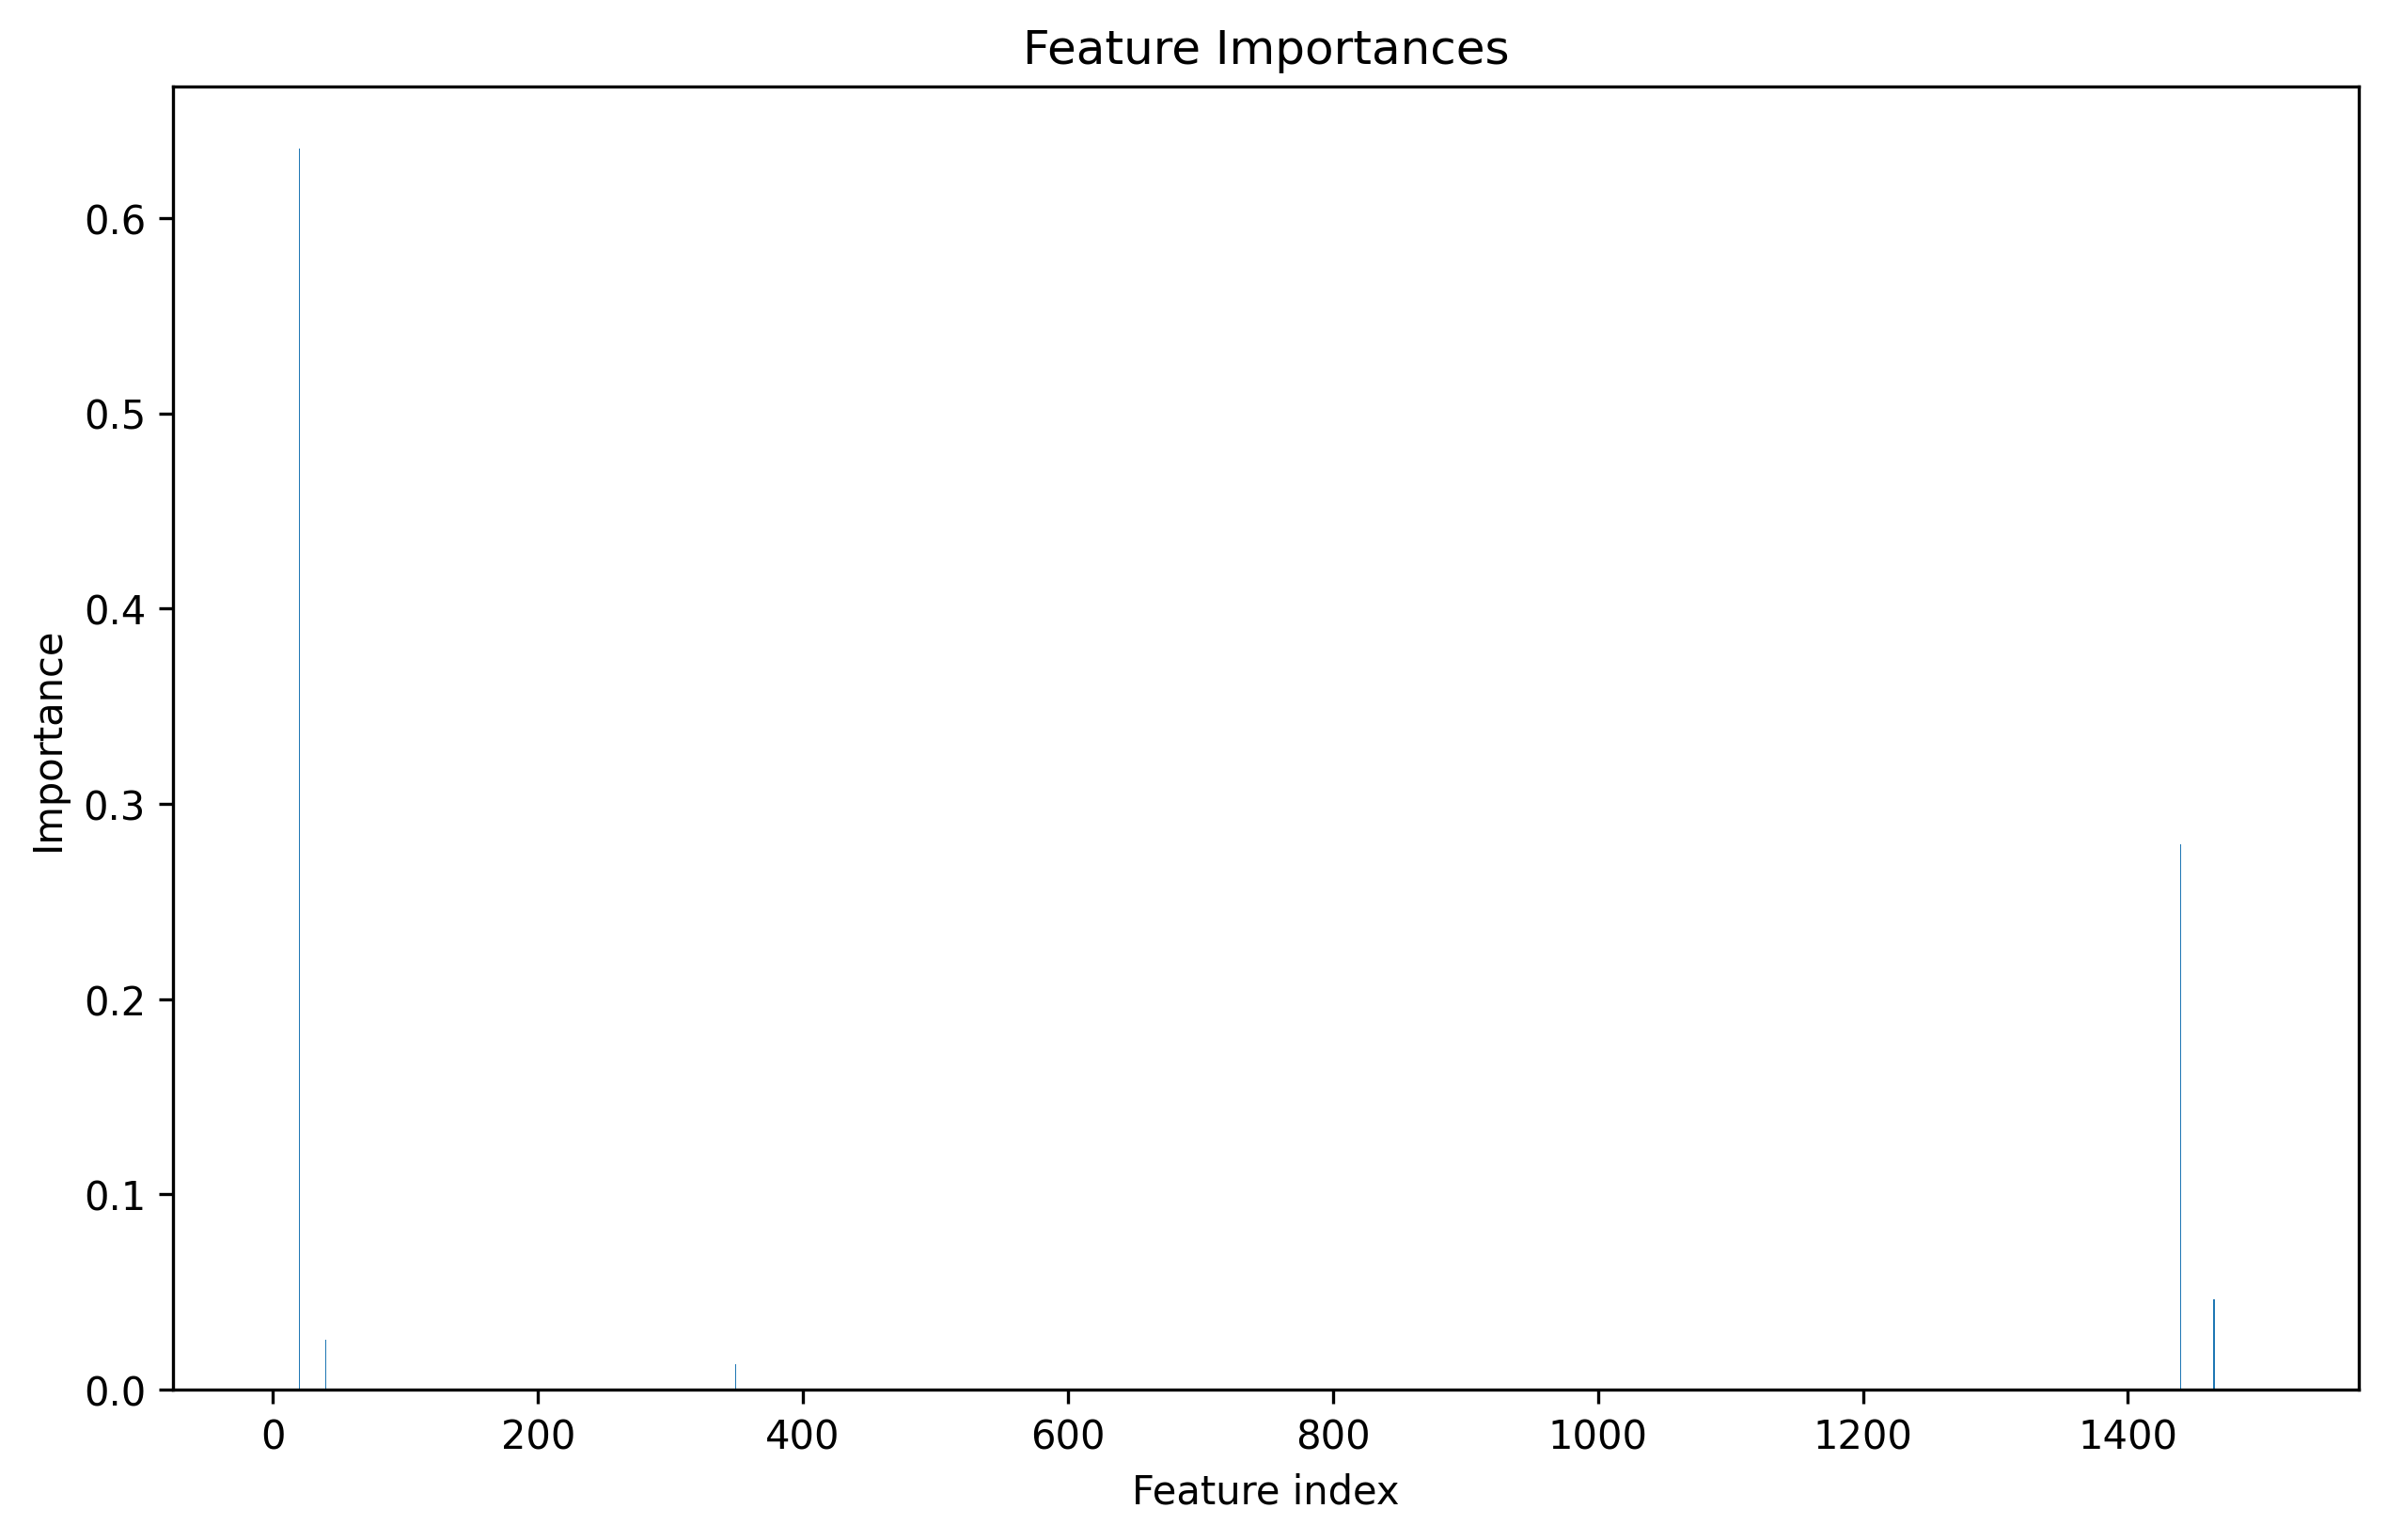

In [29]:
import numpy as np

important_features = np.where(feature_importances > 0)[0]
print(f"Important feature indices: {important_features}")

sorted_indices = np.argsort(-feature_importances)
print("Top important features in order:")
for idx in sorted_indices[:10]:  # Top 10
    print(f"Feature {idx} - importance {feature_importances[idx]:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature index')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [31]:
# Print the important features for first 5 samples
important_indices = [20, 40, 349, 1440, 1465]

for i in range(5):  # first 5 samples
    print(f"Sample {i}:")
    for idx in important_indices:
        print(f"  Feature {idx} = {X_test[i, idx]}")


Sample 0:
  Feature 20 = 0.7568627595901489
  Feature 40 = 0.09803921729326248
  Feature 349 = 0.003921568859368563
  Feature 1440 = 0.12156862765550613
  Feature 1465 = 0.0
Sample 1:
  Feature 20 = 0.7568627595901489
  Feature 40 = 0.3333333432674408
  Feature 349 = 0.24705882370471954
  Feature 1440 = 0.4470588266849518
  Feature 1465 = 0.0
Sample 2:
  Feature 20 = 0.7568627595901489
  Feature 40 = 0.2549019753932953
  Feature 349 = 0.7529411911964417
  Feature 1440 = 0.7529411911964417
  Feature 1465 = 0.0
Sample 3:
  Feature 20 = 0.2235294133424759
  Feature 40 = 0.14509804546833038
  Feature 349 = 0.3490196168422699
  Feature 1440 = 0.26274511218070984
  Feature 1465 = 0.0
Sample 4:
  Feature 20 = 0.2235294133424759
  Feature 40 = 0.7215686440467834
  Feature 349 = 0.9647058844566345
  Feature 1440 = 0.4470588266849518
  Feature 1465 = 0.0


#Final Report - Accuracy, Explainability & Cost

##Accuracy

Class | Your Model F1 | DeepPacket F1 | Better Model

nonvpn_rdp / RDP | 1.00 | ~0.949 | Random Forest ✅

nonvpn_sftp / SFTP | 0.69 | 0.995 | DeepPacket ❌

nonvpn_skype-chat / Skype | 0.99 | 0.828 | Random Forest ✅

nonvpn_vimeo / Vimeo | 0.99 | 0.984 | Random Forest ✅

nonvpn_youtube / Youtube | 0.92 | 0.978 | DeepPacket ❌

vpn_netflix | 0.54 | 0.987 | DeepPacket ❌

vpn_youtube | 0.68 | 0.978 | DeepPacket ❌

vpn_voip / Voipbuster | 0.99 | 0.979 | Random Forest ✅

vpn_scp / SCP | 0.90 | 0.916 | Similar

***RF performs better on Skype, VoIP, Vimeo, and RDP, but struggles with SFTP, VPN-based Netflix and Youtube compared to DeepPacket. This likely stems from encrypted traffic being harder to distinguish without deep learning.***

### Random Forest

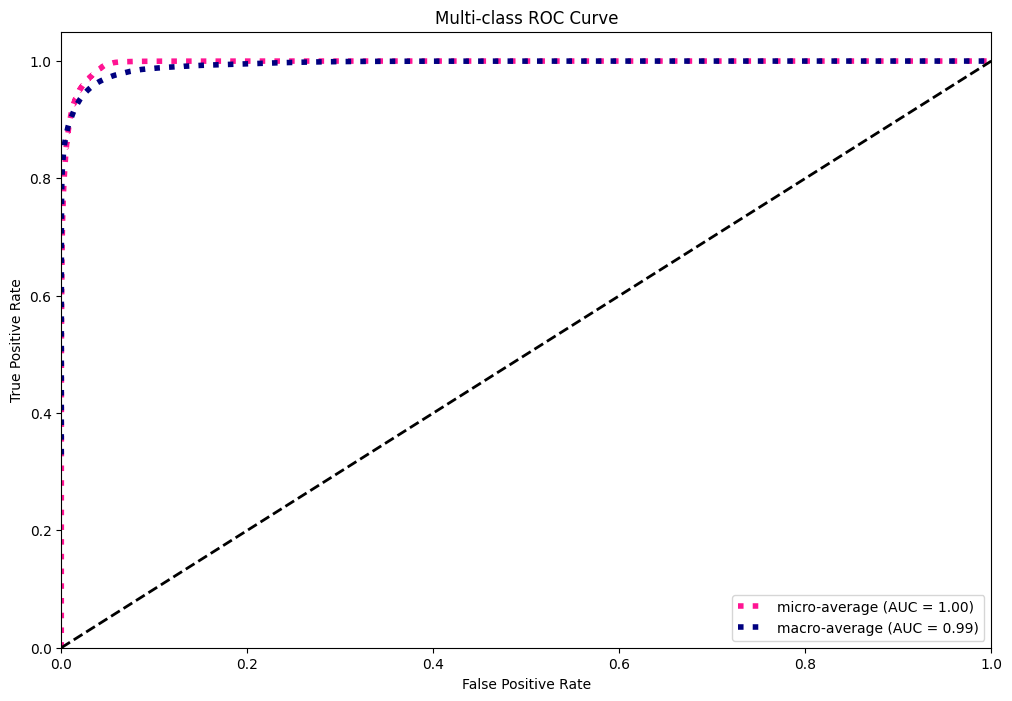

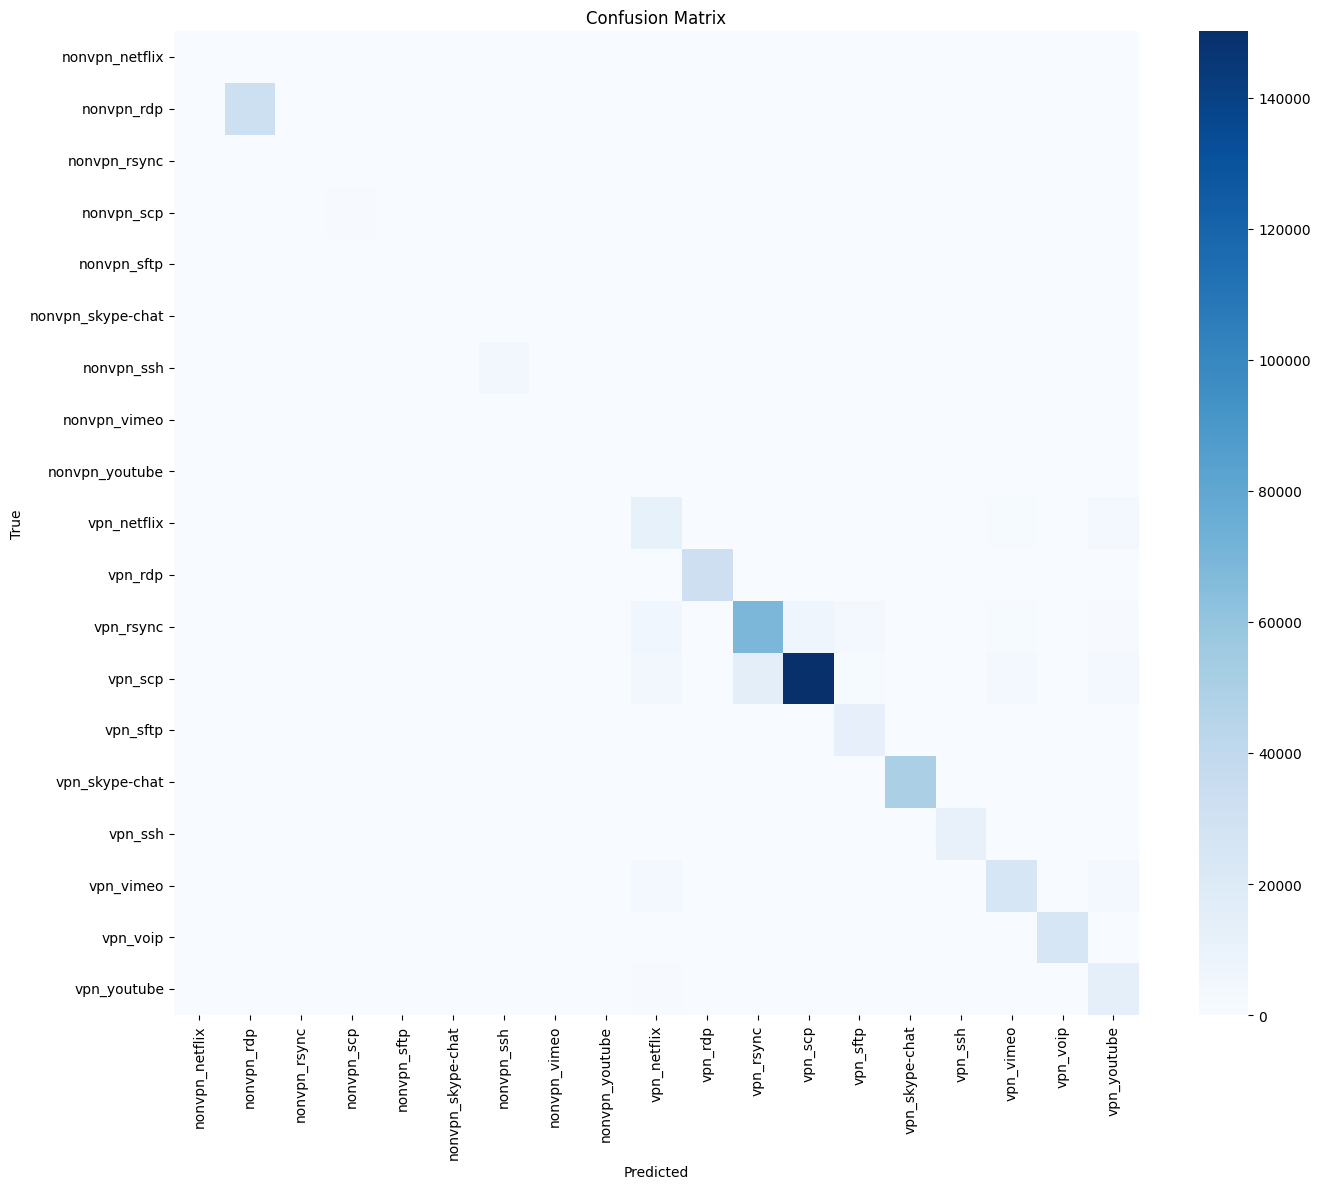

###Deep Packet

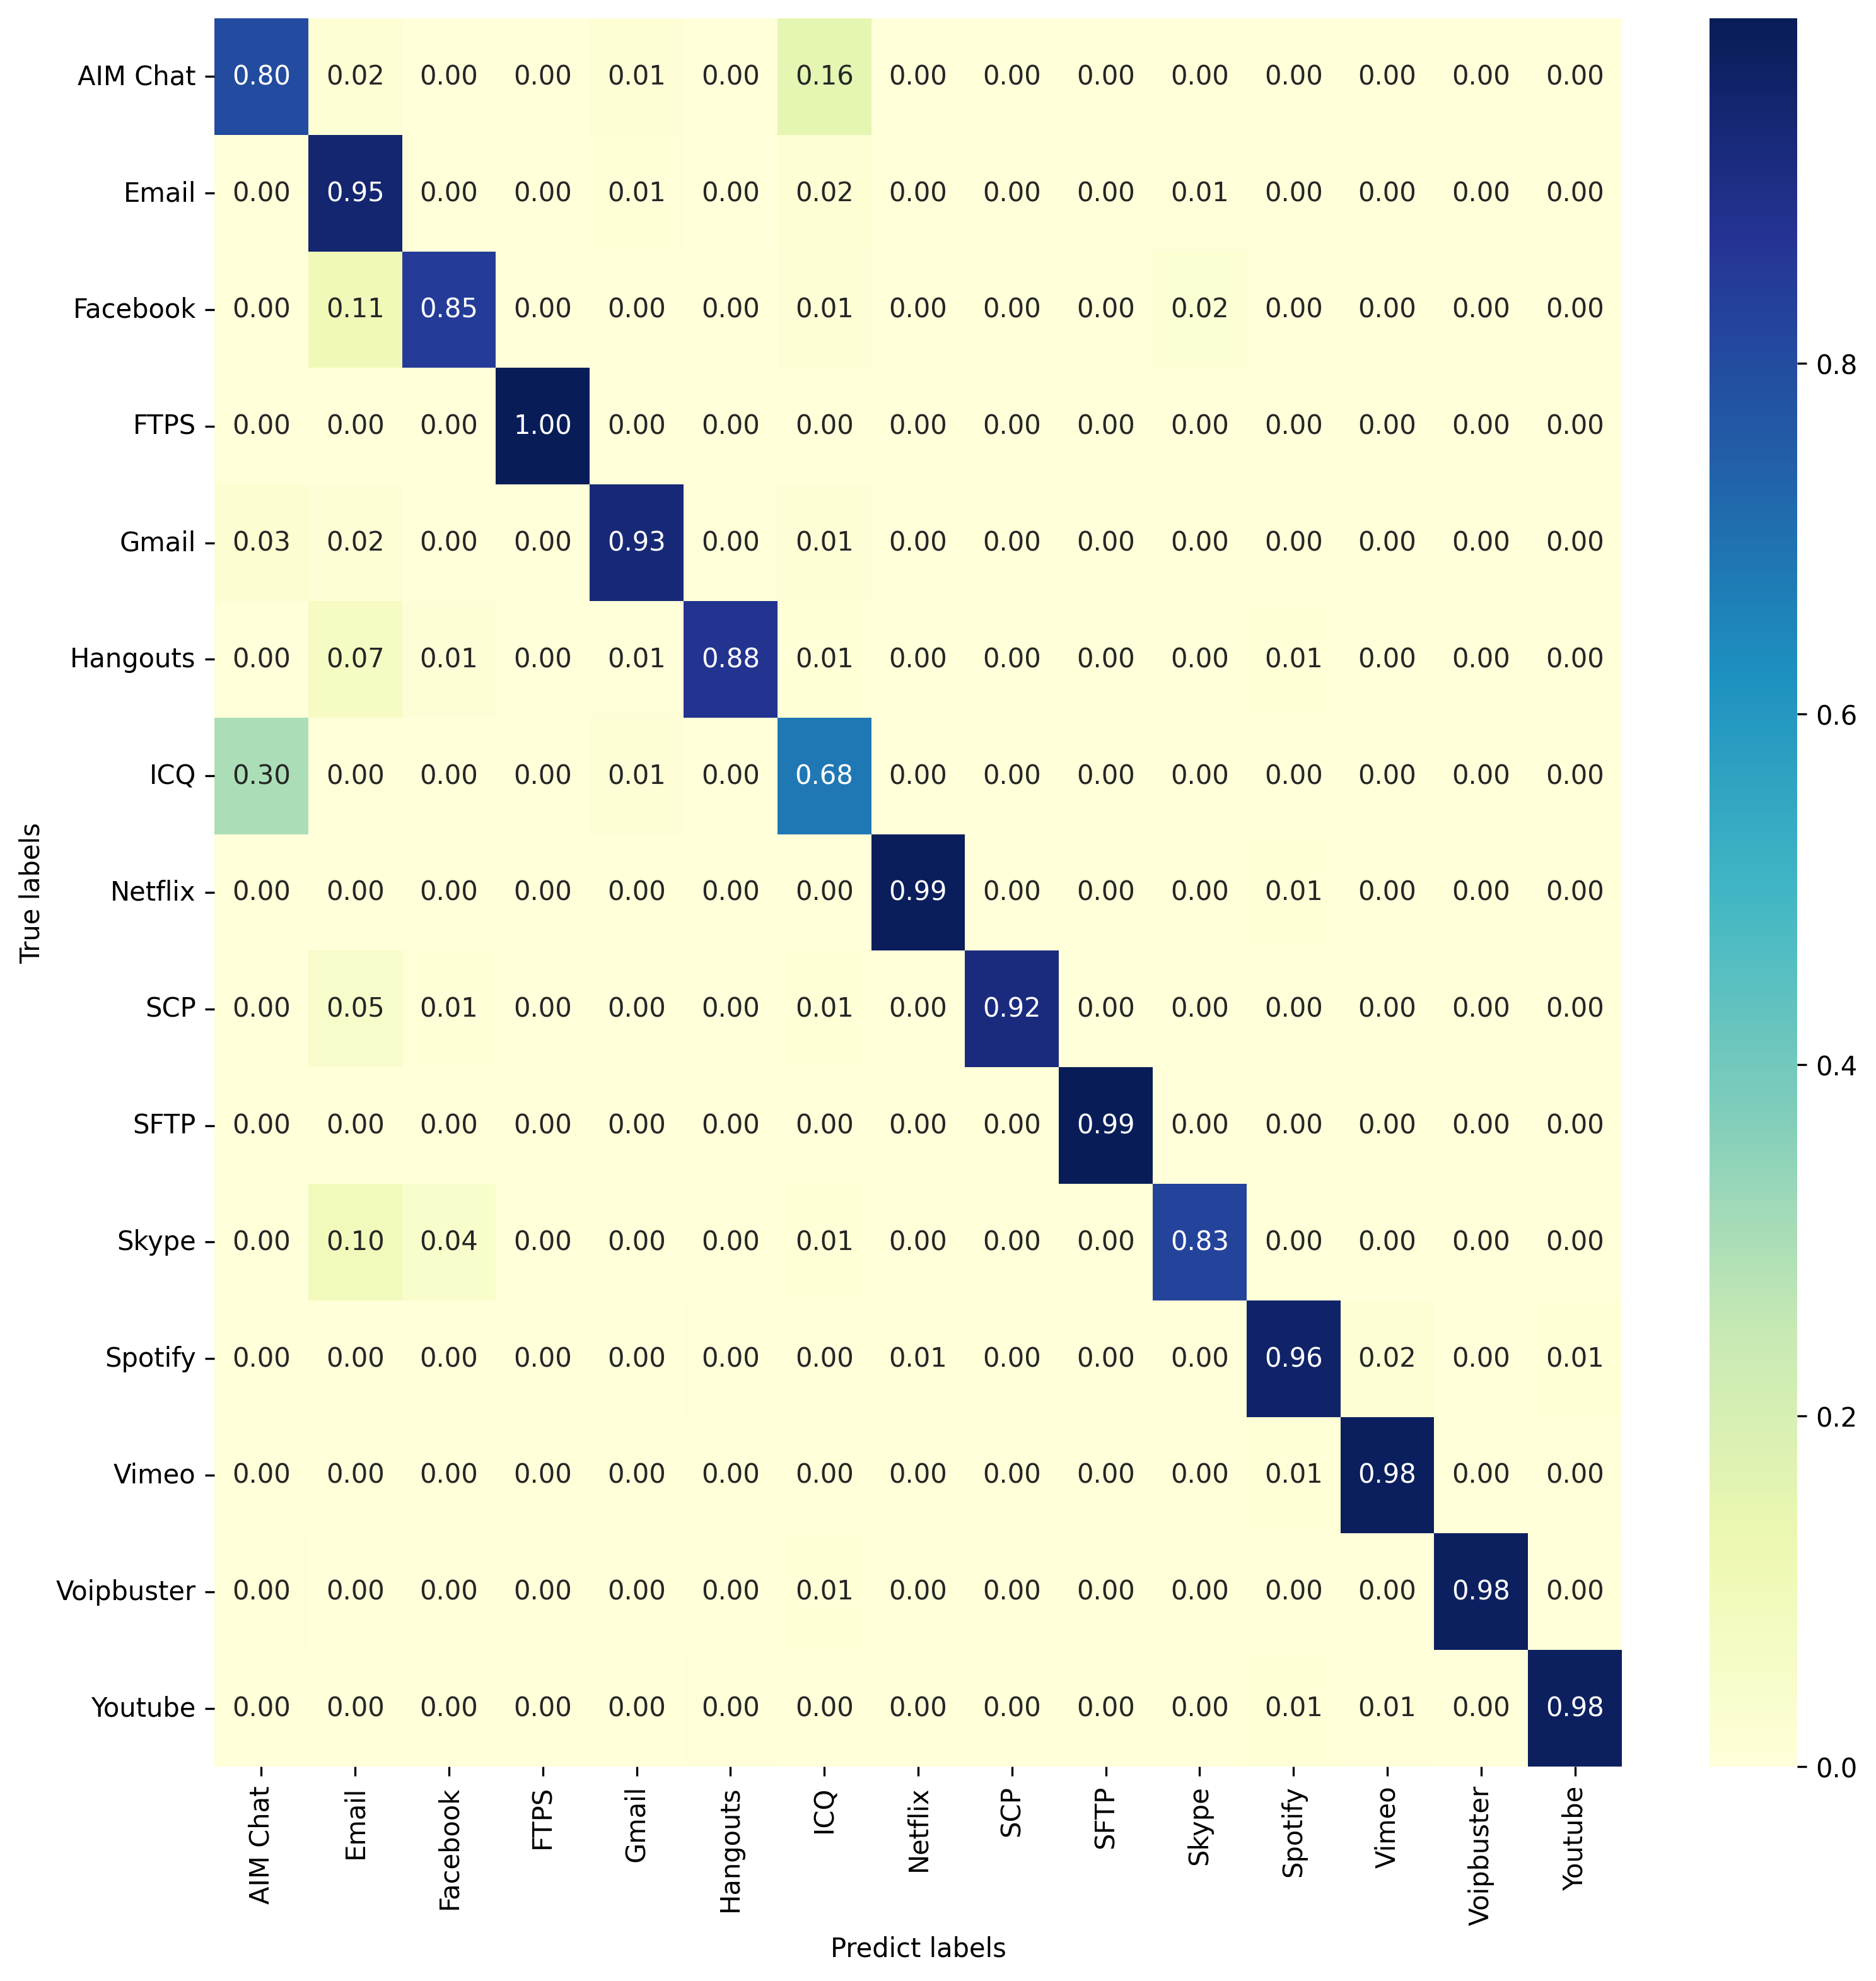

Looking at these confusion matrices reveals important differences between the Random Forest and Deep Packet inspection approaches:

Random Forest model (Image 1):
- Excellent at classifying non-VPN traffic - notice the strong diagonal pattern in the upper-left quadrant
- Shows decent performance on VPN traffic classes as well
- Particularly strong with nonvpn_rdp, vpn_scp, and vpn_voip
- Shows some confusion between similar service types (especially with VPN-encrypted variants)
- Notably struggles with vpn_netflix classification (lighter diagonal square)

Deep Packet model (Image 2):
- Overall higher accuracy across most classes (darker diagonal squares)
- Extremely high performance on streaming services (Netflix: 0.99, YouTube: 0.98)
- Excellent on file transfer protocols (FTPS: 1.00, SFTP: 0.99)
- Shows minimal confusion between services
- Only significant weakness is ICQ (0.68) with notable confusion with AIM Chat (0.30)

**The Deep Packet approach excels at identifying encrypted traffic patterns by analyzing specific byte positions, while Random Forest performs better on protocol-level features for certain applications like Skype and VoIP.** This suggests Deep Packet inspection is generally superior for encrypted traffic classification, though Random Forest maintains advantages for specific protocols where header-level features provide strong signals.
The performance difference highlights why deep packet inspection is increasingly preferred for traffic classification despite its privacy implications.RetryClaude can make mistakes. Please double-check responses. 3.7 SonnetChat controls 3.7 SonnetOur

##Explainability

###TRUSTEE - Deep Packet

As per TRUSTEE Results -


1.   The tree explains the CNN very well (~98%).
2. Features with high feature_importances_ are the ones CNN was depending on.
3. Zero-importance features were ignored by the explanation tree.



**However, these features are array positions and aren't labelled. To understand better what each of these features represent - we read the process of creation of parquet data more carefully and could understand that the following may have been important features:**

transform_packet(packet) calls packet_to_sparse_array(packet).

packet_to_sparse_array(packet):



1. Takes the raw bytes of the packet.
2. Converts them into a NumPy array of bytes (uint8 type).
3. Normalizes the bytes (divides each by 255 → all values between 0 and 1).

Pads the array to exactly 1500 elements (if the packet is smaller).

Converts it into a sparse matrix (CSR format).

Each feature i (like Feature 20, Feature 349) is just:

1. The (i-th) normalized byte of the packet.
2. No deep semantic meaning unless you reconstruct full packet structures.

**Example features for the extracted numbers:**
- Feature 0 → 1st byte of packet (maybe Ethernet header)
- Feature 20 → 21st byte of packet (IP header / TCP header)
- Feature 349 → 350th byte (payload)
- Feature 1440 → 1441st byte (end of the packet)

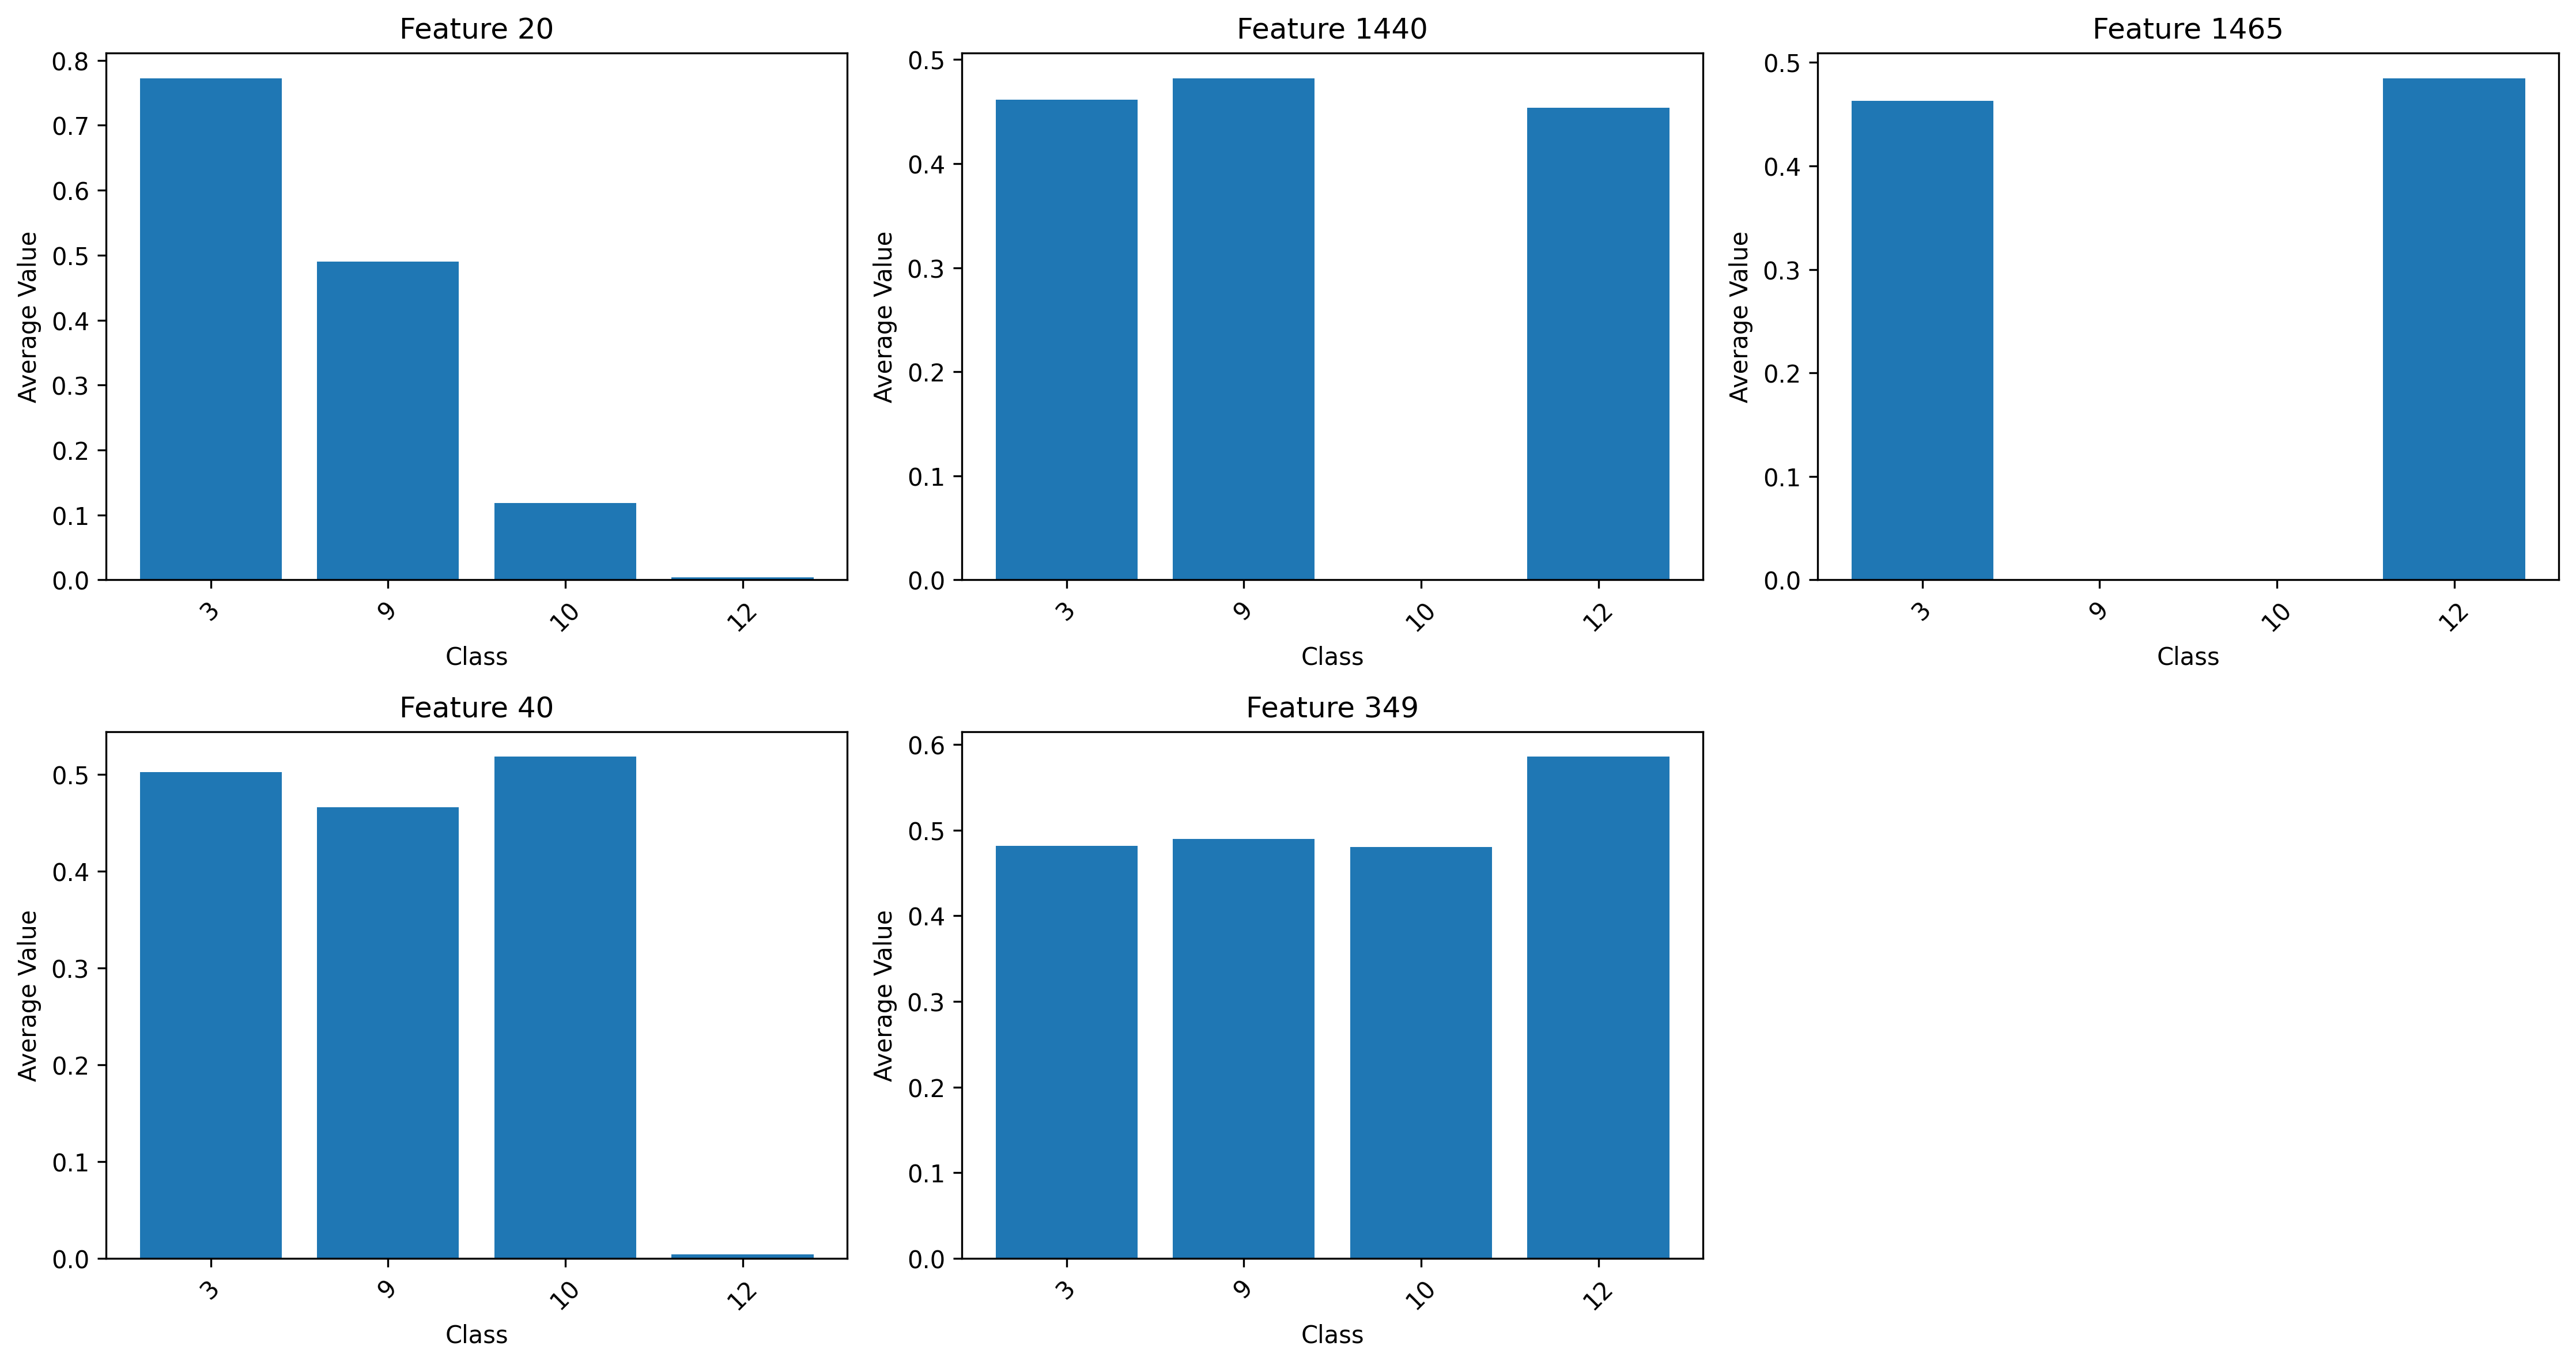

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_average_feature_values(X, y, important_indices, class_labels=None):

    if hasattr(X, 'todense'):
        X = X.todense()
    X = np.array(X)

    unique_classes = np.unique(y)

    plt.figure(figsize=(15, 8))

    for idx, feature_idx in enumerate(important_indices):
        plt.subplot(2, (len(important_indices) + 1) // 2, idx+1)

        means = []
        for cls in unique_classes:
            mean_value = X[y == cls, feature_idx].mean()
            means.append(mean_value)

        # Plot
        plt.bar(range(len(unique_classes)), means, tick_label=class_labels if class_labels else unique_classes)
        plt.title(f"Feature {feature_idx}")
        plt.xlabel("Class")
        plt.ylabel("Average Value")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

important_indices = [20, 1440, 1465, 40, 349]
plot_average_feature_values(X_test, y_test, important_indices)

Looking at these five feature graphs adds significant clarity about why these particular byte positions are most important for the deep packet inspection model:

1. Feature 20:
Shows dramatic variation across classes. **Being in the TCP/IP header region (21st byte), this likely represents a protocol identifier or control flag that strongly indicates traffic type**

2. Feature 40:
Shows distinct patterns. **Located in early packet structure, likely part of TCP options or the beginning of application headers**

3. Feature 349:
Shows similar values (0.48-0.49) for Classes 3, 9, and 10, but significantly higher (~0.59) for Class 12. **The consistent pattern for three classes with divergence for one suggests application-specific content**

4. Feature 1440:
Shows moderate variation (~0.46-0.49) but is present across all classes
This deeper payload byte contains information common to all traffic types
Subtle variations provide secondary classification signals

5. Feature 1465:
Only present in Classes 3 and 12 (both around 0.46-0.48)
Completely absent in Classes 9 and 10
**This end-of-packet feature creates a clean binary separator between two groups of traffic classes**

***The model finds these bytes particularly valuable because they create natural decision boundaries. Feature 20 primarily separates Class 3, Feature 40 isolates Class 12, Feature 349 provides additional confirmation for Class 12, and Feature 1465 groups Classes 3/12 separate from 9/10. Together, they form a fingerprint system that can reliably distinguish between these traffic types without needing to understand packet semantics.***

***FINAL TAKE:***

Based on the packet byte positions, we can make educated guesses about what each of these important features likely represents in the packet structure:

**Feature 20: IP header - likely TCP source port or protocol identifier field.**
This falls within the IP header or possibly the beginning of the TCP header. Given its position, this is likely:
Part of the IP header's source/destination address fields
Or possibly the beginning of the TCP header (TCP source port)
The high variability and strong class separation suggests it could be a protocol identifier or flag field

**Feature 40 - TCP header end/application header start - likely protocol-specific control flags.**
This position typically falls within the TCP header or just at the beginning of application data:
Likely TCP options or control flags
Could be application layer protocol header start (e.g., HTTP method first byte)
The distinctive patterns, especially the near-zero for Class 12, suggest protocol-specific data

**Feature 349 - Early application payload - distinctive application content signature.**
This is well into the application payload:
Definitely application-specific data
At this depth, it could be part of a request/response body
Possibly a field in application protocol (like a specific HTTP header value)
Class 12's higher value suggests unique content at this position

Feature 1440 - **Deep application payload - common content structure across applications.**
Likely part of the main content or data transfer
At this depth, typically application-specific data
Could be part of media content, file transfer, or encrypted data
The universal presence across classes suggests common payload structure

**Feature 1465 - End of packet/payload - application-specific trailer or end marker.**
Likely close to packet padding or trailer information
Could be application payload end markers
Possibly checksum or integrity verification data
The binary presence pattern (only in Classes 3/12) suggests it might be a signature of specific application protocols

These positions reveal how packet inspection models leverage structure and content patterns across different network protocols without needing to fully decode the packet semantics.

###Random Forest

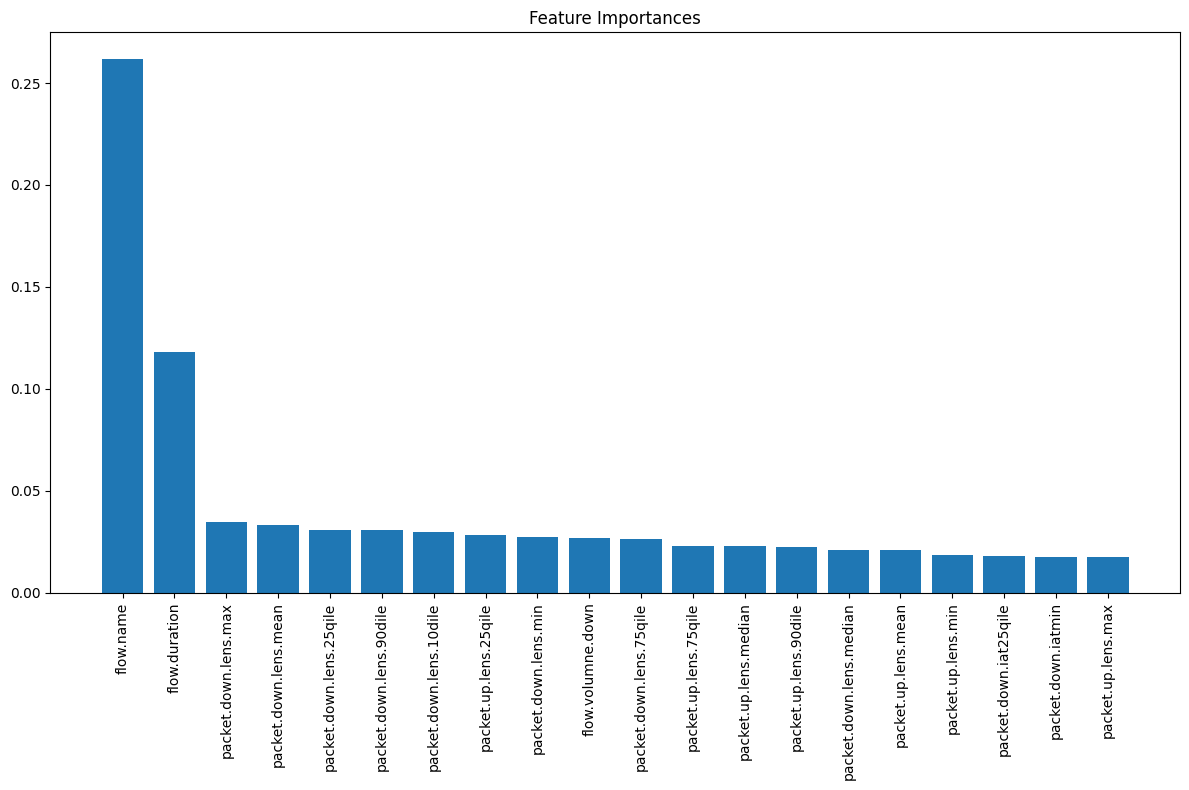

The two standout features are:

1. flow.name (approximately 0.26 importance) - This is by far the most important feature, suggesting the model heavily relies on the name or identifier of network flows to make predictions. This likely indicates that specific flow names strongly correlate with whatever the model is trying to predict.
2. flow.duration (approximately 0.12 importance) - The second most important feature, showing that the length of time a network flow lasts significantly influences predictions.

The remaining features (various packet statistics like packet.down.lens.max, packet.down.lens.mean, etc.) all have much lower importance values (around 0.03 or less). This pattern is typical in network traffic analysis, where Random Forests often prioritize flow identification and timing characteristics over individual packet metrics. Flow name might be crucial because it directly identifies the type of traffic, while duration often distinguishes between different traffic behaviors (e.g., streaming vs. browsing).

##Cost

DeepPacket:

Hardware: NVIDIA T4 GPU

Inference Time: ~1 hour 15 minutes

DeepPacket relies on a deep learning architecture, specifically 1D-CNN layers over raw packet bytes. While effective, this architecture involves complex operations across multiple layers with millions of parameters, leading to high computational demands during testing.

RF Model

Hardware: CPU (12 GB RAM, multi-threaded)

Inference Time: ~5 minutes

The model uses classical machine learning techniques (Random Forest), which benefit from:
Pre-processed and engineered features (instead of raw packet input),
Multi-threading (enabled by the n_jobs=-1 parameter), Faster decision tree evaluations compared to neural networks during inference.

**Comparison**

Metric	DeepPacket	RF Model

Testing Time	~1 hr 15 min	~5 min

Hardware	T4 GPU	CPU (12 GB RAM)

Architecture	Deep Learning (1D-CNN)	Random Forest (multi-threaded)

Inference Complexity	High (layered convolution)	Moderate (tree traversal)

**Conclusion: In terms of system cost, RF model significantly outperforms DeepPacket for inference. It is 15× faster while operating entirely on a CPU, making it a far more resource-efficient choice for real-time or large-scale deployment scenarios.**